# Poisson 2d
---

Consider the 2d Poisson Equation
\begin{equation}
\begin{aligned}
&\nabla \cdot (\sigma \nabla u) = 0, \\
&u|_{\partial\Omega} = g, \\
\end{aligned}
\end{equation}
where the domain $\Omega = [0, 1]\times [0, 1]$, and the target field $\sigma(x, y)\equiv 1$.
$g$ is chosen such that the exact solution is
\begin{equation}
u(x, y) = \exp(\pi y)\sin(\pi x).
\end{equation}

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("./"))))

import torch
import torch.nn as nn
import numpy as np

from pinn_lightning.pinn import PINN, InversePINN, Task
from pinn_lightning.data.dataset import PINNDataModule
from pinn_lightning.data.utils import tensor_grid, tensors_from_numpy
from pinn_lightning.utils.basic_nets import *
from pinn_lightning.utils.operators import grad, directional_grad

import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config Completer.use_jedi = False

import random
torch.manual_seed(1001)
np.random.seed(1001)
random.seed(1001)

torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

# Step 1: Define Model

In [2]:
class Poisson2d(PINN):	
	def get_output(self, batch_input):
		(x_domain, y_domain), (x_bc, y_bc) = batch_input
		x_domain.requires_grad = True
		y_domain.requires_grad = True
		u_domain = self.forward(torch.hstack([x_domain, y_domain]))
		eq = grad(grad(u_domain, x_domain), x_domain) + \
			grad(grad(u_domain, y_domain), y_domain)
		
		u_bc = self.forward(torch.hstack([x_bc, y_bc]))
		return eq, u_bc

forward_module = DenseNet(
	[2] + [128]*6 + [1], Swish,
)

pinn = Poisson2d(forward_module)
pinn.configure_tasks(
	[
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
		),
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 100.0,
		),
	]
)
optimizer = torch.optim.Adam(
	[
		{
			"params": pinn.param_groups[0],
			"lr": 1e-2,
			"weight_decay": 1e-6
		},
	]
)
pinn.configure_optimizers_and_schedulers(
	optimizer = optimizer,
	lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		optimizer,
		factor = 0.8,
		patience = 50,
		threshold = 1e-6,
		min_lr = 1e-4,
	),
)
pinn

Poisson2d(
  (forward_module): DenseNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Swish()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Swish()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Swish()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): Swish()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): Swish()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): Swish()
      (12): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

# Step 2: Generate Dataset

In [3]:
x_1d = np.linspace(0, 1, 100).reshape((-1, 1))
y_1d = np.linspace(0, 1, 100).reshape((-1, 1))
xy = tensor_grid([x_1d, y_1d])
x_domain, y_domain = xy[:, 0:1], xy[:, 1:2]

x_bc_1d = np.linspace(0, 1, 101).reshape((-1, 1))
y_bc_1d = np.linspace(0, 1, 99).reshape((-1, 1))
xy_bc = np.vstack(
	[
		np.hstack([x_bc_1d, 0*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), y_bc_1d]),
		np.hstack([x_bc_1d, np.ones_like(x_bc_1d)]),
		np.hstack([0*np.ones_like(y_bc_1d), y_bc_1d]),
	]
)
x_bc, y_bc = xy_bc[:, 0:1], xy_bc[:, 1:2]
u_fn = lambda x, y: np.exp(np.pi*y)*np.sin(np.pi*x)
g_bc = u_fn(x_bc, y_bc)

residue_targets_domain = np.zeros_like(x_domain)

In [4]:
dataset_domain = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_domain, y_domain, residue_targets_domain),
)
dataset_bc = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_bc, y_bc, g_bc),
)

poisson_data_module = PINNDataModule(
	datasets = [dataset_domain, dataset_bc],
	collate_fns = [None, None],
	valid_splits = [0.2, 0.2],
	batch_sizes = [40000, 4000],
)

# Step 3: training

In [5]:
trainer = pl.Trainer(
	max_epochs=10000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models_dirichlet_forward", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step')
	],
	log_every_n_steps=10,
)
trainer.fit(
	pinn,
	poisson_data_module,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/chuan/GitHub/PINN_lightning/examples/example_1_Poisson_2d/lightning_logs

  | Name           | Type     | Params
--------------------------------------------
0 | forward_module | DenseNet | 83.1 K
--------------------------------------------
83.1 K    Trainable params
0         Non-trainable params
83.1 K    Total params
0.332     Total estimated model params size (MB)


/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2000. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: : 0it [00:00, ?it/s]

/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8000. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: : 1it [00:00,  4.21it/s, loss=6.82e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: : 3it [00:00, 10.26it/s, loss=6.82e+03, v_num=0]
Epoch 1: : 1it [00:00,  3.95it/s, loss=6.75e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 3it [00:00,  9.32it/s, loss=6.75e+03, v_num=0]
Epoch 2: : 1it [00:00,  5.17it/s, loss=6.51e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: : 3it [00:00, 12.12it/s, loss=6.51e+03, v_num=0]
Epoch 3: : 1it [00:00,  3.88it/s, loss=6.08e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: : 3it [00:00,  9.27it/s, loss=6.08e+03, v_num=0]
Epoch 4: : 1it [00:00,  4.90it/s, loss=6.57e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: : 3it [00:00, 11.77it/s, loss=6.57e+03, v_num=0]
Epoch 5: : 1it [00:00,  3.72it/s, loss=6.26e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: : 3it [00:00,  9.47it/s, loss=6.26e+03, v_num=0]
Epoch 6: : 1it [00:00,  5.41it/s, loss=6.17e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: : 3it [00:00, 11.69i

Epoch 53: : 3it [00:00, 12.20it/s, loss=1.82e+03, v_num=0]
Epoch 54: : 2it [00:00,  7.64it/s, loss=1.76e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 54: : 3it [00:00,  9.69it/s, loss=1.76e+03, v_num=0]
Epoch 55: : 2it [00:00,  9.76it/s, loss=1.71e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 55: : 3it [00:00, 10.99it/s, loss=1.71e+03, v_num=0]
Epoch 56: : 2it [00:00,  7.98it/s, loss=1.66e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 56: : 3it [00:00,  9.49it/s, loss=1.66e+03, v_num=0]
Epoch 57: : 2it [00:00, 10.61it/s, loss=1.61e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 57: : 3it [00:00, 12.47it/s, loss=1.61e+03, v_num=0]
Epoch 58: : 2it [00:00,  7.88it/s, loss=1.55e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 58: : 3it [00:00,  9.41it/s, loss=1.55e+03, v_num=0]
Epoch 59: : 2it [00:00,  8.75it/s, loss=1.51e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 59: : 3it [00:00,  8.50it/s, loss=1.51e+03, v_num=0]
Epoch 60: : 2it [00:00,  9.93it/s, loss=1.47e+0

Epoch 108: : 3it [00:00, 12.35it/s, loss=79.7, v_num=0]
Epoch 109: : 2it [00:00,  7.71it/s, loss=72.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 109: : 3it [00:00,  9.59it/s, loss=72.4, v_num=0]
Epoch 110: : 2it [00:00, 10.41it/s, loss=65.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 110: : 3it [00:00,  9.98it/s, loss=65.8, v_num=0]
Epoch 111: : 2it [00:00,  9.79it/s, loss=56.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 111: : 3it [00:00, 11.20it/s, loss=56.5, v_num=0]
Epoch 112: : 2it [00:00,  7.75it/s, loss=52.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 112: : 3it [00:00,  9.35it/s, loss=52.2, v_num=0]
Epoch 113: : 2it [00:00,  9.69it/s, loss=48.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 113: : 3it [00:00, 11.67it/s, loss=48.8, v_num=0]
Epoch 114: : 2it [00:00,  7.51it/s, loss=43.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 114: : 3it [00:00,  9.47it/s, loss=43.2, v_num=0]
Epoch 115: : 2it [00:00,  9.87it/s, loss=38.5, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 163: : 3it [00:00,  8.69it/s, loss=1.55, v_num=0]
Epoch 164: : 2it [00:00, 10.53it/s, loss=1.5, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 164: : 3it [00:00, 12.15it/s, loss=1.5, v_num=0]
Epoch 165: : 2it [00:00,  7.16it/s, loss=1.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 165: : 3it [00:00,  8.67it/s, loss=1.46, v_num=0]
Epoch 166: : 2it [00:00,  9.45it/s, loss=1.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 166: : 3it [00:00, 10.88it/s, loss=1.43, v_num=0]
Epoch 167: : 2it [00:00,  7.45it/s, loss=1.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 167: : 3it [00:00,  8.96it/s, loss=1.39, v_num=0]
Epoch 168: : 2it [00:00,  9.72it/s, loss=1.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 168: : 3it [00:00, 11.76it/s, loss=1.35, v_num=0]
Epoch 169: : 2it [00:00,  7.42it/s, loss=1.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 169: : 3it [00:00,  8.95it/s, loss=1.31, v_num=0]
Epoch 170: : 2it [00:00, 10.67it/s, loss=1.29, v_num=0]
Validating: 0it [00:00, ?it/s]


Epoch 218: : 3it [00:00,  8.37it/s, loss=40.1, v_num=0]
Epoch 219: : 2it [00:00,  9.85it/s, loss=46.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 219: : 3it [00:00, 11.70it/s, loss=46.2, v_num=0]
Epoch 220: : 2it [00:00,  7.27it/s, loss=50.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 220: : 3it [00:00,  8.90it/s, loss=50.3, v_num=0]
Epoch 221: : 2it [00:00, 10.60it/s, loss=52, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 221: : 3it [00:00, 12.68it/s, loss=52, v_num=0]
Epoch 222: : 2it [00:00,  8.12it/s, loss=53.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 222: : 3it [00:00,  9.89it/s, loss=53.7, v_num=0]
Epoch 223: : 2it [00:00, 10.11it/s, loss=58.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 223: : 3it [00:00,  9.09it/s, loss=58.9, v_num=0]
Epoch 224: : 2it [00:00,  9.65it/s, loss=68.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 224: : 3it [00:00, 10.89it/s, loss=68.5, v_num=0]
Epoch 225: : 2it [00:00,  7.62it/s, loss=73.1, v_num=0]
V

Epoch 274: : 2it [00:00, 10.53it/s, loss=6.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 274: : 3it [00:00,  9.22it/s, loss=6.19, v_num=0]
Epoch 275: : 2it [00:00, 10.53it/s, loss=6.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 275: : 3it [00:00, 12.45it/s, loss=6.02, v_num=0]
Epoch 276: : 2it [00:00,  7.76it/s, loss=5.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 276: : 3it [00:00,  9.49it/s, loss=5.38, v_num=0]
Epoch 277: : 2it [00:00,  9.55it/s, loss=4.7, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 277: : 3it [00:00, 10.85it/s, loss=4.7, v_num=0]
Epoch 278: : 2it [00:00,  7.70it/s, loss=4.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 278: : 3it [00:00,  9.13it/s, loss=4.4, v_num=0]
Epoch 279: : 2it [00:00,  9.65it/s, loss=4.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 279: : 3it [00:00, 11.33it/s, loss=4.03, v_num=0]
Epoch 280: : 2it [00:00,  7.31it/s, loss=3.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 280: : 3it [00:00,  9

Epoch 329: : 2it [00:00,  6.85it/s, loss=0.455, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 329: : 3it [00:00,  8.44it/s, loss=0.455, v_num=0]
Epoch 330: : 2it [00:00,  9.59it/s, loss=0.45, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 330: : 3it [00:00, 11.59it/s, loss=0.45, v_num=0]
Epoch 331: : 2it [00:00,  7.99it/s, loss=0.444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 331: : 3it [00:00,  9.93it/s, loss=0.444, v_num=0]
Epoch 332: : 2it [00:00,  9.49it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 332: : 3it [00:00, 11.32it/s, loss=0.439, v_num=0]
Epoch 333: : 2it [00:00,  7.57it/s, loss=0.434, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 333: : 3it [00:00,  9.56it/s, loss=0.434, v_num=0]
Epoch 334: : 2it [00:00, 10.37it/s, loss=0.428, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 334: : 3it [00:00, 11.74it/s, loss=0.428, v_num=0]
Epoch 335: : 2it [00:00,  7.81it/s, loss=0.424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 335: : 3it [00:00,  9.48it/s, loss=0.

Epoch 383: : 3it [00:00, 11.41it/s, loss=0.291, v_num=0]
Epoch 384: : 2it [00:00,  7.13it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 384: : 3it [00:00,  9.07it/s, loss=0.289, v_num=0]
Epoch 385: : 2it [00:00,  9.67it/s, loss=0.287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 385: : 3it [00:00, 10.97it/s, loss=0.287, v_num=0]
Epoch 386: : 2it [00:00,  7.45it/s, loss=0.286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 386: : 3it [00:00,  9.37it/s, loss=0.286, v_num=0]
Epoch 387: : 2it [00:00, 10.54it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 387: : 3it [00:00,  9.31it/s, loss=0.284, v_num=0]
Epoch 388: : 2it [00:00,  9.61it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 388: : 3it [00:00, 11.63it/s, loss=0.282, v_num=0]
Epoch 389: : 2it [00:00,  6.91it/s, loss=0.28, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 389: : 3it [00:00,  8.94it/s, loss=0.28, v_num=0]
Epoch 390: : 2it [00:00, 10.76it/s, loss=0.

Epoch 437: : 3it [00:00,  9.29it/s, loss=0.214, v_num=0]
Epoch 438: : 2it [00:00, 10.63it/s, loss=0.213, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 438: : 3it [00:00,  9.21it/s, loss=0.213, v_num=0]
Epoch 439: : 2it [00:00,  9.82it/s, loss=0.212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 439: : 3it [00:00, 11.43it/s, loss=0.212, v_num=0]
Epoch 440: : 2it [00:00,  7.34it/s, loss=0.211, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 440: : 3it [00:00,  8.91it/s, loss=0.211, v_num=0]
Epoch 441: : 2it [00:00, 10.39it/s, loss=0.21, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 441: : 3it [00:00, 11.52it/s, loss=0.21, v_num=0]
Epoch 442: : 2it [00:00,  7.37it/s, loss=0.209, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 442: : 3it [00:00,  8.98it/s, loss=0.209, v_num=0]
Epoch 443: : 2it [00:00, 10.42it/s, loss=0.207, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 443: : 3it [00:00, 12.22it/s, loss=0.207, v_num=0]
Epoch 444: : 2it [00:00,  7.44it/s, loss=0.

Validating: 0it [00:00, ?it/s]
Epoch 492: : 3it [00:00, 12.00it/s, loss=0.165, v_num=0]
Epoch 493: : 2it [00:00,  7.34it/s, loss=0.164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 493: : 3it [00:00,  8.88it/s, loss=0.164, v_num=0]
Epoch 494: : 2it [00:00, 10.28it/s, loss=0.163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 494: : 3it [00:00, 11.42it/s, loss=0.163, v_num=0]
Epoch 495: : 2it [00:00,  7.12it/s, loss=0.163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 495: : 3it [00:00,  8.79it/s, loss=0.163, v_num=0]
Epoch 496: : 2it [00:00, 10.32it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 496: : 3it [00:00, 11.89it/s, loss=0.162, v_num=0]
Epoch 497: : 2it [00:00,  7.34it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 497: : 3it [00:00,  8.76it/s, loss=0.161, v_num=0]
Epoch 498: : 2it [00:00, 10.35it/s, loss=0.16, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 498: : 3it [00:00, 11.49it/s, loss=0.16, v_num=0]
Epoch 499: : 2it [00:00,  7.20it/s, loss=0.

Epoch 547: : 2it [00:00, 10.51it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 547: : 3it [00:00, 12.20it/s, loss=0.131, v_num=0]
Epoch 548: : 2it [00:00,  7.89it/s, loss=0.13, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 548: : 3it [00:00,  9.32it/s, loss=0.13, v_num=0]
Epoch 549: : 2it [00:00,  8.73it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 549: : 3it [00:00, 10.75it/s, loss=0.13, v_num=0]
Epoch 550: : 2it [00:00,  7.41it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 550: : 3it [00:00,  8.91it/s, loss=0.129, v_num=0]
Epoch 551: : 2it [00:00,  9.38it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 551: : 3it [00:00,  8.90it/s, loss=0.129, v_num=0]
Epoch 552: : 2it [00:00, 10.28it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 552: : 3it [00:00, 11.94it/s, loss=0.129, v_num=0]
Epoch 553: : 2it [00:00,  7.51it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 553: : 3

Epoch 602: : 2it [00:00, 10.42it/s, loss=180, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 602: : 3it [00:00,  9.54it/s, loss=180, v_num=0]
Epoch 603: : 2it [00:00,  8.87it/s, loss=179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 603: : 3it [00:00, 10.98it/s, loss=179, v_num=0]
Epoch 604: : 2it [00:00,  7.42it/s, loss=178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 604: : 3it [00:00,  9.05it/s, loss=178, v_num=0]
Epoch 605: : 2it [00:00, 10.62it/s, loss=165, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 605: : 3it [00:00, 12.49it/s, loss=165, v_num=0]
Epoch 606: : 2it [00:00,  7.21it/s, loss=155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 606: : 3it [00:00,  9.17it/s, loss=155, v_num=0]
Epoch 607: : 2it [00:00, 10.36it/s, loss=148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 607: : 3it [00:00, 12.30it/s, loss=148, v_num=0]
Epoch 608: : 2it [00:00,  7.64it/s, loss=135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 608: : 3it [00:00,  9.00it/s, l

Validating: 0it [00:00, ?it/s]
Epoch 657: : 3it [00:00,  8.57it/s, loss=1.52, v_num=0]
Epoch 658: : 2it [00:00,  9.80it/s, loss=1.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 658: : 3it [00:00, 11.24it/s, loss=1.37, v_num=0]
Epoch 659: : 2it [00:00,  7.47it/s, loss=1.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 659: : 3it [00:00,  9.08it/s, loss=1.33, v_num=0]
Epoch 660: : 2it [00:00,  9.85it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 660: : 3it [00:00, 11.90it/s, loss=1.19, v_num=0]
Epoch 661: : 2it [00:00,  8.06it/s, loss=1.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 661: : 3it [00:00, 10.10it/s, loss=1.15, v_num=0]
Epoch 662: : 2it [00:00, 10.54it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 662: : 3it [00:00,  9.08it/s, loss=1.06, v_num=0]
Epoch 663: : 2it [00:00, 10.16it/s, loss=0.984, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 663: : 3it [00:00, 11.28it/s, loss=0.984, v_num=0]
Epoch 664: : 2it [00:0

Epoch 712: : 2it [00:00,  7.30it/s, loss=0.26, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 712: : 3it [00:00,  9.30it/s, loss=0.26, v_num=0]
Epoch 713: : 2it [00:00, 10.40it/s, loss=0.257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 713: : 3it [00:00, 12.46it/s, loss=0.257, v_num=0]
Epoch 714: : 2it [00:00,  7.82it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 714: : 3it [00:00,  9.65it/s, loss=0.255, v_num=0]
Epoch 715: : 2it [00:00,  9.77it/s, loss=0.253, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 715: : 3it [00:00,  9.11it/s, loss=0.253, v_num=0]
Epoch 716: : 2it [00:00,  9.70it/s, loss=0.25, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 716: : 3it [00:00, 10.98it/s, loss=0.25, v_num=0]
Epoch 717: : 2it [00:00,  7.51it/s, loss=0.248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 717: : 3it [00:00,  9.23it/s, loss=0.248, v_num=0]
Epoch 718: : 2it [00:00, 10.65it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 718: : 

Epoch 766: : 3it [00:00,  8.49it/s, loss=0.183, v_num=0]
Epoch 767: : 2it [00:00, 10.19it/s, loss=0.182, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 767: : 3it [00:00, 11.50it/s, loss=0.182, v_num=0]
Epoch 768: : 2it [00:00,  7.03it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 768: : 3it [00:00,  8.52it/s, loss=0.181, v_num=0]
Epoch 769: : 2it [00:00, 10.58it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 769: : 3it [00:00, 11.53it/s, loss=0.181, v_num=0]
Epoch 770: : 2it [00:00,  7.36it/s, loss=0.18, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 770: : 3it [00:00,  9.08it/s, loss=0.18, v_num=0]
Epoch 771: : 2it [00:00, 10.61it/s, loss=0.179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 771: : 3it [00:00, 12.62it/s, loss=0.179, v_num=0]
Epoch 772: : 2it [00:00,  7.45it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 772: : 3it [00:00,  9.02it/s, loss=0.178, v_num=0]
Epoch 773: : 2it [00:00,  9.35it/s, loss=0.178, v_num=0]
Validating: 0it [

Epoch 821: : 3it [00:00,  8.62it/s, loss=0.15, v_num=0]
Epoch 822: : 2it [00:00, 10.20it/s, loss=0.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 822: : 3it [00:00, 11.53it/s, loss=0.15, v_num=0]
Epoch 823: : 2it [00:00,  7.23it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 823: : 3it [00:00,  8.80it/s, loss=0.149, v_num=0]
Epoch 824: : 2it [00:00,  9.64it/s, loss=0.149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 824: : 3it [00:00, 11.55it/s, loss=0.149, v_num=0]
Epoch 825: : 2it [00:00,  7.14it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 825: : 3it [00:00,  8.87it/s, loss=0.148, v_num=0]
Epoch 826: : 2it [00:00, 10.35it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 826: : 3it [00:00,  9.41it/s, loss=0.148, v_num=0]
Epoch 827: : 2it [00:00,  9.51it/s, loss=0.148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 827: : 3it [00:00, 11.23it/s, loss=0.148, v_num=0]
Epoch 828: : 2it [00:00,  7.67it/s, loss=0.14

Epoch 875: : 3it [00:00, 11.10it/s, loss=0.132, v_num=0]
Epoch 876: : 2it [00:00,  7.60it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 876: : 3it [00:00,  9.17it/s, loss=0.132, v_num=0]
Epoch 877: : 2it [00:00, 10.18it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 877: : 3it [00:00,  9.16it/s, loss=0.131, v_num=0]
Epoch 878: : 2it [00:00,  9.95it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 878: : 3it [00:00, 11.23it/s, loss=0.131, v_num=0]
Epoch 879: : 2it [00:00,  7.65it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 879: : 3it [00:00,  9.45it/s, loss=0.131, v_num=0]
Epoch 880: : 2it [00:00, 10.52it/s, loss=0.131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 880: : 3it [00:00, 11.70it/s, loss=0.131, v_num=0]
Epoch 881: : 2it [00:00,  7.87it/s, loss=0.13, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 881: : 3it [00:00,  9.33it/s, loss=0.13, v_num=0]
Epoch 882: : 2it [00:00,  9.69it/s, loss=0.

Epoch 930: : 2it [00:00,  9.60it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 930: : 3it [00:00,  9.21it/s, loss=0.12, v_num=0]
Epoch 931: : 2it [00:00, 10.15it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 931: : 3it [00:00, 11.46it/s, loss=0.12, v_num=0]
Epoch 932: : 2it [00:00,  7.26it/s, loss=0.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 932: : 3it [00:00,  8.73it/s, loss=0.12, v_num=0]
Epoch 933: : 2it [00:00,  9.37it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 933: : 3it [00:00, 10.69it/s, loss=0.119, v_num=0]
Epoch 934: : 2it [00:00,  6.83it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 934: : 3it [00:00,  8.55it/s, loss=0.119, v_num=0]
Epoch 935: : 2it [00:00,  9.82it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 935: : 3it [00:00, 11.88it/s, loss=0.119, v_num=0]
Epoch 936: : 2it [00:00,  7.38it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 936: : 3it [00:00,  8.87it/s, loss=0.119, 

Epoch 984: : 3it [00:00, 11.12it/s, loss=0.11, v_num=0]
Epoch 985: : 2it [00:00,  7.34it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 985: : 3it [00:00,  8.88it/s, loss=0.11, v_num=0]
Epoch 986: : 2it [00:00,  9.53it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 986: : 3it [00:00, 11.49it/s, loss=0.11, v_num=0]
Epoch 987: : 2it [00:00,  7.31it/s, loss=0.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 987: : 3it [00:00,  9.28it/s, loss=0.11, v_num=0]
Epoch 988: : 2it [00:00,  9.71it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 988: : 3it [00:00, 11.02it/s, loss=0.109, v_num=0]
Epoch 989: : 2it [00:00,  7.63it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 989: : 3it [00:00,  9.12it/s, loss=0.109, v_num=0]
Epoch 990: : 2it [00:00,  9.49it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 990: : 3it [00:00,  8.98it/s, loss=0.109, v_num=0]
Epoch 991: : 2it [00:00, 10.57it/s, loss=0.109, v_num=0]
Validating: 0it [00:00,

Epoch 1039: : 2it [00:00, 10.58it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1039: : 3it [00:00, 12.60it/s, loss=0.101, v_num=0]
Epoch 1040: : 2it [00:00,  7.54it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1040: : 3it [00:00,  9.47it/s, loss=0.101, v_num=0]
Epoch 1041: : 2it [00:00, 10.55it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1041: : 3it [00:00,  9.73it/s, loss=0.101, v_num=0]
Epoch 1042: : 2it [00:00, 10.63it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1042: : 3it [00:00, 11.71it/s, loss=0.101, v_num=0]
Epoch 1043: : 2it [00:00,  7.22it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1043: : 3it [00:00,  9.10it/s, loss=0.101, v_num=0]
Epoch 1044: : 2it [00:00,  9.52it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1044: : 3it [00:00, 11.01it/s, loss=0.101, v_num=0]
Epoch 1045: : 2it [00:00,  7.57it/s, loss=0.101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1045: : 3it [00:00,  9.

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1092: : 3it [00:00,  8.77it/s, loss=0.0941, v_num=0]
Epoch 1093: : 2it [00:00,  9.94it/s, loss=0.094, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1093: : 3it [00:00, 11.75it/s, loss=0.094, v_num=0]
Epoch 1094: : 2it [00:00,  6.69it/s, loss=0.0939, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1094: : 3it [00:00,  8.18it/s, loss=0.0939, v_num=0]
Epoch 1095: : 2it [00:00,  9.53it/s, loss=0.0938, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1095: : 3it [00:00, 11.51it/s, loss=0.0938, v_num=0]
Epoch 1096: : 2it [00:00,  7.30it/s, loss=0.0936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1096: : 3it [00:00,  8.84it/s, loss=0.0936, v_num=0]
Epoch 1097: : 2it [00:00, 10.02it/s, loss=0.0935, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1097: : 3it [00:00, 11.81it/s, loss=0.0935, v_num=0]
Epoch 1098: : 2it [00:00,  6.38it/s, loss=0.0934, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1098: : 3it [00:00,  8.20it/s, loss=0.0

Validating: 0it [00:00, ?it/s]
Epoch 1145: : 3it [00:00,  8.89it/s, loss=0.0877, v_num=0]
Epoch 1146: : 2it [00:00, 10.06it/s, loss=0.0876, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1146: : 3it [00:00, 11.27it/s, loss=0.0876, v_num=0]
Epoch 1147: : 2it [00:00,  6.54it/s, loss=0.0875, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1147: : 3it [00:00,  8.10it/s, loss=0.0875, v_num=0]
Epoch 1148: : 2it [00:00,  8.67it/s, loss=0.0874, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1148: : 3it [00:00,  9.92it/s, loss=0.0874, v_num=0]
Epoch 1149: : 2it [00:00,  7.57it/s, loss=0.0873, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1149: : 3it [00:00,  9.55it/s, loss=0.0873, v_num=0]
Epoch 1150: : 2it [00:00,  9.64it/s, loss=0.0872, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1150: : 3it [00:00, 11.15it/s, loss=0.0872, v_num=0]
Epoch 1151: : 2it [00:00,  8.04it/s, loss=0.0871, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1151: : 3it [00:00, 10.06it/s, loss=0.0871, v_num=0]
Epoch 1152: : 2i

Epoch 1199: : 2it [00:00, 10.16it/s, loss=0.0819, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1199: : 3it [00:00, 11.34it/s, loss=0.0819, v_num=0]
Epoch 1200: : 2it [00:00,  7.02it/s, loss=0.0818, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1200: : 3it [00:00,  8.54it/s, loss=0.0818, v_num=0]
Epoch 1201: : 2it [00:00,  9.62it/s, loss=0.0817, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1201: : 3it [00:00, 11.05it/s, loss=0.0817, v_num=0]
Epoch 1202: : 2it [00:00,  7.11it/s, loss=0.0816, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1202: : 3it [00:00,  8.71it/s, loss=0.0816, v_num=0]
Epoch 1203: : 2it [00:00,  8.81it/s, loss=0.0815, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1203: : 3it [00:00, 10.77it/s, loss=0.0815, v_num=0]
Epoch 1204: : 2it [00:00,  7.80it/s, loss=0.0814, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1204: : 3it [00:00,  9.75it/s, loss=0.0814, v_num=0]
Epoch 1205: : 2it [00:00, 10.46it/s, loss=0.0813, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it 

Epoch 1252: : 2it [00:00,  9.22it/s, loss=0.0767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1252: : 3it [00:00, 10.95it/s, loss=0.0767, v_num=0]
Epoch 1253: : 2it [00:00,  7.36it/s, loss=0.0766, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1253: : 3it [00:00,  8.86it/s, loss=0.0766, v_num=0]
Epoch 1254: : 2it [00:00, 10.56it/s, loss=0.0766, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1254: : 3it [00:00, 12.34it/s, loss=0.0766, v_num=0]
Epoch 1255: : 2it [00:00,  7.58it/s, loss=0.0765, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1255: : 3it [00:00,  9.06it/s, loss=0.0765, v_num=0]
Epoch 1256: : 2it [00:00,  9.53it/s, loss=0.0764, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1256: : 3it [00:00,  8.57it/s, loss=0.0764, v_num=0]
Epoch 1257: : 2it [00:00, 10.29it/s, loss=0.0763, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1257: : 3it [00:00, 11.60it/s, loss=0.0763, v_num=0]
Epoch 1258: : 2it [00:00,  7.43it/s, loss=0.0762, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 1305: : 3it [00:00, 11.44it/s, loss=0.072, v_num=0]
Epoch 1306: : 2it [00:00,  7.98it/s, loss=0.072, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1306: : 3it [00:00,  9.75it/s, loss=0.072, v_num=0]
Epoch 1307: : 2it [00:00, 10.30it/s, loss=0.0719, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1307: : 3it [00:00,  9.14it/s, loss=0.0719, v_num=0]
Epoch 1308: : 2it [00:00,  9.58it/s, loss=0.0718, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1308: : 3it [00:00, 11.43it/s, loss=0.0718, v_num=0]
Epoch 1309: : 2it [00:00,  7.52it/s, loss=0.0717, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1309: : 3it [00:00,  9.05it/s, loss=0.0717, v_num=0]
Epoch 1310: : 2it [00:00,  9.05it/s, loss=0.0716, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1310: : 3it [00:00, 10.87it/s, loss=0.0716, v_num=0]
Epoch 1311: : 2it [00:00,  7.54it/s, loss=0.0715, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1311: : 3it [00:00,  9.10it/s, loss=0.071

Validating: 0it [00:00, ?it/s]
Epoch 1358: : 3it [00:00,  9.12it/s, loss=0.0677, v_num=0]
Epoch 1359: : 2it [00:00, 10.40it/s, loss=0.0677, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1359: : 3it [00:00, 11.92it/s, loss=0.0677, v_num=0]
Epoch 1360: : 2it [00:00,  7.49it/s, loss=0.0676, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1360: : 3it [00:00,  9.40it/s, loss=0.0676, v_num=0]
Epoch 1361: : 2it [00:00, 10.38it/s, loss=0.0675, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1361: : 3it [00:00, 12.24it/s, loss=0.0675, v_num=0]
Epoch 1362: : 2it [00:00,  7.44it/s, loss=0.0674, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1362: : 3it [00:00,  9.41it/s, loss=0.0674, v_num=0]
Epoch 1363: : 2it [00:00,  9.82it/s, loss=0.0673, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1363: : 3it [00:00, 10.97it/s, loss=0.0673, v_num=0]
Epoch 1364: : 2it [00:00,  7.57it/s, loss=0.0673, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1364: : 3it [00:00,  9.13it/s, loss=0.0673, v_num=0]
Epoch 1365: : 2i

Epoch 1412: : 2it [00:00,  9.41it/s, loss=0.0637, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1412: : 3it [00:00, 11.02it/s, loss=0.0637, v_num=0]
Epoch 1413: : 2it [00:00,  7.79it/s, loss=0.0636, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1413: : 3it [00:00,  9.30it/s, loss=0.0636, v_num=0]
Epoch 1414: : 2it [00:00,  9.77it/s, loss=0.0636, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1414: : 3it [00:00, 11.84it/s, loss=0.0636, v_num=0]
Epoch 1415: : 2it [00:00,  7.85it/s, loss=0.0635, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1415: : 3it [00:00,  9.43it/s, loss=0.0635, v_num=0]
Epoch 1416: : 2it [00:00, 10.27it/s, loss=0.0634, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1416: : 3it [00:00, 11.93it/s, loss=0.0634, v_num=0]
Epoch 1417: : 2it [00:00,  7.21it/s, loss=0.0633, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1417: : 3it [00:00,  8.87it/s, loss=0.0633, v_num=0]
Epoch 1418: : 2it [00:00,  8.95it/s, loss=0.0633, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1418: : 3i

Epoch 1464: : 3it [00:00,  8.31it/s, loss=0.0601, v_num=0]
Epoch 1465: : 2it [00:00,  9.61it/s, loss=0.06, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1465: : 3it [00:00, 11.05it/s, loss=0.06, v_num=0]
Epoch 1466: : 2it [00:00,  7.61it/s, loss=0.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1466: : 3it [00:00,  9.07it/s, loss=0.06, v_num=0]
Epoch 1467: : 2it [00:00, 10.32it/s, loss=0.0599, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1467: : 3it [00:00, 11.45it/s, loss=0.0599, v_num=0]
Epoch 1468: : 2it [00:00,  7.63it/s, loss=0.0598, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1468: : 3it [00:00,  9.34it/s, loss=0.0598, v_num=0]
Epoch 1469: : 2it [00:00, 10.45it/s, loss=0.0598, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1469: : 3it [00:00, 12.38it/s, loss=0.0598, v_num=0]
Epoch 1470: : 2it [00:00,  7.81it/s, loss=0.0597, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1470: : 3it [00:00,  9.64it/s, loss=0.0597, v_num=0]
Epoch 1471: : 2it [00:00,  9.50it/s, loss=0.0597, v_n

Epoch 1518: : 2it [00:00,  9.23it/s, loss=0.0567, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1518: : 3it [00:00, 11.10it/s, loss=0.0567, v_num=0]
Epoch 1519: : 2it [00:00,  7.68it/s, loss=0.0566, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1519: : 3it [00:00,  9.29it/s, loss=0.0566, v_num=0]
Epoch 1520: : 2it [00:00,  9.92it/s, loss=0.0565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1520: : 3it [00:00, 11.59it/s, loss=0.0565, v_num=0]
Epoch 1521: : 2it [00:00,  7.63it/s, loss=0.0565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1521: : 3it [00:00,  9.18it/s, loss=0.0565, v_num=0]
Epoch 1522: : 2it [00:00, 10.50it/s, loss=0.0564, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1522: : 3it [00:00,  9.32it/s, loss=0.0564, v_num=0]
Epoch 1523: : 2it [00:00, 10.50it/s, loss=0.0564, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1523: : 3it [00:00, 11.76it/s, loss=0.0564, v_num=0]
Epoch 1524: : 2it [00:00,  7.36it/s, loss=0.0563, v_num=0]
Validating: 0it 

Epoch 1571: : 2it [00:00, 10.54it/s, loss=0.0535, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1571: : 3it [00:00, 11.62it/s, loss=0.0535, v_num=0]
Epoch 1572: : 2it [00:00,  7.28it/s, loss=0.0535, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1572: : 3it [00:00,  8.72it/s, loss=0.0535, v_num=0]
Epoch 1573: : 2it [00:00, 10.15it/s, loss=0.0534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1573: : 3it [00:00,  9.49it/s, loss=0.0534, v_num=0]
Epoch 1574: : 2it [00:00,  9.77it/s, loss=0.0534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1574: : 3it [00:00, 11.60it/s, loss=0.0534, v_num=0]
Epoch 1575: : 2it [00:00,  7.15it/s, loss=0.0533, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1575: : 3it [00:00,  8.85it/s, loss=0.0533, v_num=0]
Epoch 1576: : 2it [00:00,  9.55it/s, loss=0.0532, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1576: : 3it [00:00, 10.99it/s, loss=0.0532, v_num=0]
Epoch 1577: : 2it [00:00,  7.11it/s, loss=0.0532, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1577: : 3i

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1624: : 3it [00:00,  9.44it/s, loss=0.0506, v_num=0]
Epoch 1625: : 2it [00:00,  9.50it/s, loss=0.0505, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1625: : 3it [00:00, 11.29it/s, loss=0.0505, v_num=0]
Epoch 1626: : 2it [00:00,  6.78it/s, loss=0.0505, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1626: : 3it [00:00,  8.34it/s, loss=0.0505, v_num=0]
Epoch 1627: : 2it [00:00,  9.27it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1627: : 3it [00:00, 11.25it/s, loss=0.0504, v_num=0]
Epoch 1628: : 2it [00:00,  6.98it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1628: : 3it [00:00,  8.82it/s, loss=0.0504, v_num=0]
Epoch 1629: : 2it [00:00,  9.62it/s, loss=0.0503, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1629: : 3it [00:00, 11.45it/s, loss=0.0503, v_num=0]
Epoch 1630: : 2it [00:00,  7.75it/s, loss=0.0503, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1630: : 3it [00:00,  9.66it/s, loss=0.

Epoch 1677: : 3it [00:00,  9.09it/s, loss=0.0479, v_num=0]
Epoch 1678: : 2it [00:00, 10.50it/s, loss=0.0478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1678: : 3it [00:00, 11.59it/s, loss=0.0478, v_num=0]
Epoch 1679: : 2it [00:00,  7.00it/s, loss=0.0478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1679: : 3it [00:00,  8.48it/s, loss=0.0478, v_num=0]
Epoch 1680: : 2it [00:00,  9.54it/s, loss=0.0477, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1680: : 3it [00:00, 10.55it/s, loss=0.0477, v_num=0]
Epoch 1681: : 2it [00:00,  7.45it/s, loss=0.0477, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1681: : 3it [00:00,  8.98it/s, loss=0.0477, v_num=0]
Epoch 1682: : 2it [00:00, 10.21it/s, loss=0.0476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1682: : 3it [00:00, 11.53it/s, loss=0.0476, v_num=0]
Epoch 1683: : 2it [00:00,  7.52it/s, loss=0.0476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1683: : 3it [00:00,  9.05it/s, loss=0.0476, v_num=0]
Epoch 1684: : 2it [00:00,  9.70it/s, loss=0.047

Epoch 1730: : 3it [00:00,  8.95it/s, loss=0.0453, v_num=0]
Epoch 1731: : 2it [00:00,  9.59it/s, loss=0.0453, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1731: : 3it [00:00, 11.06it/s, loss=0.0453, v_num=0]
Epoch 1732: : 2it [00:00,  7.50it/s, loss=0.0452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1732: : 3it [00:00,  9.49it/s, loss=0.0452, v_num=0]
Epoch 1733: : 2it [00:00,  9.04it/s, loss=0.0452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1733: : 3it [00:00, 10.92it/s, loss=0.0452, v_num=0]
Epoch 1734: : 2it [00:00,  7.79it/s, loss=0.0451, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1734: : 3it [00:00,  9.21it/s, loss=0.0451, v_num=0]
Epoch 1735: : 2it [00:00,  9.41it/s, loss=0.0451, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1735: : 3it [00:00, 10.66it/s, loss=0.0451, v_num=0]
Epoch 1736: : 2it [00:00,  7.61it/s, loss=0.045, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1736: : 3it [00:00,  9.05it/s, loss=0.045, v_num=0]
Epoch 1737: : 2it [00:00,  9.70it/s, loss=0.045,

Epoch 1784: : 2it [00:00, 10.40it/s, loss=0.0429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1784: : 3it [00:00, 12.23it/s, loss=0.0429, v_num=0]
Epoch 1785: : 2it [00:00,  7.44it/s, loss=0.0429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1785: : 3it [00:00,  9.17it/s, loss=0.0429, v_num=0]
Epoch 1786: : 2it [00:00,  9.62it/s, loss=0.0428, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1786: : 3it [00:00, 11.44it/s, loss=0.0428, v_num=0]
Epoch 1787: : 2it [00:00,  7.60it/s, loss=0.0428, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1787: : 3it [00:00,  9.15it/s, loss=0.0428, v_num=0]
Epoch 1788: : 2it [00:00, 10.69it/s, loss=0.0427, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1788: : 3it [00:00,  9.19it/s, loss=0.0427, v_num=0]
Epoch 1789: : 2it [00:00, 10.08it/s, loss=0.0427, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1789: : 3it [00:00, 11.42it/s, loss=0.0427, v_num=0]
Epoch 1790: : 2it [00:00,  7.39it/s, loss=0.0426, v_num=0]
Validating: 0it 

Epoch 1836: : 3it [00:00,  9.09it/s, loss=0.0407, v_num=0]
Epoch 1837: : 2it [00:00, 10.43it/s, loss=0.0407, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1837: : 3it [00:00, 11.51it/s, loss=0.0407, v_num=0]
Epoch 1838: : 2it [00:00,  7.16it/s, loss=0.0406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1838: : 3it [00:00,  8.81it/s, loss=0.0406, v_num=0]
Epoch 1839: : 2it [00:00,  9.53it/s, loss=0.0406, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1839: : 3it [00:00,  8.60it/s, loss=0.0406, v_num=0]
Epoch 1840: : 2it [00:00,  9.56it/s, loss=0.0406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1840: : 3it [00:00, 10.93it/s, loss=0.0406, v_num=0]
Epoch 1841: : 2it [00:00,  7.10it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1841: : 3it [00:00,  8.65it/s, loss=0.0405, v_num=0]
Epoch 1842: : 2it [00:00,  9.64it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1842: : 3it [00:00, 11.22it/s, loss=0.0405, v_num=0]
Epoch 1843: : 2i

Epoch 1889: : 3it [00:00,  9.43it/s, loss=0.0386, v_num=0]
Epoch 1890: : 2it [00:00,  9.73it/s, loss=0.0386, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1890: : 3it [00:00,  8.87it/s, loss=0.0386, v_num=0]
Epoch 1891: : 2it [00:00, 10.48it/s, loss=0.0386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1891: : 3it [00:00, 11.56it/s, loss=0.0386, v_num=0]
Epoch 1892: : 2it [00:00,  7.52it/s, loss=0.0385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1892: : 3it [00:00,  9.19it/s, loss=0.0385, v_num=0]
Epoch 1893: : 2it [00:00, 10.60it/s, loss=0.0385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1893: : 3it [00:00, 12.50it/s, loss=0.0385, v_num=0]
Epoch 1894: : 2it [00:00,  7.18it/s, loss=0.0384, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1894: : 3it [00:00,  8.96it/s, loss=0.0384, v_num=0]
Epoch 1895: : 2it [00:00,  9.60it/s, loss=0.0384, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1895: : 3it [00:00, 11.14it/s, loss=0.0384, v_num=0]
Epoch 1896: : 2i

Epoch 1942: : 3it [00:00, 11.64it/s, loss=0.0367, v_num=0]
Epoch 1943: : 2it [00:00,  7.60it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1943: : 3it [00:00,  9.11it/s, loss=0.0366, v_num=0]
Epoch 1944: : 2it [00:00,  9.00it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1944: : 3it [00:00, 10.16it/s, loss=0.0366, v_num=0]
Epoch 1945: : 2it [00:00,  7.52it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1945: : 3it [00:00,  9.44it/s, loss=0.0366, v_num=0]
Epoch 1946: : 2it [00:00, 10.45it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1946: : 3it [00:00, 12.12it/s, loss=0.0365, v_num=0]
Epoch 1947: : 2it [00:00,  7.37it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1947: : 3it [00:00,  9.10it/s, loss=0.0365, v_num=0]
Epoch 1948: : 2it [00:00,  8.89it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1948: : 3it [00:00, 10.30it/s, loss=0.0365, v_num=0]
Epoch 1949: : 2it [00:00,  7.14it/s, loss=0.036

Epoch 1995: : 3it [00:00, 10.83it/s, loss=0.0348, v_num=0]
Epoch 1996: : 2it [00:00,  7.77it/s, loss=0.0348, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1996: : 3it [00:00,  9.32it/s, loss=0.0348, v_num=0]
Epoch 1997: : 2it [00:00, 10.07it/s, loss=0.0348, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1997: : 3it [00:00, 11.57it/s, loss=0.0348, v_num=0]
Epoch 1998: : 2it [00:00,  7.62it/s, loss=0.0347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1998: : 3it [00:00,  9.61it/s, loss=0.0347, v_num=0]
Epoch 1999: : 2it [00:00,  9.51it/s, loss=0.0347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1999: : 3it [00:00, 10.99it/s, loss=0.0347, v_num=0]
Epoch 2000: : 2it [00:00,  7.18it/s, loss=0.0347, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2000: : 3it [00:00,  8.76it/s, loss=0.0347, v_num=0]
Epoch 2001: : 2it [00:00,  9.67it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2001: : 3it [00:00, 11.72it/s, loss=0.0346, v_num=0]
Epoch 2002: : 2it [00:00,  7.72it/s, loss=0.034

Epoch 2049: : 2it [00:00,  7.55it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2049: : 3it [00:00,  9.23it/s, loss=0.0331, v_num=0]
Epoch 2050: : 2it [00:00,  9.70it/s, loss=0.033, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2050: : 3it [00:00, 10.87it/s, loss=0.033, v_num=0]
Epoch 2051: : 2it [00:00,  7.96it/s, loss=0.033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2051: : 3it [00:00, 10.00it/s, loss=0.033, v_num=0]
Epoch 2052: : 2it [00:00, 10.33it/s, loss=0.033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2052: : 3it [00:00, 11.54it/s, loss=0.033, v_num=0]
Epoch 2053: : 2it [00:00,  7.19it/s, loss=0.0329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2053: : 3it [00:00,  8.86it/s, loss=0.0329, v_num=0]
Epoch 2054: : 2it [00:00,  9.71it/s, loss=0.0329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2054: : 3it [00:00,  9.16it/s, loss=0.0329, v_num=0]
Epoch 2055: : 2it [00:00,  9.51it/s, loss=0.0329, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2055: : 3it [00

Epoch 2102: : 2it [00:00,  7.45it/s, loss=0.0314, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2102: : 3it [00:00,  8.96it/s, loss=0.0314, v_num=0]
Epoch 2103: : 2it [00:00, 10.46it/s, loss=0.0314, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2103: : 3it [00:00, 11.53it/s, loss=0.0314, v_num=0]
Epoch 2104: : 2it [00:00,  7.08it/s, loss=0.0314, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2104: : 3it [00:00,  8.62it/s, loss=0.0314, v_num=0]
Epoch 2105: : 2it [00:00, 10.64it/s, loss=0.0314, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2105: : 3it [00:00,  9.30it/s, loss=0.0314, v_num=0]
Epoch 2106: : 2it [00:00,  9.71it/s, loss=0.0313, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2106: : 3it [00:00, 10.97it/s, loss=0.0313, v_num=0]
Epoch 2107: : 2it [00:00,  7.51it/s, loss=0.0313, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2107: : 3it [00:00,  9.44it/s, loss=0.0313, v_num=0]
Epoch 2108: : 2it [00:00, 10.18it/s, loss=0.0313, v_num=0]
Validating: 0it 

Epoch 2155: : 2it [00:00,  7.25it/s, loss=0.0299, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2155: : 3it [00:00,  9.16it/s, loss=0.0299, v_num=0]
Epoch 2156: : 2it [00:00,  9.52it/s, loss=0.0299, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2156: : 3it [00:00,  8.52it/s, loss=0.0299, v_num=0]
Epoch 2157: : 2it [00:00,  9.30it/s, loss=0.0299, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2157: : 3it [00:00, 11.19it/s, loss=0.0299, v_num=0]
Epoch 2158: : 2it [00:00,  7.35it/s, loss=0.0298, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2158: : 3it [00:00,  8.80it/s, loss=0.0298, v_num=0]
Epoch 2159: : 2it [00:00,  9.07it/s, loss=0.0298, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2159: : 3it [00:00, 10.28it/s, loss=0.0298, v_num=0]
Epoch 2160: : 2it [00:00,  7.08it/s, loss=0.0298, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2160: : 3it [00:00,  9.02it/s, loss=0.0298, v_num=0]
Epoch 2161: : 2it [00:00, 10.58it/s, loss=0.0298, v_num=0]
Validating: 0it 

Epoch 2208: : 2it [00:00, 10.45it/s, loss=0.0285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2208: : 3it [00:00, 11.67it/s, loss=0.0285, v_num=0]
Epoch 2209: : 2it [00:00,  7.41it/s, loss=0.0285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2209: : 3it [00:00,  9.21it/s, loss=0.0285, v_num=0]
Epoch 2210: : 2it [00:00, 10.44it/s, loss=0.0284, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2210: : 3it [00:00, 12.47it/s, loss=0.0284, v_num=0]
Epoch 2211: : 2it [00:00,  7.80it/s, loss=0.0284, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2211: : 3it [00:00,  9.81it/s, loss=0.0284, v_num=0]
Epoch 2212: : 2it [00:00,  9.11it/s, loss=0.0284, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2212: : 3it [00:00, 10.72it/s, loss=0.0284, v_num=0]
Epoch 2213: : 2it [00:00,  7.47it/s, loss=0.0283, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2213: : 3it [00:00,  9.49it/s, loss=0.0283, v_num=0]
Epoch 2214: : 2it [00:00, 10.42it/s, loss=0.0283, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2214: : 3i

Epoch 2261: : 2it [00:00, 10.64it/s, loss=0.0271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2261: : 3it [00:00, 12.48it/s, loss=0.0271, v_num=0]
Epoch 2262: : 2it [00:00,  6.48it/s, loss=0.0271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2262: : 3it [00:00,  8.17it/s, loss=0.0271, v_num=0]
Epoch 2263: : 2it [00:00,  9.31it/s, loss=0.0271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2263: : 3it [00:00, 10.80it/s, loss=0.0271, v_num=0]
Epoch 2264: : 2it [00:00,  7.36it/s, loss=0.027, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2264: : 3it [00:00,  9.35it/s, loss=0.027, v_num=0]
Epoch 2265: : 2it [00:00,  9.72it/s, loss=0.027, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2265: : 3it [00:00, 11.76it/s, loss=0.027, v_num=0]
Epoch 2266: : 2it [00:00,  7.16it/s, loss=0.027, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2266: : 3it [00:00,  8.56it/s, loss=0.027, v_num=0]
Epoch 2267: : 2it [00:00,  9.39it/s, loss=0.027, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2267: : 3it [00:

Epoch 2314: : 3it [00:00, 11.75it/s, loss=0.0258, v_num=0]
Epoch 2315: : 2it [00:00,  7.21it/s, loss=0.0258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2315: : 3it [00:00,  9.14it/s, loss=0.0258, v_num=0]
Epoch 2316: : 2it [00:00,  9.85it/s, loss=0.0258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2316: : 3it [00:00, 10.98it/s, loss=0.0258, v_num=0]
Epoch 2317: : 2it [00:00,  7.71it/s, loss=0.0258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2317: : 3it [00:00,  9.16it/s, loss=0.0258, v_num=0]
Epoch 2318: : 2it [00:00, 10.39it/s, loss=0.0257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2318: : 3it [00:00, 11.47it/s, loss=0.0257, v_num=0]
Epoch 2319: : 2it [00:00,  7.75it/s, loss=0.0257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2319: : 3it [00:00,  9.72it/s, loss=0.0257, v_num=0]
Epoch 2320: : 2it [00:00, 10.50it/s, loss=0.0257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2320: : 3it [00:00,  9.69it/s, loss=0.0257, v_num=0]
Epoch 2321: : 2it [00:00, 10.41it/s, loss=0.025

Epoch 2368: : 2it [00:00,  7.78it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2368: : 3it [00:00,  9.26it/s, loss=0.0246, v_num=0]
Epoch 2369: : 2it [00:00,  9.37it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2369: : 3it [00:00, 10.80it/s, loss=0.0246, v_num=0]
Epoch 2370: : 2it [00:00,  7.13it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2370: : 3it [00:00,  9.10it/s, loss=0.0246, v_num=0]
Epoch 2371: : 2it [00:00,  9.36it/s, loss=0.0245, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2371: : 3it [00:00,  8.73it/s, loss=0.0245, v_num=0]
Epoch 2372: : 2it [00:00, 10.47it/s, loss=0.0245, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2372: : 3it [00:00, 12.39it/s, loss=0.0245, v_num=0]
Epoch 2373: : 2it [00:00,  7.59it/s, loss=0.0245, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2373: : 3it [00:00,  9.09it/s, loss=0.0245, v_num=0]
Epoch 2374: : 2it [00:00,  9.77it/s, loss=0.0245, v_num=0]
Validating: 0it 

Epoch 2421: : 2it [00:00,  7.48it/s, loss=0.0235, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2421: : 3it [00:00,  8.90it/s, loss=0.0235, v_num=0]
Epoch 2422: : 2it [00:00, 10.46it/s, loss=0.0235, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2422: : 3it [00:00,  9.18it/s, loss=0.0235, v_num=0]
Epoch 2423: : 2it [00:00,  9.55it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2423: : 3it [00:00, 10.97it/s, loss=0.0234, v_num=0]
Epoch 2424: : 2it [00:00,  7.51it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2424: : 3it [00:00,  9.51it/s, loss=0.0234, v_num=0]
Epoch 2425: : 2it [00:00, 10.07it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2425: : 3it [00:00, 11.42it/s, loss=0.0234, v_num=0]
Epoch 2426: : 2it [00:00,  7.52it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2426: : 3it [00:00,  9.47it/s, loss=0.0234, v_num=0]
Epoch 2427: : 2it [00:00, 10.58it/s, loss=0.0234, v_num=0]
Validating: 0it 

Epoch 2473: : 3it [00:00,  9.12it/s, loss=0.0224, v_num=0]
Epoch 2474: : 2it [00:00,  9.54it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2474: : 3it [00:00, 11.47it/s, loss=0.0224, v_num=0]
Epoch 2475: : 2it [00:00,  7.28it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2475: : 3it [00:00,  8.72it/s, loss=0.0224, v_num=0]
Epoch 2476: : 2it [00:00,  8.94it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2476: : 3it [00:00, 10.93it/s, loss=0.0224, v_num=0]
Epoch 2477: : 2it [00:00,  7.23it/s, loss=0.0223, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2477: : 3it [00:00,  8.82it/s, loss=0.0223, v_num=0]
Epoch 2478: : 2it [00:00,  9.75it/s, loss=0.0223, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2478: : 3it [00:00, 11.76it/s, loss=0.0223, v_num=0]
Epoch 2479: : 2it [00:00,  7.04it/s, loss=0.0223, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2479: : 3it [00:00,  8.52it/s, loss=0.0223, v_num=0]
Epoch 2480: : 2it [00:00,  9.39it/s, loss=0.022

Epoch 2527: : 2it [00:00, 10.56it/s, loss=0.0214, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2527: : 3it [00:00, 11.67it/s, loss=0.0214, v_num=0]
Epoch 2528: : 2it [00:00,  7.75it/s, loss=0.0214, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2528: : 3it [00:00,  9.25it/s, loss=0.0214, v_num=0]
Epoch 2529: : 2it [00:00, 10.50it/s, loss=0.0214, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2529: : 3it [00:00, 11.62it/s, loss=0.0214, v_num=0]
Epoch 2530: : 2it [00:00,  7.55it/s, loss=0.0213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2530: : 3it [00:00,  9.30it/s, loss=0.0213, v_num=0]
Epoch 2531: : 2it [00:00,  9.68it/s, loss=0.0213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2531: : 3it [00:00, 11.13it/s, loss=0.0213, v_num=0]
Epoch 2532: : 2it [00:00,  7.45it/s, loss=0.0213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2532: : 3it [00:00,  9.44it/s, loss=0.0213, v_num=0]
Epoch 2533: : 2it [00:00, 10.48it/s, loss=0.0213, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2533: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 2580: : 3it [00:00, 12.31it/s, loss=0.0204, v_num=0]
Epoch 2581: : 2it [00:00,  6.84it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2581: : 3it [00:00,  8.78it/s, loss=0.0204, v_num=0]
Epoch 2582: : 2it [00:00,  8.75it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2582: : 3it [00:00, 10.64it/s, loss=0.0204, v_num=0]
Epoch 2583: : 2it [00:00,  7.52it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2583: : 3it [00:00,  8.85it/s, loss=0.0204, v_num=0]
Epoch 2584: : 2it [00:00, 10.36it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2584: : 3it [00:00, 12.34it/s, loss=0.0204, v_num=0]
Epoch 2585: : 2it [00:00,  7.50it/s, loss=0.0203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2585: : 3it [00:00,  9.55it/s, loss=0.0203, v_num=0]
Epoch 2586: : 2it [00:00, 10.50it/s, loss=0.0203, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2586: : 3it [00:00,  9.55it/s, loss=0.

Validating: 0it [00:00, ?it/s]
Epoch 2633: : 3it [00:00, 10.82it/s, loss=0.0195, v_num=0]
Epoch 2634: : 2it [00:00,  6.95it/s, loss=0.0195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2634: : 3it [00:00,  8.35it/s, loss=0.0195, v_num=0]
Epoch 2635: : 2it [00:00, 10.52it/s, loss=0.0195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2635: : 3it [00:00, 11.65it/s, loss=0.0195, v_num=0]
Epoch 2636: : 2it [00:00,  7.66it/s, loss=0.0195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2636: : 3it [00:00,  9.16it/s, loss=0.0195, v_num=0]
Epoch 2637: : 2it [00:00,  9.75it/s, loss=0.0195, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2637: : 3it [00:00,  8.73it/s, loss=0.0195, v_num=0]
Epoch 2638: : 2it [00:00, 10.40it/s, loss=0.0194, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2638: : 3it [00:00, 11.42it/s, loss=0.0194, v_num=0]
Epoch 2639: : 2it [00:00,  7.01it/s, loss=0.0194, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2639: : 3it [00:00,  8.83it/s, loss=0.

Validating: 0it [00:00, ?it/s]
Epoch 2686: : 3it [00:00, 11.55it/s, loss=0.0187, v_num=0]
Epoch 2687: : 2it [00:00,  7.12it/s, loss=0.0187, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2687: : 3it [00:00,  8.64it/s, loss=0.0187, v_num=0]
Epoch 2688: : 2it [00:00,  9.73it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2688: : 3it [00:00,  9.04it/s, loss=0.0186, v_num=0]
Epoch 2689: : 2it [00:00,  9.45it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2689: : 3it [00:00, 11.43it/s, loss=0.0186, v_num=0]
Epoch 2690: : 2it [00:00,  7.13it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2690: : 3it [00:00,  9.07it/s, loss=0.0186, v_num=0]
Epoch 2691: : 2it [00:00,  9.01it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2691: : 3it [00:00, 10.15it/s, loss=0.0186, v_num=0]
Epoch 2692: : 2it [00:00,  7.38it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2692: : 3it [00:00,  8.87it/s, loss=0.

Epoch 2739: : 3it [00:00,  8.08it/s, loss=0.0179, v_num=0]
Epoch 2740: : 2it [00:00,  8.86it/s, loss=0.0178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2740: : 3it [00:00, 10.39it/s, loss=0.0178, v_num=0]
Epoch 2741: : 2it [00:00,  7.16it/s, loss=0.0178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2741: : 3it [00:00,  8.81it/s, loss=0.0178, v_num=0]
Epoch 2742: : 2it [00:00, 10.54it/s, loss=0.0178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2742: : 3it [00:00, 11.64it/s, loss=0.0178, v_num=0]
Epoch 2743: : 2it [00:00,  7.32it/s, loss=0.0178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2743: : 3it [00:00,  8.98it/s, loss=0.0178, v_num=0]
Epoch 2744: : 2it [00:00, 10.17it/s, loss=0.0178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2744: : 3it [00:00, 12.12it/s, loss=0.0178, v_num=0]
Epoch 2745: : 2it [00:00,  6.92it/s, loss=0.0178, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2745: : 3it [00:00,  8.36it/s, loss=0.0178, v_num=0]
Epoch 2746: : 2it [00:00, 10.20it/s, loss=0.017

Epoch 2792: : 3it [00:00,  9.74it/s, loss=0.0171, v_num=0]
Epoch 2793: : 2it [00:00,  9.05it/s, loss=0.0171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2793: : 3it [00:00, 10.33it/s, loss=0.0171, v_num=0]
Epoch 2794: : 2it [00:00,  7.32it/s, loss=0.0171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2794: : 3it [00:00,  9.17it/s, loss=0.0171, v_num=0]
Epoch 2795: : 2it [00:00, 10.43it/s, loss=0.0171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2795: : 3it [00:00, 11.75it/s, loss=0.0171, v_num=0]
Epoch 2796: : 2it [00:00,  7.18it/s, loss=0.017, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2796: : 3it [00:00,  8.68it/s, loss=0.017, v_num=0]
Epoch 2797: : 2it [00:00,  9.55it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2797: : 3it [00:00, 10.93it/s, loss=0.017, v_num=0]
Epoch 2798: : 2it [00:00,  7.07it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2798: : 3it [00:00,  8.87it/s, loss=0.017, v_num=0]
Epoch 2799: : 2it [00:00,  9.92it/s, loss=0.017, v_n

Epoch 2846: : 2it [00:00, 10.65it/s, loss=0.0164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2846: : 3it [00:00, 12.37it/s, loss=0.0164, v_num=0]
Epoch 2847: : 2it [00:00,  7.89it/s, loss=0.0164, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2847: : 3it [00:00,  9.50it/s, loss=0.0164, v_num=0]
Epoch 2848: : 2it [00:00, 10.16it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2848: : 3it [00:00, 12.12it/s, loss=0.0163, v_num=0]
Epoch 2849: : 2it [00:00,  6.70it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2849: : 3it [00:00,  8.43it/s, loss=0.0163, v_num=0]
Epoch 2850: : 2it [00:00, 10.67it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2850: : 3it [00:00, 11.73it/s, loss=0.0163, v_num=0]
Epoch 2851: : 2it [00:00,  7.99it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2851: : 3it [00:00,  9.54it/s, loss=0.0163, v_num=0]
Epoch 2852: : 2it [00:00,  9.62it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 2899: : 3it [00:00, 10.21it/s, loss=0.0157, v_num=0]
Epoch 2900: : 2it [00:00,  7.21it/s, loss=0.0157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2900: : 3it [00:00,  8.83it/s, loss=0.0157, v_num=0]
Epoch 2901: : 2it [00:00,  9.34it/s, loss=0.0157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2901: : 3it [00:00, 11.16it/s, loss=0.0157, v_num=0]
Epoch 2902: : 2it [00:00,  7.78it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2902: : 3it [00:00,  9.77it/s, loss=0.0156, v_num=0]
Epoch 2903: : 2it [00:00, 10.66it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2903: : 3it [00:00,  9.68it/s, loss=0.0156, v_num=0]
Epoch 2904: : 2it [00:00, 10.44it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2904: : 3it [00:00, 11.49it/s, loss=0.0156, v_num=0]
Epoch 2905: : 2it [00:00,  7.47it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2905: : 3it [00:00,  9.45it/s, loss=0.0156, v_num=0]
Epoch 2906: : 2i

Epoch 2952: : 3it [00:00, 10.21it/s, loss=0.015, v_num=0]
Epoch 2953: : 2it [00:00,  7.39it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2953: : 3it [00:00,  9.03it/s, loss=0.015, v_num=0]
Epoch 2954: : 2it [00:00,  9.61it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2954: : 3it [00:00,  9.24it/s, loss=0.015, v_num=0]
Epoch 2955: : 2it [00:00,  9.64it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2955: : 3it [00:00, 11.10it/s, loss=0.015, v_num=0]
Epoch 2956: : 2it [00:00,  7.63it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2956: : 3it [00:00,  9.58it/s, loss=0.015, v_num=0]
Epoch 2957: : 2it [00:00,  9.62it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2957: : 3it [00:00, 10.76it/s, loss=0.015, v_num=0]
Epoch 2958: : 2it [00:00,  7.80it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2958: : 3it [00:00,  9.76it/s, loss=0.015, v_num=0]
Epoch 2959: : 2it [00:00,  8.90it/s, loss=0.015, v_num=0]
Va

Validating: 0it [00:00, ?it/s]
Epoch 3006: : 3it [00:00, 12.67it/s, loss=0.0144, v_num=0]
Epoch 3007: : 2it [00:00,  7.67it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3007: : 3it [00:00,  9.67it/s, loss=0.0144, v_num=0]
Epoch 3008: : 2it [00:00,  9.93it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3008: : 3it [00:00, 11.27it/s, loss=0.0144, v_num=0]
Epoch 3009: : 2it [00:00,  7.51it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3009: : 3it [00:00,  9.08it/s, loss=0.0144, v_num=0]
Epoch 3010: : 2it [00:00,  8.92it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3010: : 3it [00:00, 10.30it/s, loss=0.0144, v_num=0]
Epoch 3011: : 2it [00:00,  7.18it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3011: : 3it [00:00,  8.74it/s, loss=0.0144, v_num=0]
Epoch 3012: : 2it [00:00,  9.63it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3012: : 3it [00:00, 11.39it/s, loss=0.0143, v_num=0]
Epoch 3013: : 2i

Epoch 3060: : 2it [00:00,  6.87it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3060: : 3it [00:00,  8.39it/s, loss=0.0138, v_num=0]
Epoch 3061: : 2it [00:00,  9.30it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3061: : 3it [00:00, 10.61it/s, loss=0.0138, v_num=0]
Epoch 3062: : 2it [00:00,  6.90it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3062: : 3it [00:00,  8.86it/s, loss=0.0138, v_num=0]
Epoch 3063: : 2it [00:00,  9.55it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3063: : 3it [00:00, 11.42it/s, loss=0.0138, v_num=0]
Epoch 3064: : 2it [00:00,  7.49it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3064: : 3it [00:00,  9.52it/s, loss=0.0138, v_num=0]
Epoch 3065: : 2it [00:00,  9.61it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3065: : 3it [00:00, 11.06it/s, loss=0.0138, v_num=0]
Epoch 3066: : 2it [00:00,  7.78it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3066: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 3113: : 3it [00:00,  8.80it/s, loss=0.0133, v_num=0]
Epoch 3114: : 2it [00:00, 10.57it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3114: : 3it [00:00, 12.44it/s, loss=0.0133, v_num=0]
Epoch 3115: : 2it [00:00,  7.45it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3115: : 3it [00:00,  9.38it/s, loss=0.0132, v_num=0]
Epoch 3116: : 2it [00:00,  9.45it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3116: : 3it [00:00, 10.73it/s, loss=0.0132, v_num=0]
Epoch 3117: : 2it [00:00,  7.91it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3117: : 3it [00:00,  9.48it/s, loss=0.0132, v_num=0]
Epoch 3118: : 2it [00:00,  8.87it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3118: : 3it [00:00,  8.95it/s, loss=0.0132, v_num=0]
Epoch 3119: : 2it [00:00, 10.60it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3119: : 3it [00:00, 12.56it/s, loss=0.0132, v_num=0]
Epoch 3120: : 2i

Validating: 0it [00:00, ?it/s]
Epoch 3166: : 3it [00:00,  9.21it/s, loss=0.0127, v_num=0]
Epoch 3167: : 2it [00:00,  8.95it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3167: : 3it [00:00, 10.35it/s, loss=0.0127, v_num=0]
Epoch 3168: : 2it [00:00,  7.28it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3168: : 3it [00:00,  8.80it/s, loss=0.0127, v_num=0]
Epoch 3169: : 2it [00:00, 10.51it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3169: : 3it [00:00,  9.36it/s, loss=0.0127, v_num=0]
Epoch 3170: : 2it [00:00,  9.56it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3170: : 3it [00:00, 10.78it/s, loss=0.0127, v_num=0]
Epoch 3171: : 2it [00:00,  7.26it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3171: : 3it [00:00,  9.24it/s, loss=0.0127, v_num=0]
Epoch 3172: : 2it [00:00,  9.55it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3172: : 3it [00:00, 11.41it/s, loss=0.

Epoch 3219: : 2it [00:00,  7.36it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3219: : 3it [00:00,  8.89it/s, loss=0.0123, v_num=0]
Epoch 3220: : 2it [00:00,  9.16it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3220: : 3it [00:00,  8.71it/s, loss=0.0122, v_num=0]
Epoch 3221: : 2it [00:00,  9.48it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3221: : 3it [00:00, 10.81it/s, loss=0.0122, v_num=0]
Epoch 3222: : 2it [00:00,  7.14it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3222: : 3it [00:00,  8.68it/s, loss=0.0122, v_num=0]
Epoch 3223: : 2it [00:00,  8.95it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3223: : 3it [00:00, 10.99it/s, loss=0.0122, v_num=0]
Epoch 3224: : 2it [00:00,  7.23it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3224: : 3it [00:00,  8.74it/s, loss=0.0122, v_num=0]
Epoch 3225: : 2it [00:00, 10.54it/s, loss=0.0122, v_num=0]
Validating: 0it 

Epoch 3271: : 3it [00:00,  9.65it/s, loss=0.0118, v_num=0]
Epoch 3272: : 2it [00:00,  9.84it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3272: : 3it [00:00, 11.29it/s, loss=0.0118, v_num=0]
Epoch 3273: : 2it [00:00,  7.49it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3273: : 3it [00:00,  9.51it/s, loss=0.0118, v_num=0]
Epoch 3274: : 2it [00:00,  9.46it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3274: : 3it [00:00, 10.74it/s, loss=0.0118, v_num=0]
Epoch 3275: : 2it [00:00,  7.39it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3275: : 3it [00:00,  8.88it/s, loss=0.0118, v_num=0]
Epoch 3276: : 2it [00:00,  9.44it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3276: : 3it [00:00, 10.68it/s, loss=0.0117, v_num=0]
Epoch 3277: : 2it [00:00,  6.78it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3277: : 3it [00:00,  8.36it/s, loss=0.0117, v_num=0]
Epoch 3278: : 2it [00:00,  9.32it/s, loss=0.011

Epoch 3325: : 3it [00:00, 11.20it/s, loss=12, v_num=0]
Epoch 3326: : 2it [00:00,  6.92it/s, loss=11.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3326: : 3it [00:00,  8.47it/s, loss=11.9, v_num=0]
Epoch 3327: : 2it [00:00, 10.58it/s, loss=10.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3327: : 3it [00:00, 11.40it/s, loss=10.8, v_num=0]
Epoch 3328: : 2it [00:00,  6.87it/s, loss=8.77, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3328: : 3it [00:00,  8.41it/s, loss=8.77, v_num=0]
Epoch 3329: : 2it [00:00, 10.11it/s, loss=8.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3329: : 3it [00:00, 11.70it/s, loss=8.26, v_num=0]
Epoch 3330: : 2it [00:00,  7.67it/s, loss=8.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3330: : 3it [00:00,  9.61it/s, loss=8.09, v_num=0]
Epoch 3331: : 2it [00:00,  9.67it/s, loss=6.86, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3331: : 3it [00:00, 10.65it/s, loss=6.86, v_num=0]
Epoch 3332: : 2it [00:00,  7.52it/s, loss=5.82, v_num=0]
Validating: 0it [0

Epoch 3380: : 2it [00:00,  9.70it/s, loss=0.0724, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3380: : 3it [00:00, 10.86it/s, loss=0.0724, v_num=0]
Epoch 3381: : 2it [00:00,  7.02it/s, loss=0.0723, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3381: : 3it [00:00,  8.94it/s, loss=0.0723, v_num=0]
Epoch 3382: : 2it [00:00, 10.55it/s, loss=0.0629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3382: : 3it [00:00, 11.80it/s, loss=0.0629, v_num=0]
Epoch 3383: : 2it [00:00,  7.39it/s, loss=0.0617, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3383: : 3it [00:00,  8.84it/s, loss=0.0617, v_num=0]
Epoch 3384: : 2it [00:00,  8.90it/s, loss=0.0562, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3384: : 3it [00:00,  8.39it/s, loss=0.0562, v_num=0]
Epoch 3385: : 2it [00:00,  9.79it/s, loss=0.052, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3385: : 3it [00:00, 11.63it/s, loss=0.052, v_num=0]
Epoch 3386: : 2it [00:00,  7.14it/s, loss=0.0505, v_num=0]
Validating: 0it [

Epoch 3433: : 2it [00:00, 10.43it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3433: : 3it [00:00, 12.22it/s, loss=0.0163, v_num=0]
Epoch 3434: : 2it [00:00,  7.35it/s, loss=0.0162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3434: : 3it [00:00,  8.94it/s, loss=0.0162, v_num=0]
Epoch 3435: : 2it [00:00, 10.55it/s, loss=0.0161, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3435: : 3it [00:00,  9.21it/s, loss=0.0161, v_num=0]
Epoch 3436: : 2it [00:00,  8.80it/s, loss=0.016, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3436: : 3it [00:00, 10.33it/s, loss=0.016, v_num=0]
Epoch 3437: : 2it [00:00,  7.52it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3437: : 3it [00:00,  8.95it/s, loss=0.0159, v_num=0]
Epoch 3438: : 2it [00:00,  9.85it/s, loss=0.0158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3438: : 3it [00:00, 11.11it/s, loss=0.0158, v_num=0]
Epoch 3439: : 2it [00:00,  6.49it/s, loss=0.0158, v_num=0]
Validating: 0it [

Epoch 3486: : 2it [00:00, 10.15it/s, loss=0.014, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3486: : 3it [00:00,  9.39it/s, loss=0.014, v_num=0]
Epoch 3487: : 2it [00:00,  8.94it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3487: : 3it [00:00, 10.97it/s, loss=0.0139, v_num=0]
Epoch 3488: : 2it [00:00,  8.08it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3488: : 3it [00:00,  9.49it/s, loss=0.0139, v_num=0]
Epoch 3489: : 2it [00:00,  9.65it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3489: : 3it [00:00, 11.05it/s, loss=0.0139, v_num=0]
Epoch 3490: : 2it [00:00,  6.91it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3490: : 3it [00:00,  8.46it/s, loss=0.0139, v_num=0]
Epoch 3491: : 2it [00:00, 10.35it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3491: : 3it [00:00, 11.52it/s, loss=0.0138, v_num=0]
Epoch 3492: : 2it [00:00,  7.14it/s, loss=0.0138, v_num=0]
Validating: 0it [0

Epoch 3539: : 2it [00:00,  7.68it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3539: : 3it [00:00,  9.21it/s, loss=0.0131, v_num=0]
Epoch 3540: : 2it [00:00,  9.70it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3540: : 3it [00:00, 10.94it/s, loss=0.0131, v_num=0]
Epoch 3541: : 2it [00:00,  7.35it/s, loss=0.013, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3541: : 3it [00:00,  9.37it/s, loss=0.013, v_num=0]
Epoch 3542: : 2it [00:00,  9.60it/s, loss=0.013, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3542: : 3it [00:00, 10.66it/s, loss=0.013, v_num=0]
Epoch 3543: : 2it [00:00,  7.10it/s, loss=0.013, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3543: : 3it [00:00,  8.75it/s, loss=0.013, v_num=0]
Epoch 3544: : 2it [00:00, 10.58it/s, loss=0.013, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3544: : 3it [00:00, 12.41it/s, loss=0.013, v_num=0]
Epoch 3545: : 2it [00:00,  7.55it/s, loss=0.013, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3545: : 3it [00:00

Epoch 3592: : 2it [00:00,  6.95it/s, loss=0.0126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3592: : 3it [00:00,  8.48it/s, loss=0.0126, v_num=0]
Epoch 3593: : 2it [00:00,  8.98it/s, loss=0.0126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3593: : 3it [00:00, 11.00it/s, loss=0.0126, v_num=0]
Epoch 3594: : 2it [00:00,  6.94it/s, loss=0.0126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3594: : 3it [00:00,  8.50it/s, loss=0.0126, v_num=0]
Epoch 3595: : 2it [00:00,  9.42it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3595: : 3it [00:00, 10.74it/s, loss=0.0125, v_num=0]
Epoch 3596: : 2it [00:00,  7.16it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3596: : 3it [00:00,  8.96it/s, loss=0.0125, v_num=0]
Epoch 3597: : 2it [00:00,  8.85it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3597: : 3it [00:00, 10.27it/s, loss=0.0125, v_num=0]
Epoch 3598: : 2it [00:00,  7.90it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3598: : 3i

Epoch 3645: : 2it [00:00,  7.42it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3645: : 3it [00:00,  9.37it/s, loss=0.0122, v_num=0]
Epoch 3646: : 2it [00:00,  9.40it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3646: : 3it [00:00, 10.72it/s, loss=0.0122, v_num=0]
Epoch 3647: : 2it [00:00,  7.06it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3647: : 3it [00:00,  8.97it/s, loss=0.0122, v_num=0]
Epoch 3648: : 2it [00:00,  9.25it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3648: : 3it [00:00, 10.45it/s, loss=0.0122, v_num=0]
Epoch 3649: : 2it [00:00,  7.42it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3649: : 3it [00:00,  8.99it/s, loss=0.0122, v_num=0]
Epoch 3650: : 2it [00:00,  8.83it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3650: : 3it [00:00,  8.63it/s, loss=0.0122, v_num=0]
Epoch 3651: : 2it [00:00,  8.82it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3651: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 3698: : 3it [00:00,  9.10it/s, loss=0.012, v_num=0]
Epoch 3699: : 2it [00:00,  9.00it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3699: : 3it [00:00, 10.88it/s, loss=0.012, v_num=0]
Epoch 3700: : 2it [00:00,  7.33it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3700: : 3it [00:00,  9.37it/s, loss=0.012, v_num=0]
Epoch 3701: : 2it [00:00,  9.15it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3701: : 3it [00:00,  8.44it/s, loss=0.012, v_num=0]
Epoch 3702: : 2it [00:00,  9.14it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3702: : 3it [00:00, 10.42it/s, loss=0.012, v_num=0]
Epoch 3703: : 2it [00:00,  7.39it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3703: : 3it [00:00,  8.85it/s, loss=0.012, v_num=0]
Epoch 3704: : 2it [00:00,  9.74it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3704: : 3it [00:00, 10.98it/s, loss=0.012, v_num=0

Epoch 3751: : 3it [00:00,  9.48it/s, loss=0.0118, v_num=0]
Epoch 3752: : 2it [00:00,  9.62it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3752: : 3it [00:00,  8.76it/s, loss=0.0118, v_num=0]
Epoch 3753: : 2it [00:00, 10.25it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3753: : 3it [00:00, 11.34it/s, loss=0.0118, v_num=0]
Epoch 3754: : 2it [00:00,  7.51it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3754: : 3it [00:00,  9.51it/s, loss=0.0118, v_num=0]
Epoch 3755: : 2it [00:00,  9.80it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3755: : 3it [00:00, 11.82it/s, loss=0.0118, v_num=0]
Epoch 3756: : 2it [00:00,  7.86it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3756: : 3it [00:00,  9.90it/s, loss=0.0118, v_num=0]
Epoch 3757: : 2it [00:00, 10.63it/s, loss=0.0118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3757: : 3it [00:00, 11.79it/s, loss=0.0118, v_num=0]
Epoch 3758: : 2i

Epoch 3804: : 3it [00:00, 11.58it/s, loss=0.0117, v_num=0]
Epoch 3805: : 2it [00:00,  7.87it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3805: : 3it [00:00,  9.61it/s, loss=0.0117, v_num=0]
Epoch 3806: : 2it [00:00, 10.57it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3806: : 3it [00:00, 12.59it/s, loss=0.0117, v_num=0]
Epoch 3807: : 2it [00:00,  7.62it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3807: : 3it [00:00,  9.15it/s, loss=0.0117, v_num=0]
Epoch 3808: : 2it [00:00,  9.71it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3808: : 3it [00:00, 11.10it/s, loss=0.0117, v_num=0]
Epoch 3809: : 2it [00:00,  7.30it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3809: : 3it [00:00,  8.66it/s, loss=0.0117, v_num=0]
Epoch 3810: : 2it [00:00,  8.81it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3810: : 3it [00:00, 10.24it/s, loss=0.0117, v_num=0]
Epoch 3811: : 2it [00:00,  7.64it/s, loss=0.011

Epoch 3857: : 3it [00:00, 12.08it/s, loss=0.0116, v_num=0]
Epoch 3858: : 2it [00:00,  7.18it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3858: : 3it [00:00,  8.56it/s, loss=0.0116, v_num=0]
Epoch 3859: : 2it [00:00, 10.23it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3859: : 3it [00:00, 11.45it/s, loss=0.0116, v_num=0]
Epoch 3860: : 2it [00:00,  7.09it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3860: : 3it [00:00,  8.56it/s, loss=0.0116, v_num=0]
Epoch 3861: : 2it [00:00,  9.66it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3861: : 3it [00:00, 11.05it/s, loss=0.0116, v_num=0]
Epoch 3862: : 2it [00:00,  7.24it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3862: : 3it [00:00,  8.70it/s, loss=0.0116, v_num=0]
Epoch 3863: : 2it [00:00,  9.55it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3863: : 3it [00:00, 10.78it/s, loss=0.0116, v_num=0]
Epoch 3864: : 2it [00:00,  7.57it/s, loss=0.011

Epoch 3910: : 3it [00:00, 11.60it/s, loss=0.0115, v_num=0]
Epoch 3911: : 2it [00:00,  7.22it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3911: : 3it [00:00,  8.72it/s, loss=0.0115, v_num=0]
Epoch 3912: : 2it [00:00,  9.58it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3912: : 3it [00:00, 11.67it/s, loss=0.0115, v_num=0]
Epoch 3913: : 2it [00:00,  7.18it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3913: : 3it [00:00,  8.60it/s, loss=0.0115, v_num=0]
Epoch 3914: : 2it [00:00, 10.01it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3914: : 3it [00:00, 11.82it/s, loss=0.0115, v_num=0]
Epoch 3915: : 2it [00:00,  7.38it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3915: : 3it [00:00,  8.97it/s, loss=0.0115, v_num=0]
Epoch 3916: : 2it [00:00, 10.23it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3916: : 3it [00:00,  9.55it/s, loss=0.0115, v_num=0]
Epoch 3917: : 2it [00:00,  9.51it/s, loss=0.011

Validating: 0it [00:00, ?it/s]
Epoch 3964: : 3it [00:00,  8.66it/s, loss=0.0114, v_num=0]
Epoch 3965: : 2it [00:00, 10.16it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3965: : 3it [00:00, 11.47it/s, loss=0.0114, v_num=0]
Epoch 3966: : 2it [00:00,  7.44it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3966: : 3it [00:00,  9.44it/s, loss=0.0114, v_num=0]
Epoch 3967: : 2it [00:00, 10.47it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3967: : 3it [00:00,  9.30it/s, loss=0.0114, v_num=0]
Epoch 3968: : 2it [00:00, 10.31it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3968: : 3it [00:00, 11.46it/s, loss=0.0114, v_num=0]
Epoch 3969: : 2it [00:00,  6.91it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3969: : 3it [00:00,  8.41it/s, loss=0.0114, v_num=0]
Epoch 3970: : 2it [00:00,  9.48it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3970: : 3it [00:00, 11.09it/s, loss=0.

Validating: 0it [00:00, ?it/s]
Epoch 4017: : 3it [00:00,  9.17it/s, loss=0.0113, v_num=0]
Epoch 4018: : 2it [00:00, 10.65it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4018: : 3it [00:00,  9.37it/s, loss=0.0113, v_num=0]
Epoch 4019: : 2it [00:00,  8.82it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4019: : 3it [00:00, 10.39it/s, loss=0.0113, v_num=0]
Epoch 4020: : 2it [00:00,  7.91it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4020: : 3it [00:00,  9.43it/s, loss=0.0113, v_num=0]
Epoch 4021: : 2it [00:00, 10.43it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4021: : 3it [00:00, 12.31it/s, loss=0.0113, v_num=0]
Epoch 4022: : 2it [00:00,  7.12it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4022: : 3it [00:00,  8.59it/s, loss=0.0113, v_num=0]
Epoch 4023: : 2it [00:00,  9.59it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4023: : 3it [00:00, 10.93it/s, loss=0.

Epoch 4070: : 3it [00:00, 11.37it/s, loss=0.0112, v_num=0]
Epoch 4071: : 2it [00:00,  7.46it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4071: : 3it [00:00,  9.10it/s, loss=0.0112, v_num=0]
Epoch 4072: : 2it [00:00, 10.60it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4072: : 3it [00:00, 12.55it/s, loss=0.0112, v_num=0]
Epoch 4073: : 2it [00:00,  6.82it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4073: : 3it [00:00,  8.37it/s, loss=0.0112, v_num=0]
Epoch 4074: : 2it [00:00,  9.26it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4074: : 3it [00:00, 11.25it/s, loss=0.0112, v_num=0]
Epoch 4075: : 2it [00:00,  7.15it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4075: : 3it [00:00,  9.05it/s, loss=0.0112, v_num=0]
Epoch 4076: : 2it [00:00, 10.47it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4076: : 3it [00:00, 11.53it/s, loss=0.0112, v_num=0]
Epoch 4077: : 2it [00:00,  7.65it/s, loss=0.011

Epoch 4124: : 2it [00:00,  7.35it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4124: : 3it [00:00,  8.90it/s, loss=0.0111, v_num=0]
Epoch 4125: : 2it [00:00,  9.42it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4125: : 3it [00:00, 10.65it/s, loss=0.0111, v_num=0]
Epoch 4126: : 2it [00:00,  6.97it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4126: : 3it [00:00,  8.48it/s, loss=0.0111, v_num=0]
Epoch 4127: : 2it [00:00,  9.72it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4127: : 3it [00:00, 11.18it/s, loss=0.0111, v_num=0]
Epoch 4128: : 2it [00:00,  7.22it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4128: : 3it [00:00,  8.49it/s, loss=0.0111, v_num=0]
Epoch 4129: : 2it [00:00,  9.41it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4129: : 3it [00:00, 10.67it/s, loss=0.0111, v_num=0]
Epoch 4130: : 2it [00:00,  7.34it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4130: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 4177: : 3it [00:00,  9.31it/s, loss=0.011, v_num=0]
Epoch 4178: : 2it [00:00,  9.69it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4178: : 3it [00:00, 10.88it/s, loss=0.011, v_num=0]
Epoch 4179: : 2it [00:00,  7.41it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4179: : 3it [00:00,  8.93it/s, loss=0.011, v_num=0]
Epoch 4180: : 2it [00:00,  9.16it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4180: : 3it [00:00, 11.03it/s, loss=0.011, v_num=0]
Epoch 4181: : 2it [00:00,  7.88it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4181: : 3it [00:00,  9.36it/s, loss=0.011, v_num=0]
Epoch 4182: : 2it [00:00,  9.65it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4182: : 3it [00:00,  8.91it/s, loss=0.011, v_num=0]
Epoch 4183: : 2it [00:00, 10.25it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4183: : 3it [00:00, 11.65it/s, loss=0.011, v_num=0

Epoch 4231: : 2it [00:00,  9.55it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4231: : 3it [00:00, 10.69it/s, loss=0.0109, v_num=0]
Epoch 4232: : 2it [00:00,  7.48it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4232: : 3it [00:00,  8.95it/s, loss=0.0109, v_num=0]
Epoch 4233: : 2it [00:00, 10.67it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4233: : 3it [00:00,  9.23it/s, loss=0.0109, v_num=0]
Epoch 4234: : 2it [00:00,  9.36it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4234: : 3it [00:00, 11.35it/s, loss=0.0109, v_num=0]
Epoch 4235: : 2it [00:00,  6.49it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4235: : 3it [00:00,  8.00it/s, loss=0.0109, v_num=0]
Epoch 4236: : 2it [00:00,  9.56it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4236: : 3it [00:00, 11.46it/s, loss=0.0109, v_num=0]
Epoch 4237: : 2it [00:00,  7.46it/s, loss=0.0109, v_num=0]
Validating: 0it 

Epoch 4284: : 2it [00:00,  9.75it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4284: : 3it [00:00,  8.82it/s, loss=0.0108, v_num=0]
Epoch 4285: : 2it [00:00, 10.15it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4285: : 3it [00:00, 12.11it/s, loss=0.0108, v_num=0]
Epoch 4286: : 2it [00:00,  7.35it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4286: : 3it [00:00,  8.92it/s, loss=0.0108, v_num=0]
Epoch 4287: : 2it [00:00,  9.57it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4287: : 3it [00:00, 10.70it/s, loss=0.0108, v_num=0]
Epoch 4288: : 2it [00:00,  7.06it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4288: : 3it [00:00,  8.72it/s, loss=0.0108, v_num=0]
Epoch 4289: : 2it [00:00,  9.16it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4289: : 3it [00:00, 10.64it/s, loss=0.0108, v_num=0]
Epoch 4290: : 2it [00:00,  7.67it/s, loss=0.0108, v_num=0]
Validating: 0it 

Epoch 4337: : 2it [00:00,  7.35it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4337: : 3it [00:00,  9.32it/s, loss=0.0107, v_num=0]
Epoch 4338: : 2it [00:00,  9.62it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4338: : 3it [00:00, 10.90it/s, loss=0.0107, v_num=0]
Epoch 4339: : 2it [00:00,  7.09it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4339: : 3it [00:00,  8.72it/s, loss=0.0107, v_num=0]
Epoch 4340: : 2it [00:00,  9.82it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4340: : 3it [00:00, 11.88it/s, loss=0.0107, v_num=0]
Epoch 4341: : 2it [00:00,  7.46it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4341: : 3it [00:00,  8.96it/s, loss=0.0107, v_num=0]
Epoch 4342: : 2it [00:00,  9.41it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4342: : 3it [00:00, 11.41it/s, loss=0.0107, v_num=0]
Epoch 4343: : 2it [00:00,  7.35it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4343: : 3i

Epoch 4390: : 2it [00:00,  7.00it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4390: : 3it [00:00,  8.46it/s, loss=0.0106, v_num=0]
Epoch 4391: : 2it [00:00, 10.51it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4391: : 3it [00:00, 11.85it/s, loss=0.0106, v_num=0]
Epoch 4392: : 2it [00:00,  7.38it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4392: : 3it [00:00,  9.21it/s, loss=0.0106, v_num=0]
Epoch 4393: : 2it [00:00,  9.55it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4393: : 3it [00:00, 10.77it/s, loss=0.0106, v_num=0]
Epoch 4394: : 2it [00:00,  7.20it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4394: : 3it [00:00,  9.08it/s, loss=0.0106, v_num=0]
Epoch 4395: : 2it [00:00, 10.56it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4395: : 3it [00:00, 11.53it/s, loss=0.0106, v_num=0]
Epoch 4396: : 2it [00:00,  7.60it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4396: : 3i

Epoch 4443: : 2it [00:00,  6.95it/s, loss=0.0105, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4443: : 3it [00:00,  8.80it/s, loss=0.0105, v_num=0]
Epoch 4444: : 2it [00:00, 10.64it/s, loss=0.0105, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4444: : 3it [00:00, 11.83it/s, loss=0.0105, v_num=0]
Epoch 4445: : 2it [00:00,  7.49it/s, loss=0.0105, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4445: : 3it [00:00,  9.45it/s, loss=0.0105, v_num=0]
Epoch 4446: : 2it [00:00, 10.33it/s, loss=0.0105, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4446: : 3it [00:00, 11.34it/s, loss=0.0105, v_num=0]
Epoch 4447: : 2it [00:00,  7.68it/s, loss=0.0105, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4447: : 3it [00:00,  9.73it/s, loss=0.0105, v_num=0]
Epoch 4448: : 2it [00:00, 10.61it/s, loss=0.0105, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4448: : 3it [00:00,  9.55it/s, loss=0.0105, v_num=0]
Epoch 4449: : 2it [00:00, 10.59it/s, loss=0.0105, v_num=0]
Validating: 0it 

Epoch 4496: : 2it [00:00,  7.89it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4496: : 3it [00:00,  9.52it/s, loss=0.0104, v_num=0]
Epoch 4497: : 2it [00:00, 10.55it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4497: : 3it [00:00, 11.69it/s, loss=0.0104, v_num=0]
Epoch 4498: : 2it [00:00,  7.97it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4498: : 3it [00:00, 10.00it/s, loss=0.0104, v_num=0]
Epoch 4499: : 2it [00:00,  9.76it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4499: : 3it [00:00,  9.13it/s, loss=0.0104, v_num=0]
Epoch 4500: : 2it [00:00,  9.02it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4500: : 3it [00:00, 10.40it/s, loss=0.0104, v_num=0]
Epoch 4501: : 2it [00:00,  7.43it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4501: : 3it [00:00,  8.98it/s, loss=0.0104, v_num=0]
Epoch 4502: : 2it [00:00, 10.25it/s, loss=0.0104, v_num=0]
Validating: 0it 

Epoch 4549: : 2it [00:00,  7.32it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4549: : 3it [00:00,  9.25it/s, loss=0.0103, v_num=0]
Epoch 4550: : 2it [00:00, 10.57it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4550: : 3it [00:00,  9.67it/s, loss=0.0103, v_num=0]
Epoch 4551: : 2it [00:00,  9.31it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4551: : 3it [00:00, 11.30it/s, loss=0.0103, v_num=0]
Epoch 4552: : 2it [00:00,  7.81it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4552: : 3it [00:00,  9.38it/s, loss=0.0103, v_num=0]
Epoch 4553: : 2it [00:00, 10.50it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4553: : 3it [00:00, 11.55it/s, loss=0.0103, v_num=0]
Epoch 4554: : 2it [00:00,  7.35it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4554: : 3it [00:00,  9.27it/s, loss=0.0103, v_num=0]
Epoch 4555: : 2it [00:00,  9.44it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4555: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 4602: : 3it [00:00, 10.82it/s, loss=0.0102, v_num=0]
Epoch 4603: : 2it [00:00,  7.51it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4603: : 3it [00:00,  9.37it/s, loss=0.0102, v_num=0]
Epoch 4604: : 2it [00:00, 10.56it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4604: : 3it [00:00, 12.50it/s, loss=0.0102, v_num=0]
Epoch 4605: : 2it [00:00,  6.84it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4605: : 3it [00:00,  8.43it/s, loss=0.0102, v_num=0]
Epoch 4606: : 2it [00:00, 10.36it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4606: : 3it [00:00, 11.67it/s, loss=0.0102, v_num=0]
Epoch 4607: : 2it [00:00,  6.91it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4607: : 3it [00:00,  8.40it/s, loss=0.0102, v_num=0]
Epoch 4608: : 2it [00:00, 10.55it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4608: : 3it [00:00, 12.35it/s, loss=0.0102, v_num=0]
Epoch 4609: : 2i

Epoch 4655: : 3it [00:00, 10.01it/s, loss=0.0101, v_num=0]
Epoch 4656: : 2it [00:00,  6.86it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4656: : 3it [00:00,  8.40it/s, loss=0.0101, v_num=0]
Epoch 4657: : 2it [00:00,  9.88it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4657: : 3it [00:00, 11.04it/s, loss=0.0101, v_num=0]
Epoch 4658: : 2it [00:00,  6.88it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4658: : 3it [00:00,  8.78it/s, loss=0.0101, v_num=0]
Epoch 4659: : 2it [00:00,  9.32it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4659: : 3it [00:00, 10.75it/s, loss=0.0101, v_num=0]
Epoch 4660: : 2it [00:00,  7.45it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4660: : 3it [00:00,  9.14it/s, loss=0.0101, v_num=0]
Epoch 4661: : 2it [00:00,  9.43it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4661: : 3it [00:00, 11.22it/s, loss=0.0101, v_num=0]
Epoch 4662: : 2it [00:00,  7.95it/s, loss=0.010

Epoch 4708: : 3it [00:00, 10.70it/s, loss=0.01, v_num=0]
Epoch 4709: : 2it [00:00,  7.22it/s, loss=0.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4709: : 3it [00:00,  8.79it/s, loss=0.01, v_num=0]
Epoch 4710: : 2it [00:00,  9.70it/s, loss=0.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4710: : 3it [00:00, 11.72it/s, loss=0.01, v_num=0]
Epoch 4711: : 2it [00:00,  7.91it/s, loss=0.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4711: : 3it [00:00,  9.37it/s, loss=0.01, v_num=0]
Epoch 4712: : 2it [00:00,  9.63it/s, loss=0.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4712: : 3it [00:00, 10.86it/s, loss=0.01, v_num=0]
Epoch 4713: : 2it [00:00,  8.03it/s, loss=0.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4713: : 3it [00:00, 10.07it/s, loss=0.01, v_num=0]
Epoch 4714: : 2it [00:00,  9.53it/s, loss=0.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4714: : 3it [00:00,  9.05it/s, loss=0.01, v_num=0]
Epoch 4715: : 2it [00:00, 10.54it/s, loss=0.01, v_num=0]
Validating: 0it 

Epoch 4762: : 2it [00:00,  7.41it/s, loss=0.00993, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4762: : 3it [00:00,  9.01it/s, loss=0.00993, v_num=0]
Epoch 4763: : 2it [00:00,  9.70it/s, loss=0.00993, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4763: : 3it [00:00, 11.65it/s, loss=0.00993, v_num=0]
Epoch 4764: : 2it [00:00,  7.62it/s, loss=0.00993, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4764: : 3it [00:00,  9.20it/s, loss=0.00993, v_num=0]
Epoch 4765: : 2it [00:00,  9.70it/s, loss=0.00993, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4765: : 3it [00:00,  8.90it/s, loss=0.00993, v_num=0]
Epoch 4766: : 2it [00:00,  9.92it/s, loss=0.00993, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4766: : 3it [00:00, 11.78it/s, loss=0.00993, v_num=0]
Epoch 4767: : 2it [00:00,  7.50it/s, loss=0.00992, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4767: : 3it [00:00,  9.05it/s, loss=0.00992, v_num=0]
Epoch 4768: : 2it [00:00, 10.28it/s, loss=0.00992, v_num=0]
Val

Epoch 4814: : 2it [00:00,  8.42it/s, loss=0.00984, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4814: : 3it [00:00,  9.94it/s, loss=0.00984, v_num=0]
Epoch 4815: : 2it [00:00,  7.36it/s, loss=0.00984, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4815: : 3it [00:00,  9.32it/s, loss=0.00984, v_num=0]
Epoch 4816: : 2it [00:00, 10.56it/s, loss=0.00983, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4816: : 3it [00:00,  9.26it/s, loss=0.00983, v_num=0]
Epoch 4817: : 2it [00:00, 10.34it/s, loss=0.00983, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4817: : 3it [00:00, 12.42it/s, loss=0.00983, v_num=0]
Epoch 4818: : 2it [00:00,  7.56it/s, loss=0.00983, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4818: : 3it [00:00,  9.52it/s, loss=0.00983, v_num=0]
Epoch 4819: : 2it [00:00, 10.53it/s, loss=0.00983, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4819: : 3it [00:00, 11.56it/s, loss=0.00983, v_num=0]
Epoch 4820: : 2it [00:00,  7.02it/s, loss=0.00983, v_num=0]
Val

Epoch 4866: : 3it [00:00,  9.09it/s, loss=0.00974, v_num=0]
Epoch 4867: : 2it [00:00,  9.53it/s, loss=0.00974, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4867: : 3it [00:00,  9.01it/s, loss=0.00974, v_num=0]
Epoch 4868: : 2it [00:00, 10.22it/s, loss=0.00974, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4868: : 3it [00:00, 11.42it/s, loss=0.00974, v_num=0]
Epoch 4869: : 2it [00:00,  7.59it/s, loss=0.00974, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4869: : 3it [00:00,  9.57it/s, loss=0.00974, v_num=0]
Epoch 4870: : 2it [00:00, 10.27it/s, loss=0.00974, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4870: : 3it [00:00, 11.54it/s, loss=0.00974, v_num=0]
Epoch 4871: : 2it [00:00,  7.87it/s, loss=0.00974, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4871: : 3it [00:00,  9.41it/s, loss=0.00974, v_num=0]
Epoch 4872: : 2it [00:00, 10.33it/s, loss=0.00973, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4872: : 3it [00:00, 11.48it/s, loss=0.00973, v_num=0]
Epoch 4873: : 2it [00:00,  7.60it/

Epoch 4919: : 2it [00:00,  8.75it/s, loss=0.00965, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4919: : 3it [00:00, 10.84it/s, loss=0.00965, v_num=0]
Epoch 4920: : 2it [00:00, 10.41it/s, loss=0.00965, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4920: : 3it [00:00,  9.92it/s, loss=0.00965, v_num=0]
Epoch 4921: : 2it [00:00, 10.46it/s, loss=0.00965, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4921: : 3it [00:00, 11.81it/s, loss=0.00965, v_num=0]
Epoch 4922: : 2it [00:00,  7.74it/s, loss=0.00964, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4922: : 3it [00:00,  9.68it/s, loss=0.00964, v_num=0]
Epoch 4923: : 2it [00:00,  9.55it/s, loss=0.00964, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4923: : 3it [00:00, 10.84it/s, loss=0.00964, v_num=0]
Epoch 4924: : 2it [00:00,  7.08it/s, loss=0.00964, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4924: : 3it [00:00,  8.72it/s, loss=0.00964, v_num=0]
Epoch 4925: : 2it [00:00, 10.54it/s, loss=0.00964, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 4971: : 3it [00:00,  9.84it/s, loss=0.00955, v_num=0]
Epoch 4972: : 2it [00:00,  9.99it/s, loss=0.00955, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4972: : 3it [00:00, 12.00it/s, loss=0.00955, v_num=0]
Epoch 4973: : 2it [00:00,  7.81it/s, loss=0.00955, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4973: : 3it [00:00,  9.47it/s, loss=0.00955, v_num=0]
Epoch 4974: : 2it [00:00, 10.33it/s, loss=0.00955, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4974: : 3it [00:00, 11.40it/s, loss=0.00955, v_num=0]
Epoch 4975: : 2it [00:00,  6.88it/s, loss=0.00955, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4975: : 3it [00:00,  8.52it/s, loss=0.00955, v_num=0]
Epoch 4976: : 2it [00:00, 10.45it/s, loss=0.00955, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4976: : 3it [00:00, 11.70it/s, loss=0.00955, v_num=0]
Epoch 4977: : 2it [00:00,  7.35it/s, loss=0.00954, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4977: : 3it [00:00,  8.66it/s, loss=0.00954, v_num=0]
Epoch 4978: : 2it [00:00, 10.58it/

Epoch 5024: : 2it [00:00,  7.16it/s, loss=0.00946, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5024: : 3it [00:00,  9.11it/s, loss=0.00946, v_num=0]
Epoch 5025: : 2it [00:00, 10.55it/s, loss=0.00946, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5025: : 3it [00:00, 12.36it/s, loss=0.00946, v_num=0]
Epoch 5026: : 2it [00:00,  7.36it/s, loss=0.00946, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5026: : 3it [00:00,  9.23it/s, loss=0.00946, v_num=0]
Epoch 5027: : 2it [00:00,  9.37it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5027: : 3it [00:00, 10.77it/s, loss=0.00945, v_num=0]
Epoch 5028: : 2it [00:00,  7.48it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5028: : 3it [00:00,  9.07it/s, loss=0.00945, v_num=0]
Epoch 5029: : 2it [00:00, 10.37it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5029: : 3it [00:00, 11.44it/s, loss=0.00945, v_num=0]
Epoch 5030: : 2it [00:00,  7.63it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 5076: : 3it [00:00, 10.51it/s, loss=0.00937, v_num=0]
Epoch 5077: : 2it [00:00,  7.40it/s, loss=0.00936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5077: : 3it [00:00,  8.58it/s, loss=0.00936, v_num=0]
Epoch 5078: : 2it [00:00, 10.14it/s, loss=0.00936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5078: : 3it [00:00, 11.41it/s, loss=0.00936, v_num=0]
Epoch 5079: : 2it [00:00,  6.96it/s, loss=0.00936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5079: : 3it [00:00,  8.86it/s, loss=0.00936, v_num=0]
Epoch 5080: : 2it [00:00,  9.69it/s, loss=0.00936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5080: : 3it [00:00, 11.02it/s, loss=0.00936, v_num=0]
Epoch 5081: : 2it [00:00,  7.93it/s, loss=0.00936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5081: : 3it [00:00,  9.52it/s, loss=0.00936, v_num=0]
Epoch 5082: : 2it [00:00, 10.44it/s, loss=0.00935, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5082: : 3it [00:00,  9.62it/s, loss=0.00935, v_num=0]
Epoch 5083: : 2it [00:00,  9.63it/

Epoch 5129: : 2it [00:00,  8.99it/s, loss=0.00927, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5129: : 3it [00:00, 10.35it/s, loss=0.00927, v_num=0]
Epoch 5130: : 2it [00:00,  7.04it/s, loss=0.00927, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5130: : 3it [00:00,  8.62it/s, loss=0.00927, v_num=0]
Epoch 5131: : 2it [00:00,  9.67it/s, loss=0.00927, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5131: : 3it [00:00, 11.73it/s, loss=0.00927, v_num=0]
Epoch 5132: : 2it [00:00,  7.77it/s, loss=0.00926, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5132: : 3it [00:00,  9.21it/s, loss=0.00926, v_num=0]
Epoch 5133: : 2it [00:00,  9.83it/s, loss=0.00926, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5133: : 3it [00:00,  9.12it/s, loss=0.00926, v_num=0]
Epoch 5134: : 2it [00:00,  9.50it/s, loss=0.00926, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5134: : 3it [00:00, 11.27it/s, loss=0.00926, v_num=0]
Epoch 5135: : 2it [00:00,  6.98it/s, loss=0.00926, v_num=0]
Val

Epoch 5181: : 3it [00:00,  9.13it/s, loss=0.00918, v_num=0]
Epoch 5182: : 2it [00:00,  9.38it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5182: : 3it [00:00, 10.66it/s, loss=0.00917, v_num=0]
Epoch 5183: : 2it [00:00,  7.65it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5183: : 3it [00:00,  9.27it/s, loss=0.00917, v_num=0]
Epoch 5184: : 2it [00:00, 10.60it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5184: : 3it [00:00,  9.32it/s, loss=0.00917, v_num=0]
Epoch 5185: : 2it [00:00,  9.38it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5185: : 3it [00:00, 10.84it/s, loss=0.00917, v_num=0]
Epoch 5186: : 2it [00:00, 10.57it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5186: : 3it [00:00,  9.58it/s, loss=0.00917, v_num=0]
Epoch 5187: : 2it [00:00,  9.91it/s, loss=0.00916, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5187: : 3it [00:00, 11.98it/s, loss=0.00916, v_num=0]
Epo

Epoch 5233: : 3it [00:00, 10.30it/s, loss=0.00908, v_num=0]
Epoch 5234: : 2it [00:00,  7.48it/s, loss=0.00908, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5234: : 3it [00:00,  8.78it/s, loss=0.00908, v_num=0]
Epoch 5235: : 2it [00:00, 10.45it/s, loss=0.00908, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5235: : 3it [00:00, 11.73it/s, loss=0.00908, v_num=0]
Epoch 5236: : 2it [00:00,  7.52it/s, loss=0.00908, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5236: : 3it [00:00,  9.02it/s, loss=0.00908, v_num=0]
Epoch 5237: : 2it [00:00, 10.38it/s, loss=0.00907, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5237: : 3it [00:00,  9.64it/s, loss=0.00907, v_num=0]
Epoch 5238: : 2it [00:00,  8.96it/s, loss=0.00907, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5238: : 3it [00:00, 10.92it/s, loss=0.00907, v_num=0]
Epoch 5239: : 2it [00:00,  6.47it/s, loss=0.00907, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5239: : 3it [00:00,  8.03it/s, loss=0.00907, v_num=0]
Epoch 5240: : 2it [00:00,  8.62it/

Validating: 0it [00:00, ?it/s]
Epoch 5286: : 3it [00:00, 11.64it/s, loss=0.00899, v_num=0]
Epoch 5287: : 2it [00:00,  7.66it/s, loss=0.00898, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5287: : 3it [00:00,  9.11it/s, loss=0.00898, v_num=0]
Epoch 5288: : 2it [00:00,  9.95it/s, loss=0.00898, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5288: : 3it [00:00,  9.17it/s, loss=0.00898, v_num=0]
Epoch 5289: : 2it [00:00,  9.45it/s, loss=0.00898, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5289: : 3it [00:00, 10.66it/s, loss=0.00898, v_num=0]
Epoch 5290: : 2it [00:00,  7.10it/s, loss=0.00898, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5290: : 3it [00:00,  9.03it/s, loss=0.00898, v_num=0]
Epoch 5291: : 2it [00:00, 10.43it/s, loss=0.00898, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5291: : 3it [00:00, 12.38it/s, loss=0.00898, v_num=0]
Epoch 5292: : 2it [00:00,  7.54it/s, loss=0.00898, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5292: : 3it [00:00,  9.23i

Epoch 5339: : 2it [00:00,  9.58it/s, loss=0.00889, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5339: : 3it [00:00,  8.90it/s, loss=0.00889, v_num=0]
Epoch 5340: : 2it [00:00, 10.26it/s, loss=0.00889, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5340: : 3it [00:00, 11.33it/s, loss=0.00889, v_num=0]
Epoch 5341: : 2it [00:00,  7.03it/s, loss=0.00889, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5341: : 3it [00:00,  8.66it/s, loss=0.00889, v_num=0]
Epoch 5342: : 2it [00:00, 10.15it/s, loss=0.00888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5342: : 3it [00:00, 12.07it/s, loss=0.00888, v_num=0]
Epoch 5343: : 2it [00:00,  7.04it/s, loss=0.00888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5343: : 3it [00:00,  8.71it/s, loss=0.00888, v_num=0]
Epoch 5344: : 2it [00:00, 10.53it/s, loss=0.00888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5344: : 3it [00:00, 11.47it/s, loss=0.00888, v_num=0]
Epoch 5345: : 2it [00:00,  6.93it/s, loss=0.00888, v_num=0]
Val

Epoch 5391: : 2it [00:00, 10.31it/s, loss=0.0088, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5391: : 3it [00:00, 11.61it/s, loss=0.0088, v_num=0]
Epoch 5392: : 2it [00:00,  7.29it/s, loss=0.00879, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5392: : 3it [00:00,  9.32it/s, loss=0.00879, v_num=0]
Epoch 5393: : 2it [00:00,  9.53it/s, loss=0.00879, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5393: : 3it [00:00, 11.04it/s, loss=0.00879, v_num=0]
Epoch 5394: : 2it [00:00,  7.17it/s, loss=0.00879, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5394: : 3it [00:00,  8.65it/s, loss=0.00879, v_num=0]
Epoch 5395: : 2it [00:00,  9.59it/s, loss=0.00879, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5395: : 3it [00:00, 11.57it/s, loss=0.00879, v_num=0]
Epoch 5396: : 2it [00:00,  6.96it/s, loss=0.00879, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5396: : 3it [00:00,  8.76it/s, loss=0.00879, v_num=0]
Epoch 5397: : 2it [00:00, 10.41it/s, loss=0.00879, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch

Epoch 5443: : 3it [00:00,  9.03it/s, loss=0.0087, v_num=0]
Epoch 5444: : 2it [00:00,  9.65it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5444: : 3it [00:00, 11.15it/s, loss=0.0087, v_num=0]
Epoch 5445: : 2it [00:00,  7.88it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5445: : 3it [00:00,  9.68it/s, loss=0.0087, v_num=0]
Epoch 5446: : 2it [00:00, 10.72it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5446: : 3it [00:00, 12.73it/s, loss=0.0087, v_num=0]
Epoch 5447: : 2it [00:00,  8.02it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5447: : 3it [00:00,  9.61it/s, loss=0.0087, v_num=0]
Epoch 5448: : 2it [00:00, 10.37it/s, loss=0.00869, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5448: : 3it [00:00, 11.54it/s, loss=0.00869, v_num=0]
Epoch 5449: : 2it [00:00,  8.05it/s, loss=0.00869, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5449: : 3it [00:00,  9.98it/s, loss=0.00869, v_num=0]
Epoch 5450: : 2it [00:00, 10.15it/s, loss=0

Epoch 5496: : 2it [00:00,  7.57it/s, loss=0.00861, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5496: : 3it [00:00,  9.12it/s, loss=0.00861, v_num=0]
Epoch 5497: : 2it [00:00,  9.70it/s, loss=0.00861, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5497: : 3it [00:00, 11.05it/s, loss=0.00861, v_num=0]
Epoch 5498: : 2it [00:00,  7.25it/s, loss=0.0086, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5498: : 3it [00:00,  8.87it/s, loss=0.0086, v_num=0]
Epoch 5499: : 2it [00:00,  9.86it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5499: : 3it [00:00, 11.05it/s, loss=0.0086, v_num=0]
Epoch 5500: : 2it [00:00,  7.32it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5500: : 3it [00:00,  8.79it/s, loss=0.0086, v_num=0]
Epoch 5501: : 2it [00:00, 10.47it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5501: : 3it [00:00, 12.32it/s, loss=0.0086, v_num=0]
Epoch 5502: : 2it [00:00,  7.63it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5502:

Epoch 5548: : 2it [00:00, 10.63it/s, loss=0.00851, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5548: : 3it [00:00, 12.68it/s, loss=0.00851, v_num=0]
Epoch 5549: : 2it [00:00,  7.94it/s, loss=0.00851, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5549: : 3it [00:00,  9.47it/s, loss=0.00851, v_num=0]
Epoch 5550: : 2it [00:00, 10.36it/s, loss=0.00851, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5550: : 3it [00:00, 11.39it/s, loss=0.00851, v_num=0]
Epoch 5551: : 2it [00:00,  7.44it/s, loss=0.00851, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5551: : 3it [00:00,  9.02it/s, loss=0.00851, v_num=0]
Epoch 5552: : 2it [00:00, 10.06it/s, loss=0.00851, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5552: : 3it [00:00, 11.34it/s, loss=0.00851, v_num=0]
Epoch 5553: : 2it [00:00,  7.58it/s, loss=0.00851, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5553: : 3it [00:00,  9.03it/s, loss=0.00851, v_num=0]
Epoch 5554: : 2it [00:00,  9.92it/s, loss=0.0085, v_num=0] 
Validating: 0it [00:00, ?it/s]
Val

Validating: 0it [00:00, ?it/s]
Epoch 5600: : 3it [00:00,  9.25it/s, loss=0.00842, v_num=0]
Epoch 5601: : 2it [00:00,  9.65it/s, loss=0.00842, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5601: : 3it [00:00, 10.97it/s, loss=0.00842, v_num=0]
Epoch 5602: : 2it [00:00,  6.94it/s, loss=0.00842, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5602: : 3it [00:00,  8.68it/s, loss=0.00842, v_num=0]
Epoch 5603: : 2it [00:00,  9.54it/s, loss=0.00842, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5603: : 3it [00:00, 11.22it/s, loss=0.00842, v_num=0]
Epoch 5604: : 2it [00:00,  7.52it/s, loss=0.00841, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5604: : 3it [00:00,  9.15it/s, loss=0.00841, v_num=0]
Epoch 5605: : 2it [00:00,  9.67it/s, loss=0.00841, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5605: : 3it [00:00,  8.87it/s, loss=0.00841, v_num=0]
Epoch 5606: : 2it [00:00,  9.63it/s, loss=0.00841, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5606: : 3it [00:00, 11.04i

Epoch 5653: : 2it [00:00,  7.76it/s, loss=0.00833, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5653: : 3it [00:00,  9.28it/s, loss=0.00833, v_num=0]
Epoch 5654: : 2it [00:00, 10.23it/s, loss=0.00832, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5654: : 3it [00:00, 11.50it/s, loss=0.00832, v_num=0]
Epoch 5655: : 2it [00:00,  7.50it/s, loss=0.00832, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5655: : 3it [00:00,  9.11it/s, loss=0.00832, v_num=0]
Epoch 5656: : 2it [00:00, 10.59it/s, loss=0.00832, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5656: : 3it [00:00,  9.28it/s, loss=0.00832, v_num=0]
Epoch 5657: : 2it [00:00,  9.14it/s, loss=0.00832, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5657: : 3it [00:00, 10.56it/s, loss=0.00832, v_num=0]
Epoch 5658: : 2it [00:00,  6.92it/s, loss=0.00832, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5658: : 3it [00:00,  8.43it/s, loss=0.00832, v_num=0]
Epoch 5659: : 2it [00:00,  9.83it/s, loss=0.00831, v_num=0]
Val

Epoch 5705: : 2it [00:00,  9.66it/s, loss=0.00823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5705: : 3it [00:00, 10.97it/s, loss=0.00823, v_num=0]
Epoch 5706: : 2it [00:00,  8.09it/s, loss=0.00823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5706: : 3it [00:00, 10.09it/s, loss=0.00823, v_num=0]
Epoch 5707: : 2it [00:00, 10.53it/s, loss=0.00823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5707: : 3it [00:00,  9.75it/s, loss=0.00823, v_num=0]
Epoch 5708: : 2it [00:00,  8.59it/s, loss=0.00823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5708: : 3it [00:00,  9.99it/s, loss=0.00823, v_num=0]
Epoch 5709: : 2it [00:00,  7.57it/s, loss=0.00822, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5709: : 3it [00:00,  9.50it/s, loss=0.00822, v_num=0]
Epoch 5710: : 2it [00:00, 10.68it/s, loss=0.00822, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5710: : 3it [00:00, 12.56it/s, loss=0.00822, v_num=0]
Epoch 5711: : 2it [00:00,  7.03it/s, loss=0.00822, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 5757: : 2it [00:00,  7.42it/s, loss=0.00814, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5757: : 3it [00:00,  9.17it/s, loss=0.00814, v_num=0]
Epoch 5758: : 2it [00:00, 10.43it/s, loss=0.00814, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5758: : 3it [00:00,  9.35it/s, loss=0.00814, v_num=0]
Epoch 5759: : 2it [00:00, 10.05it/s, loss=0.00814, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5759: : 3it [00:00, 11.69it/s, loss=0.00814, v_num=0]
Epoch 5760: : 2it [00:00,  7.42it/s, loss=0.00813, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5760: : 3it [00:00,  9.30it/s, loss=0.00813, v_num=0]
Epoch 5761: : 2it [00:00, 10.32it/s, loss=0.00813, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5761: : 3it [00:00, 11.44it/s, loss=0.00813, v_num=0]
Epoch 5762: : 2it [00:00,  7.20it/s, loss=0.00813, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5762: : 3it [00:00,  8.72it/s, loss=0.00813, v_num=0]
Epoch 5763: : 2it [00:00, 10.49it/s, loss=0.00813, v_num=0]
Val

Validating: 0it [00:00, ?it/s]
Epoch 5809: : 3it [00:00,  9.24it/s, loss=0.00805, v_num=0]
Epoch 5810: : 2it [00:00,  9.93it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5810: : 3it [00:00, 11.03it/s, loss=0.00804, v_num=0]
Epoch 5811: : 2it [00:00,  7.23it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5811: : 3it [00:00,  9.22it/s, loss=0.00804, v_num=0]
Epoch 5812: : 2it [00:00, 10.52it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5812: : 3it [00:00, 12.39it/s, loss=0.00804, v_num=0]
Epoch 5813: : 2it [00:00,  6.51it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5813: : 3it [00:00,  7.95it/s, loss=0.00804, v_num=0]
Epoch 5814: : 2it [00:00,  9.99it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5814: : 3it [00:00, 11.10it/s, loss=0.00804, v_num=0]
Epoch 5815: : 2it [00:00,  6.80it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5815: : 3it [00:00,  8.46it/s, loss=0.00804, v_num=0]
Epo

Epoch 5861: : 3it [00:00, 12.09it/s, loss=0.00795, v_num=0]
Epoch 5862: : 2it [00:00,  7.62it/s, loss=0.00795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5862: : 3it [00:00,  9.20it/s, loss=0.00795, v_num=0]
Epoch 5863: : 2it [00:00,  9.77it/s, loss=0.00795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5863: : 3it [00:00, 11.01it/s, loss=0.00795, v_num=0]
Epoch 5864: : 2it [00:00,  7.51it/s, loss=0.00795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5864: : 3it [00:00,  9.29it/s, loss=0.00795, v_num=0]
Epoch 5865: : 2it [00:00, 10.37it/s, loss=0.00795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5865: : 3it [00:00, 11.43it/s, loss=0.00795, v_num=0]
Epoch 5866: : 2it [00:00,  7.89it/s, loss=0.00794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5866: : 3it [00:00,  9.92it/s, loss=0.00794, v_num=0]
Epoch 5867: : 2it [00:00, 10.69it/s, loss=0.00794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5867: : 3it [00:00, 11.96it/s, loss=0.00794, v_num=0]
Epoch 5868: : 2it [00:00,  7.11it/

Validating: 0it [00:00, ?it/s]
Epoch 5914: : 3it [00:00, 11.66it/s, loss=0.00786, v_num=0]
Epoch 5915: : 2it [00:00,  7.84it/s, loss=0.00786, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5915: : 3it [00:00,  9.39it/s, loss=0.00786, v_num=0]
Epoch 5916: : 2it [00:00,  9.38it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5916: : 3it [00:00, 11.31it/s, loss=0.00785, v_num=0]
Epoch 5917: : 2it [00:00,  7.61it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5917: : 3it [00:00,  9.10it/s, loss=0.00785, v_num=0]
Epoch 5918: : 2it [00:00,  8.84it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5918: : 3it [00:00, 10.37it/s, loss=0.00785, v_num=0]
Epoch 5919: : 2it [00:00,  7.99it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5919: : 3it [00:00,  9.56it/s, loss=0.00785, v_num=0]
Epoch 5920: : 2it [00:00,  9.27it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5920: : 3it [00:00, 10.71it/s, loss=0.00785, v_num=0]
Epo

Epoch 5967: : 2it [00:00, 10.49it/s, loss=0.00776, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5967: : 3it [00:00, 11.86it/s, loss=0.00776, v_num=0]
Epoch 5968: : 2it [00:00,  7.13it/s, loss=0.00776, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5968: : 3it [00:00,  8.56it/s, loss=0.00776, v_num=0]
Epoch 5969: : 2it [00:00,  9.50it/s, loss=0.00776, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5969: : 3it [00:00, 11.17it/s, loss=0.00776, v_num=0]
Epoch 5970: : 2it [00:00,  7.28it/s, loss=0.00776, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5970: : 3it [00:00,  8.86it/s, loss=0.00776, v_num=0]
Epoch 5971: : 2it [00:00,  9.46it/s, loss=0.00776, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5971: : 3it [00:00, 11.01it/s, loss=0.00776, v_num=0]
Epoch 5972: : 2it [00:00,  7.52it/s, loss=0.00776, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5972: : 3it [00:00,  9.41it/s, loss=0.00776, v_num=0]
Epoch 5973: : 2it [00:00, 10.34it/s, loss=0.00775, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 6019: : 2it [00:00,  6.97it/s, loss=0.00767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6019: : 3it [00:00,  8.55it/s, loss=0.00767, v_num=0]
Epoch 6020: : 2it [00:00, 10.16it/s, loss=0.00767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6020: : 3it [00:00, 11.97it/s, loss=0.00767, v_num=0]
Epoch 6021: : 2it [00:00,  8.03it/s, loss=0.00767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6021: : 3it [00:00, 10.03it/s, loss=0.00767, v_num=0]
Epoch 6022: : 2it [00:00,  9.11it/s, loss=0.00767, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6022: : 3it [00:00, 11.15it/s, loss=0.00767, v_num=0]
Epoch 6023: : 2it [00:00,  7.60it/s, loss=0.00766, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6023: : 3it [00:00,  9.17it/s, loss=0.00766, v_num=0]
Epoch 6024: : 2it [00:00, 10.35it/s, loss=0.00766, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6024: : 3it [00:00,  9.29it/s, loss=0.00766, v_num=0]
Epoch 6025: : 2it [00:00,  9.57it/s, loss=0.00766, v_num=0]
Val

Epoch 6071: : 2it [00:00, 10.54it/s, loss=0.00758, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6071: : 3it [00:00, 11.62it/s, loss=0.00758, v_num=0]
Epoch 6072: : 2it [00:00,  7.62it/s, loss=0.00758, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6072: : 3it [00:00,  9.06it/s, loss=0.00758, v_num=0]
Epoch 6073: : 2it [00:00,  9.22it/s, loss=0.00758, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6073: : 3it [00:00, 11.20it/s, loss=0.00758, v_num=0]
Epoch 6074: : 2it [00:00,  7.53it/s, loss=0.00757, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6074: : 3it [00:00,  9.46it/s, loss=0.00757, v_num=0]
Epoch 6075: : 2it [00:00, 10.42it/s, loss=0.00757, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6075: : 3it [00:00,  9.25it/s, loss=0.00757, v_num=0]
Epoch 6076: : 2it [00:00, 10.20it/s, loss=0.00757, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6076: : 3it [00:00, 11.84it/s, loss=0.00757, v_num=0]
Epoch 6077: : 2it [00:00,  7.49it/s, loss=0.00757, v_num=0]
Val

Epoch 6123: : 3it [00:00,  9.06it/s, loss=0.00749, v_num=0]
Epoch 6124: : 2it [00:00, 10.58it/s, loss=0.00749, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6124: : 3it [00:00, 11.79it/s, loss=0.00749, v_num=0]
Epoch 6125: : 2it [00:00,  6.97it/s, loss=0.00748, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6125: : 3it [00:00,  8.49it/s, loss=0.00748, v_num=0]
Epoch 6126: : 2it [00:00, 10.58it/s, loss=0.00748, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6126: : 3it [00:00,  9.88it/s, loss=0.00748, v_num=0]
Epoch 6127: : 2it [00:00, 10.01it/s, loss=0.00748, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6127: : 3it [00:00, 11.40it/s, loss=0.00748, v_num=0]
Epoch 6128: : 2it [00:00,  7.85it/s, loss=0.00748, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6128: : 3it [00:00,  9.32it/s, loss=0.00748, v_num=0]
Epoch 6129: : 2it [00:00,  9.56it/s, loss=0.00748, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6129: : 3it [00:00, 10.95it/s, loss=0.00748, v_num=0]
Epoch 6130: : 2it [00:00,  7.41it/

Validating: 0it [00:00, ?it/s]
Epoch 6176: : 3it [00:00,  9.08it/s, loss=0.00739, v_num=0]
Epoch 6177: : 2it [00:00,  9.65it/s, loss=0.00739, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6177: : 3it [00:00,  9.02it/s, loss=0.00739, v_num=0]
Epoch 6178: : 2it [00:00,  9.75it/s, loss=0.00739, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6178: : 3it [00:00, 11.27it/s, loss=0.00739, v_num=0]
Epoch 6179: : 2it [00:00,  7.52it/s, loss=0.00739, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6179: : 3it [00:00,  9.49it/s, loss=0.00739, v_num=0]
Epoch 6180: : 2it [00:00,  9.70it/s, loss=0.00739, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6180: : 3it [00:00, 11.20it/s, loss=0.00739, v_num=0]
Epoch 6181: : 2it [00:00,  7.38it/s, loss=0.00738, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6181: : 3it [00:00,  9.00it/s, loss=0.00738, v_num=0]
Epoch 6182: : 2it [00:00,  9.51it/s, loss=0.00738, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6182: : 3it [00:00, 11.45i

Epoch 6228: : 3it [00:00,  9.22it/s, loss=0.0073, v_num=0]
Epoch 6229: : 2it [00:00,  8.96it/s, loss=0.0073, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6229: : 3it [00:00, 10.33it/s, loss=0.0073, v_num=0]
Epoch 6230: : 2it [00:00,  7.47it/s, loss=0.0073, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6230: : 3it [00:00,  9.08it/s, loss=0.0073, v_num=0]
Epoch 6231: : 2it [00:00,  9.58it/s, loss=0.0073, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6231: : 3it [00:00, 11.60it/s, loss=0.0073, v_num=0]
Epoch 6232: : 2it [00:00,  7.09it/s, loss=0.00729, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6232: : 3it [00:00,  8.54it/s, loss=0.00729, v_num=0]
Epoch 6233: : 2it [00:00, 10.23it/s, loss=0.00729, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6233: : 3it [00:00, 11.34it/s, loss=0.00729, v_num=0]
Epoch 6234: : 2it [00:00,  6.90it/s, loss=0.00729, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6234: : 3it [00:00,  8.40it/s, loss=0.00729, v_num=0]
Epoch 6235: : 2it [00:00,  9.41it/s, loss

Epoch 6281: : 3it [00:00,  8.96it/s, loss=0.00721, v_num=0]
Epoch 6282: : 2it [00:00, 10.40it/s, loss=0.00721, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6282: : 3it [00:00, 11.59it/s, loss=0.00721, v_num=0]
Epoch 6283: : 2it [00:00,  7.29it/s, loss=0.0072, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6283: : 3it [00:00,  8.92it/s, loss=0.0072, v_num=0]
Epoch 6284: : 2it [00:00, 10.39it/s, loss=0.0072, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6284: : 3it [00:00, 11.50it/s, loss=0.0072, v_num=0]
Epoch 6285: : 2it [00:00,  7.37it/s, loss=0.0072, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6285: : 3it [00:00,  9.10it/s, loss=0.0072, v_num=0]
Epoch 6286: : 2it [00:00,  9.43it/s, loss=0.0072, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6286: : 3it [00:00, 11.31it/s, loss=0.0072, v_num=0]
Epoch 6287: : 2it [00:00,  7.34it/s, loss=0.0072, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6287: : 3it [00:00,  9.22it/s, loss=0.0072, v_num=0]
Epoch 6288: : 2it [00:00, 10.61it/s, loss=0

Epoch 6334: : 2it [00:00,  6.83it/s, loss=0.00712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6334: : 3it [00:00,  8.32it/s, loss=0.00712, v_num=0]
Epoch 6335: : 2it [00:00,  9.30it/s, loss=0.00711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6335: : 3it [00:00, 10.34it/s, loss=0.00711, v_num=0]
Epoch 6336: : 2it [00:00,  6.92it/s, loss=0.00711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6336: : 3it [00:00,  8.67it/s, loss=0.00711, v_num=0]
Epoch 6337: : 2it [00:00,  8.86it/s, loss=0.00711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6337: : 3it [00:00, 10.38it/s, loss=0.00711, v_num=0]
Epoch 6338: : 2it [00:00,  7.78it/s, loss=0.00711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6338: : 3it [00:00,  9.53it/s, loss=0.00711, v_num=0]
Epoch 6339: : 2it [00:00,  9.11it/s, loss=0.00711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6339: : 3it [00:00, 11.04it/s, loss=0.00711, v_num=0]
Epoch 6340: : 2it [00:00,  7.55it/s, loss=0.0071, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epo

Epoch 6386: : 3it [00:00, 11.14it/s, loss=0.00702, v_num=0]
Epoch 6387: : 2it [00:00,  7.50it/s, loss=0.00702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6387: : 3it [00:00,  9.52it/s, loss=0.00702, v_num=0]
Epoch 6388: : 2it [00:00, 10.56it/s, loss=0.00702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6388: : 3it [00:00, 11.95it/s, loss=0.00702, v_num=0]
Epoch 6389: : 2it [00:00,  7.27it/s, loss=0.00702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6389: : 3it [00:00,  9.21it/s, loss=0.00702, v_num=0]
Epoch 6390: : 2it [00:00,  8.89it/s, loss=0.00702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6390: : 3it [00:00, 10.35it/s, loss=0.00702, v_num=0]
Epoch 6391: : 2it [00:00,  8.03it/s, loss=0.00702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6391: : 3it [00:00, 10.05it/s, loss=0.00702, v_num=0]
Epoch 6392: : 2it [00:00,  9.74it/s, loss=0.00701, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6392: : 3it [00:00,  9.64it/s, loss=0.00701, v_num=0]
Epoch 6393: : 2it [00:00, 10.70it/

Validating: 0it [00:00, ?it/s]
Epoch 6439: : 3it [00:00, 12.71it/s, loss=0.00693, v_num=0]
Epoch 6440: : 2it [00:00,  8.01it/s, loss=0.00693, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6440: : 3it [00:00,  9.58it/s, loss=0.00693, v_num=0]
Epoch 6441: : 2it [00:00, 10.51it/s, loss=0.00693, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6441: : 3it [00:00, 11.44it/s, loss=0.00693, v_num=0]
Epoch 6442: : 2it [00:00,  7.21it/s, loss=0.00693, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6442: : 3it [00:00,  8.71it/s, loss=0.00693, v_num=0]
Epoch 6443: : 2it [00:00, 10.35it/s, loss=0.00692, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6443: : 3it [00:00,  9.32it/s, loss=0.00692, v_num=0]
Epoch 6444: : 2it [00:00,  9.52it/s, loss=0.00692, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6444: : 3it [00:00, 11.33it/s, loss=0.00692, v_num=0]
Epoch 6445: : 2it [00:00,  7.77it/s, loss=0.00692, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6445: : 3it [00:00,  9.80i

Epoch 6491: : 3it [00:00,  9.17it/s, loss=0.00684, v_num=0]
Epoch 6492: : 2it [00:00, 10.61it/s, loss=0.00684, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6492: : 3it [00:00, 12.46it/s, loss=0.00684, v_num=0]
Epoch 6493: : 2it [00:00,  7.56it/s, loss=0.00684, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6493: : 3it [00:00,  9.16it/s, loss=0.00684, v_num=0]
Epoch 6494: : 2it [00:00, 10.30it/s, loss=0.00684, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6494: : 3it [00:00,  9.31it/s, loss=0.00684, v_num=0]
Epoch 6495: : 2it [00:00, 10.40it/s, loss=0.00683, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6495: : 3it [00:00, 11.39it/s, loss=0.00683, v_num=0]
Epoch 6496: : 2it [00:00,  7.48it/s, loss=0.00683, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6496: : 3it [00:00,  9.07it/s, loss=0.00683, v_num=0]
Epoch 6497: : 2it [00:00,  9.31it/s, loss=0.00683, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6497: : 3it [00:00, 10.49it/s, loss=0.00683, v_num=0]
Epo

Epoch 6544: : 2it [00:00,  7.26it/s, loss=0.00675, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6544: : 3it [00:00,  8.84it/s, loss=0.00675, v_num=0]
Epoch 6545: : 2it [00:00,  8.88it/s, loss=0.00675, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6545: : 3it [00:00,  8.16it/s, loss=0.00675, v_num=0]
Epoch 6546: : 2it [00:00,  9.02it/s, loss=0.00675, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6546: : 3it [00:00, 11.11it/s, loss=0.00675, v_num=0]
Epoch 6547: : 2it [00:00,  7.62it/s, loss=0.00674, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6547: : 3it [00:00,  9.16it/s, loss=0.00674, v_num=0]
Epoch 6548: : 2it [00:00, 10.23it/s, loss=0.00674, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6548: : 3it [00:00, 11.46it/s, loss=0.00674, v_num=0]
Epoch 6549: : 2it [00:00,  7.16it/s, loss=0.00674, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6549: : 3it [00:00,  9.05it/s, loss=0.00674, v_num=0]
Epoch 6550: : 2it [00:00, 10.56it/s, loss=0.00674, v_num=0]
Val

Epoch 6596: : 3it [00:00,  9.54it/s, loss=0.00666, v_num=0]
Epoch 6597: : 2it [00:00, 10.67it/s, loss=0.00666, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6597: : 3it [00:00, 12.70it/s, loss=0.00666, v_num=0]
Epoch 6598: : 2it [00:00,  7.60it/s, loss=0.00666, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6598: : 3it [00:00,  9.60it/s, loss=0.00666, v_num=0]
Epoch 6599: : 2it [00:00,  9.50it/s, loss=0.00665, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6599: : 3it [00:00, 11.46it/s, loss=0.00665, v_num=0]
Epoch 6600: : 2it [00:00,  7.07it/s, loss=0.00665, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6600: : 3it [00:00,  8.99it/s, loss=0.00665, v_num=0]
Epoch 6601: : 2it [00:00,  9.46it/s, loss=0.00665, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6601: : 3it [00:00, 10.88it/s, loss=0.00665, v_num=0]
Epoch 6602: : 2it [00:00,  7.13it/s, loss=0.00665, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6602: : 3it [00:00,  8.85it/s, loss=0.00665, v_num=0]
Epoch 6603: : 2it [00:00, 10.01it/

Epoch 6649: : 2it [00:00,  9.41it/s, loss=0.00657, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6649: : 3it [00:00,  9.03it/s, loss=0.00657, v_num=0]
Epoch 6650: : 2it [00:00, 10.58it/s, loss=0.00657, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6650: : 3it [00:00, 11.90it/s, loss=0.00657, v_num=0]
Epoch 6651: : 2it [00:00,  6.93it/s, loss=0.00656, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6651: : 3it [00:00,  8.24it/s, loss=0.00656, v_num=0]
Epoch 6652: : 2it [00:00,  9.65it/s, loss=0.00656, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6652: : 3it [00:00, 11.32it/s, loss=0.00656, v_num=0]
Epoch 6653: : 2it [00:00,  7.19it/s, loss=0.00656, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6653: : 3it [00:00,  8.85it/s, loss=0.00656, v_num=0]
Epoch 6654: : 2it [00:00,  9.60it/s, loss=0.00656, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6654: : 3it [00:00, 10.88it/s, loss=0.00656, v_num=0]
Epoch 6655: : 2it [00:00,  7.04it/s, loss=0.00656, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 6701: : 3it [00:00, 10.64it/s, loss=0.00648, v_num=0]
Epoch 6702: : 2it [00:00,  6.96it/s, loss=0.00648, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6702: : 3it [00:00,  8.93it/s, loss=0.00648, v_num=0]
Epoch 6703: : 2it [00:00,  9.57it/s, loss=0.00647, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6703: : 3it [00:00, 11.02it/s, loss=0.00647, v_num=0]
Epoch 6704: : 2it [00:00,  6.90it/s, loss=0.00647, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6704: : 3it [00:00,  8.50it/s, loss=0.00647, v_num=0]
Epoch 6705: : 2it [00:00, 10.43it/s, loss=0.00647, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6705: : 3it [00:00, 11.67it/s, loss=0.00647, v_num=0]
Epoch 6706: : 2it [00:00,  7.52it/s, loss=0.00647, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6706: : 3it [00:00,  9.00it/s, loss=0.00647, v_num=0]
Epoch 6707: : 2it [00:00, 10.18it/s, loss=0.00647, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6707: : 3it [00:00, 11.35it/s, loss=0.00647, v_num=0]
Epo

Epoch 6754: : 2it [00:00, 10.12it/s, loss=0.00639, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6754: : 3it [00:00, 12.16it/s, loss=0.00639, v_num=0]
Epoch 6755: : 2it [00:00,  7.65it/s, loss=0.00639, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6755: : 3it [00:00,  9.47it/s, loss=0.00639, v_num=0]
Epoch 6756: : 2it [00:00,  9.56it/s, loss=0.00638, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6756: : 3it [00:00, 10.74it/s, loss=0.00638, v_num=0]
Epoch 6757: : 2it [00:00,  7.29it/s, loss=0.00638, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6757: : 3it [00:00,  9.23it/s, loss=0.00638, v_num=0]
Epoch 6758: : 2it [00:00,  9.63it/s, loss=0.00638, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6758: : 3it [00:00, 11.61it/s, loss=0.00638, v_num=0]
Epoch 6759: : 2it [00:00,  7.77it/s, loss=0.00638, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6759: : 3it [00:00,  9.82it/s, loss=0.00638, v_num=0]
Epoch 6760: : 2it [00:00, 10.35it/s, loss=0.00638, v_num=0]
Validating: 0it [00:00, ?it/s]
Val

Epoch 6806: : 2it [00:00,  7.09it/s, loss=0.0063, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6806: : 3it [00:00,  8.93it/s, loss=0.0063, v_num=0]
Epoch 6807: : 2it [00:00,  9.44it/s, loss=0.0063, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6807: : 3it [00:00, 11.30it/s, loss=0.0063, v_num=0]
Epoch 6808: : 2it [00:00,  7.27it/s, loss=0.00629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6808: : 3it [00:00,  8.78it/s, loss=0.00629, v_num=0]
Epoch 6809: : 2it [00:00,  9.81it/s, loss=0.00629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6809: : 3it [00:00, 11.15it/s, loss=0.00629, v_num=0]
Epoch 6810: : 2it [00:00,  7.52it/s, loss=0.00629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6810: : 3it [00:00,  9.26it/s, loss=0.00629, v_num=0]
Epoch 6811: : 2it [00:00,  9.36it/s, loss=0.00629, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6811: : 3it [00:00,  8.50it/s, loss=0.00629, v_num=0]
Epoch 6812: : 2it [00:00, 10.27it/s, loss=0.00629, v_num=0]
Validat

Validating: 0it [00:00, ?it/s]
Epoch 6858: : 3it [00:00, 11.20it/s, loss=0.00621, v_num=0]
Epoch 6859: : 2it [00:00,  7.12it/s, loss=0.00621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6859: : 3it [00:00,  9.05it/s, loss=0.00621, v_num=0]
Epoch 6860: : 2it [00:00, 10.46it/s, loss=0.00621, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6860: : 3it [00:00, 11.80it/s, loss=0.00621, v_num=0]
Epoch 6861: : 2it [00:00,  7.60it/s, loss=0.0062, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6861: : 3it [00:00,  9.10it/s, loss=0.0062, v_num=0]
Epoch 6862: : 2it [00:00, 10.51it/s, loss=0.0062, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6862: : 3it [00:00,  9.69it/s, loss=0.0062, v_num=0]
Epoch 6863: : 2it [00:00,  9.79it/s, loss=0.0062, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6863: : 3it [00:00, 11.02it/s, loss=0.0062, v_num=0]
Epoch 6864: : 2it [00:00,  7.61it/s, loss=0.0062, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6864: : 3it [00:00,  9.43it/s, loss=0.0062, v_num=0]
Epoch 6865

Epoch 6911: : 2it [00:00, 10.36it/s, loss=0.00612, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6911: : 3it [00:00, 11.62it/s, loss=0.00612, v_num=0]
Epoch 6912: : 2it [00:00,  7.73it/s, loss=0.00612, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6912: : 3it [00:00,  9.38it/s, loss=0.00612, v_num=0]
Epoch 6913: : 2it [00:00,  9.68it/s, loss=0.00612, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6913: : 3it [00:00,  8.66it/s, loss=0.00612, v_num=0]
Epoch 6914: : 2it [00:00, 10.24it/s, loss=0.00611, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6914: : 3it [00:00, 12.35it/s, loss=0.00611, v_num=0]
Epoch 6915: : 2it [00:00,  8.93it/s, loss=0.00611, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6915: : 3it [00:00,  8.86it/s, loss=0.00611, v_num=0]
Epoch 6916: : 2it [00:00,  9.54it/s, loss=0.00611, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6916: : 3it [00:00, 10.85it/s, loss=0.00611, v_num=0]
Epoch 6917: : 2it [00:00,  7.54it/s, loss=0.00611, v_num=0]
Val

Validating: 0it [00:00, ?it/s]
Epoch 6963: : 3it [00:00,  9.60it/s, loss=0.00603, v_num=0]
Epoch 6964: : 2it [00:00,  9.60it/s, loss=0.00603, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6964: : 3it [00:00, 10.69it/s, loss=0.00603, v_num=0]
Epoch 6965: : 2it [00:00,  7.29it/s, loss=0.00603, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6965: : 3it [00:00,  8.74it/s, loss=0.00603, v_num=0]
Epoch 6966: : 2it [00:00,  9.61it/s, loss=0.00603, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6966: : 3it [00:00,  9.07it/s, loss=0.00603, v_num=0]
Epoch 6967: : 2it [00:00,  9.50it/s, loss=0.00603, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6967: : 3it [00:00, 11.35it/s, loss=0.00603, v_num=0]
Epoch 6968: : 2it [00:00,  6.69it/s, loss=0.00602, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6968: : 3it [00:00,  8.25it/s, loss=0.00602, v_num=0]
Epoch 6969: : 2it [00:00, 10.44it/s, loss=0.00602, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6969: : 3it [00:00, 11.76i

Validating: 0it [00:00, ?it/s]
Epoch 7016: : 3it [00:00,  9.22it/s, loss=0.00594, v_num=0]
Epoch 7017: : 2it [00:00,  9.38it/s, loss=0.00594, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7017: : 3it [00:00,  8.78it/s, loss=0.00594, v_num=0]
Epoch 7018: : 2it [00:00,  9.37it/s, loss=0.00594, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7018: : 3it [00:00, 10.79it/s, loss=0.00594, v_num=0]
Epoch 7019: : 2it [00:00,  7.22it/s, loss=0.00594, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7019: : 3it [00:00,  9.01it/s, loss=0.00594, v_num=0]
Epoch 7020: : 2it [00:00, 10.68it/s, loss=0.00594, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7020: : 3it [00:00, 11.90it/s, loss=0.00594, v_num=0]
Epoch 7021: : 2it [00:00,  7.07it/s, loss=0.00594, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7021: : 3it [00:00,  8.65it/s, loss=0.00594, v_num=0]
Epoch 7022: : 2it [00:00, 10.46it/s, loss=0.00593, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7022: : 3it [00:00, 11.85i

Epoch 7069: : 2it [00:00, 10.23it/s, loss=0.00585, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7069: : 3it [00:00, 11.88it/s, loss=0.00585, v_num=0]
Epoch 7070: : 2it [00:00,  7.53it/s, loss=0.00585, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7070: : 3it [00:00,  9.04it/s, loss=0.00585, v_num=0]
Epoch 7071: : 2it [00:00,  9.48it/s, loss=0.00585, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7071: : 3it [00:00, 10.87it/s, loss=0.00585, v_num=0]
Epoch 7072: : 2it [00:00,  7.27it/s, loss=0.00585, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7072: : 3it [00:00,  8.81it/s, loss=0.00585, v_num=0]
Epoch 7073: : 2it [00:00, 10.48it/s, loss=0.00585, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7073: : 3it [00:00, 12.36it/s, loss=0.00585, v_num=0]
Epoch 7074: : 2it [00:00,  7.72it/s, loss=0.00585, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7074: : 3it [00:00,  9.20it/s, loss=0.00585, v_num=0]
Epoch 7075: : 2it [00:00, 10.01it/s, loss=0.00584, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 7121: : 3it [00:00,  8.94it/s, loss=0.00577, v_num=0]
Epoch 7122: : 2it [00:00,  8.78it/s, loss=0.00577, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7122: : 3it [00:00, 10.33it/s, loss=0.00577, v_num=0]
Epoch 7123: : 2it [00:00,  7.34it/s, loss=0.00577, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7123: : 3it [00:00,  9.34it/s, loss=0.00577, v_num=0]
Epoch 7124: : 2it [00:00, 10.60it/s, loss=0.00576, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7124: : 3it [00:00, 12.42it/s, loss=0.00576, v_num=0]
Epoch 7125: : 2it [00:00,  7.31it/s, loss=0.00576, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7125: : 3it [00:00,  9.27it/s, loss=0.00576, v_num=0]
Epoch 7126: : 2it [00:00, 10.01it/s, loss=0.00576, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7126: : 3it [00:00, 11.93it/s, loss=0.00576, v_num=0]
Epoch 7127: : 2it [00:00,  7.49it/s, loss=0.00576, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7127: : 3it [00:00,  8.98it/s, loss=0.00576, v_num=0]
Epo

Epoch 7173: : 3it [00:00, 11.27it/s, loss=0.00568, v_num=0]
Epoch 7174: : 2it [00:00,  7.33it/s, loss=0.00568, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7174: : 3it [00:00,  9.00it/s, loss=0.00568, v_num=0]
Epoch 7175: : 2it [00:00,  8.95it/s, loss=0.00568, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7175: : 3it [00:00, 10.80it/s, loss=0.00568, v_num=0]
Epoch 7176: : 2it [00:00,  7.35it/s, loss=0.00568, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7176: : 3it [00:00,  9.32it/s, loss=0.00568, v_num=0]
Epoch 7177: : 2it [00:00,  9.33it/s, loss=0.00568, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7177: : 3it [00:00, 10.63it/s, loss=0.00568, v_num=0]
Epoch 7178: : 2it [00:00,  7.70it/s, loss=0.00567, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7178: : 3it [00:00,  9.46it/s, loss=0.00567, v_num=0]
Epoch 7179: : 2it [00:00,  8.67it/s, loss=0.00567, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7179: : 3it [00:00,  8.28it/s, loss=0.00567, v_num=0]
Epo

Epoch 7225: : 3it [00:00,  8.96it/s, loss=0.0056, v_num=0]
Epoch 7226: : 2it [00:00, 10.33it/s, loss=0.0056, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7226: : 3it [00:00, 11.63it/s, loss=0.0056, v_num=0]
Epoch 7227: : 2it [00:00,  6.95it/s, loss=0.00559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7227: : 3it [00:00,  8.84it/s, loss=0.00559, v_num=0]
Epoch 7228: : 2it [00:00,  9.10it/s, loss=0.00559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7228: : 3it [00:00, 10.41it/s, loss=0.00559, v_num=0]
Epoch 7229: : 2it [00:00,  7.42it/s, loss=0.00559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7229: : 3it [00:00,  9.32it/s, loss=0.00559, v_num=0]
Epoch 7230: : 2it [00:00, 10.67it/s, loss=0.00559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7230: : 3it [00:00, 11.95it/s, loss=0.00559, v_num=0]
Epoch 7231: : 2it [00:00,  7.65it/s, loss=0.00559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7231: : 3it [00:00,  9.26it/s, loss=0.00559, v_num=0]
Epoch 7232: : 2it [00:00, 10.69it/s, 

Validating: 0it [00:00, ?it/s]
Epoch 7278: : 3it [00:00,  8.56it/s, loss=0.00551, v_num=0]
Epoch 7279: : 2it [00:00,  9.75it/s, loss=0.00551, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7279: : 3it [00:00, 10.99it/s, loss=0.00551, v_num=0]
Epoch 7280: : 2it [00:00,  7.25it/s, loss=0.00551, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7280: : 3it [00:00,  8.78it/s, loss=0.00551, v_num=0]
Epoch 7281: : 2it [00:00,  9.57it/s, loss=0.00551, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7281: : 3it [00:00, 10.99it/s, loss=0.00551, v_num=0]
Epoch 7282: : 2it [00:00,  7.45it/s, loss=0.0055, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7282: : 3it [00:00,  9.14it/s, loss=0.0055, v_num=0]
Epoch 7283: : 2it [00:00,  9.69it/s, loss=0.0055, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7283: : 3it [00:00,  8.94it/s, loss=0.0055, v_num=0]
Epoch 7284: : 2it [00:00,  9.60it/s, loss=0.0055, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7284: : 3it [00:00, 10.98it/s,

Epoch 7330: : 3it [00:00, 10.88it/s, loss=0.00543, v_num=0]
Epoch 7331: : 2it [00:00,  7.83it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7331: : 3it [00:00,  9.38it/s, loss=0.00542, v_num=0]
Epoch 7332: : 2it [00:00, 10.34it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7332: : 3it [00:00, 12.34it/s, loss=0.00542, v_num=0]
Epoch 7333: : 2it [00:00,  7.65it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7333: : 3it [00:00,  9.08it/s, loss=0.00542, v_num=0]
Epoch 7334: : 2it [00:00, 10.41it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7334: : 3it [00:00,  9.70it/s, loss=0.00542, v_num=0]
Epoch 7335: : 2it [00:00, 10.00it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7335: : 3it [00:00, 11.17it/s, loss=0.00542, v_num=0]
Epoch 7336: : 2it [00:00,  7.35it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7336: : 3it [00:00,  8.89it/s, loss=0.00542, v_num=0]
Epoch 7337: : 2it [00:00, 10.02it/

Epoch 7383: : 2it [00:00, 10.56it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7383: : 3it [00:00, 11.70it/s, loss=0.00534, v_num=0]
Epoch 7384: : 2it [00:00,  8.08it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7384: : 3it [00:00,  9.58it/s, loss=0.00534, v_num=0]
Epoch 7385: : 2it [00:00,  9.50it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7385: : 3it [00:00,  8.82it/s, loss=0.00534, v_num=0]
Epoch 7386: : 2it [00:00,  8.81it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7386: : 3it [00:00, 10.22it/s, loss=0.00534, v_num=0]
Epoch 7387: : 2it [00:00,  7.47it/s, loss=0.00533, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7387: : 3it [00:00,  8.95it/s, loss=0.00533, v_num=0]
Epoch 7388: : 2it [00:00,  9.63it/s, loss=0.00533, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7388: : 3it [00:00, 10.86it/s, loss=0.00533, v_num=0]
Epoch 7389: : 2it [00:00,  7.39it/s, loss=0.00533, v_num=0]
Val

Validating: 0it [00:00, ?it/s]
Epoch 7435: : 3it [00:00,  9.14it/s, loss=0.00526, v_num=0]
Epoch 7436: : 2it [00:00, 10.69it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7436: : 3it [00:00,  9.53it/s, loss=0.00525, v_num=0]
Epoch 7437: : 2it [00:00, 10.25it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7437: : 3it [00:00, 12.03it/s, loss=0.00525, v_num=0]
Epoch 7438: : 2it [00:00,  7.45it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7438: : 3it [00:00,  9.43it/s, loss=0.00525, v_num=0]
Epoch 7439: : 2it [00:00, 10.20it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7439: : 3it [00:00, 11.54it/s, loss=0.00525, v_num=0]
Epoch 7440: : 2it [00:00,  7.34it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7440: : 3it [00:00,  9.21it/s, loss=0.00525, v_num=0]
Epoch 7441: : 2it [00:00,  9.07it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7441: : 3it [00:00, 10.39i

Epoch 7487: : 3it [00:00,  8.93it/s, loss=0.00517, v_num=0]
Epoch 7488: : 2it [00:00,  9.53it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7488: : 3it [00:00, 11.18it/s, loss=0.00517, v_num=0]
Epoch 7489: : 2it [00:00,  6.95it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7489: : 3it [00:00,  8.44it/s, loss=0.00517, v_num=0]
Epoch 7490: : 2it [00:00,  9.70it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7490: : 3it [00:00, 11.78it/s, loss=0.00517, v_num=0]
Epoch 7491: : 2it [00:00,  7.45it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7491: : 3it [00:00,  9.44it/s, loss=0.00517, v_num=0]
Epoch 7492: : 2it [00:00, 10.34it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7492: : 3it [00:00, 12.32it/s, loss=0.00517, v_num=0]
Epoch 7493: : 2it [00:00,  7.62it/s, loss=0.00516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7493: : 3it [00:00,  9.10it/s, loss=0.00516, v_num=0]
Epoch 7494: : 2it [00:00, 10.44it/

Epoch 7540: : 2it [00:00,  7.09it/s, loss=0.00509, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7540: : 3it [00:00,  8.69it/s, loss=0.00509, v_num=0]
Epoch 7541: : 2it [00:00,  9.52it/s, loss=0.00509, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7541: : 3it [00:00, 11.06it/s, loss=0.00509, v_num=0]
Epoch 7542: : 2it [00:00,  7.23it/s, loss=0.00509, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7542: : 3it [00:00,  8.82it/s, loss=0.00509, v_num=0]
Epoch 7543: : 2it [00:00, 10.28it/s, loss=0.00508, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7543: : 3it [00:00, 11.57it/s, loss=0.00508, v_num=0]
Epoch 7544: : 2it [00:00,  7.11it/s, loss=0.00508, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7544: : 3it [00:00,  8.73it/s, loss=0.00508, v_num=0]
Epoch 7545: : 2it [00:00, 10.50it/s, loss=0.00508, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7545: : 3it [00:00, 11.61it/s, loss=0.00508, v_num=0]
Epoch 7546: : 2it [00:00,  7.45it/s, loss=0.00508, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 7592: : 3it [00:00, 10.84it/s, loss=0.00501, v_num=0]
Epoch 7593: : 2it [00:00,  7.02it/s, loss=0.00501, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7593: : 3it [00:00,  8.76it/s, loss=0.00501, v_num=0]
Epoch 7594: : 2it [00:00,  9.73it/s, loss=0.005, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 7594: : 3it [00:00, 11.64it/s, loss=0.005, v_num=0]
Epoch 7595: : 2it [00:00,  7.35it/s, loss=0.005, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7595: : 3it [00:00,  8.75it/s, loss=0.005, v_num=0]
Epoch 7596: : 2it [00:00,  9.58it/s, loss=0.005, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7596: : 3it [00:00, 11.39it/s, loss=0.005, v_num=0]
Epoch 7597: : 2it [00:00,  7.73it/s, loss=0.005, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7597: : 3it [00:00,  9.33it/s, loss=0.005, v_num=0]
Epoch 7598: : 2it [00:00, 10.52it/s, loss=0.005, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7598: : 3it [00:00, 11.81it/s, loss=0.005, v_num=0]
Epoch 7599: : 2it [00:00,  7.16it/s, loss=0.005, v_n

Epoch 7645: : 2it [00:00,  9.59it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7645: : 3it [00:00, 11.52it/s, loss=0.00492, v_num=0]
Epoch 7646: : 2it [00:00,  7.02it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7646: : 3it [00:00,  8.39it/s, loss=0.00492, v_num=0]
Epoch 7647: : 2it [00:00, 10.54it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7647: : 3it [00:00, 11.79it/s, loss=0.00492, v_num=0]
Epoch 7648: : 2it [00:00,  7.68it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7648: : 3it [00:00,  9.20it/s, loss=0.00492, v_num=0]
Epoch 7649: : 2it [00:00,  8.99it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7649: : 3it [00:00, 10.33it/s, loss=0.00492, v_num=0]
Epoch 7650: : 2it [00:00,  7.78it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7650: : 3it [00:00,  9.34it/s, loss=0.00492, v_num=0]
Epoch 7651: : 2it [00:00,  9.67it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Val

Epoch 7697: : 3it [00:00,  8.96it/s, loss=0.00484, v_num=0]
Epoch 7698: : 2it [00:00,  9.60it/s, loss=0.00484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7698: : 3it [00:00, 11.32it/s, loss=0.00484, v_num=0]
Epoch 7699: : 2it [00:00,  7.45it/s, loss=0.00484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7699: : 3it [00:00,  9.43it/s, loss=0.00484, v_num=0]
Epoch 7700: : 2it [00:00,  9.72it/s, loss=0.00484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7700: : 3it [00:00, 11.14it/s, loss=0.00484, v_num=0]
Epoch 7701: : 2it [00:00,  8.09it/s, loss=0.00484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7701: : 3it [00:00,  9.57it/s, loss=0.00484, v_num=0]
Epoch 7702: : 2it [00:00,  8.74it/s, loss=0.00484, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7702: : 3it [00:00,  8.49it/s, loss=0.00484, v_num=0]
Epoch 7703: : 2it [00:00, 10.50it/s, loss=0.00483, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7703: : 3it [00:00, 11.83it/s, loss=0.00483, v_num=0]
Epo

Epoch 7750: : 2it [00:00,  7.61it/s, loss=0.00476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7750: : 3it [00:00,  9.18it/s, loss=0.00476, v_num=0]
Epoch 7751: : 2it [00:00,  9.77it/s, loss=0.00476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7751: : 3it [00:00, 11.05it/s, loss=0.00476, v_num=0]
Epoch 7752: : 2it [00:00,  7.58it/s, loss=0.00476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7752: : 3it [00:00,  9.53it/s, loss=0.00476, v_num=0]
Epoch 7753: : 2it [00:00,  9.54it/s, loss=0.00476, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7753: : 3it [00:00,  8.94it/s, loss=0.00476, v_num=0]
Epoch 7754: : 2it [00:00,  9.47it/s, loss=0.00476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7754: : 3it [00:00, 10.62it/s, loss=0.00476, v_num=0]
Epoch 7755: : 2it [00:00,  7.26it/s, loss=0.00475, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7755: : 3it [00:00,  8.74it/s, loss=0.00475, v_num=0]
Epoch 7756: : 2it [00:00, 10.57it/s, loss=0.00475, v_num=0]
Val

Epoch 7802: : 3it [00:00, 11.00it/s, loss=0.00468, v_num=0]
Epoch 7803: : 2it [00:00,  8.01it/s, loss=0.00468, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7803: : 3it [00:00,  9.64it/s, loss=0.00468, v_num=0]
Epoch 7804: : 2it [00:00,  9.50it/s, loss=0.00468, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7804: : 3it [00:00,  8.48it/s, loss=0.00468, v_num=0]
Epoch 7805: : 2it [00:00, 10.00it/s, loss=0.00468, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7805: : 3it [00:00, 11.42it/s, loss=0.00468, v_num=0]
Epoch 7806: : 2it [00:00,  7.40it/s, loss=0.00468, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7806: : 3it [00:00,  9.27it/s, loss=0.00468, v_num=0]
Epoch 7807: : 2it [00:00,  9.64it/s, loss=0.00468, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7807: : 3it [00:00, 11.52it/s, loss=0.00468, v_num=0]
Epoch 7808: : 2it [00:00,  7.38it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7808: : 3it [00:00,  9.17it/s, loss=0.00467, v_num=0]
Epo

Epoch 7855: : 2it [00:00, 10.68it/s, loss=0.0046, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7855: : 3it [00:00, 10.17it/s, loss=0.0046, v_num=0]
Epoch 7856: : 2it [00:00, 10.49it/s, loss=0.0046, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7856: : 3it [00:00, 11.82it/s, loss=0.0046, v_num=0]
Epoch 7857: : 2it [00:00,  7.14it/s, loss=0.0046, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7857: : 3it [00:00,  8.64it/s, loss=0.0046, v_num=0]
Epoch 7858: : 2it [00:00,  8.94it/s, loss=0.0046, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7858: : 3it [00:00, 10.43it/s, loss=0.0046, v_num=0]
Epoch 7859: : 2it [00:00,  7.27it/s, loss=0.0046, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7859: : 3it [00:00,  9.17it/s, loss=0.0046, v_num=0]
Epoch 7860: : 2it [00:00, 10.66it/s, loss=0.00459, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7860: : 3it [00:00, 11.74it/s, loss=0.00459, v_num=0]
Epoch 7861: : 2it [00:00,  7.47it/s, loss=0.00459, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7861: :

Epoch 7907: : 3it [00:00, 11.78it/s, loss=0.00452, v_num=0]
Epoch 7908: : 2it [00:00,  7.26it/s, loss=0.00452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7908: : 3it [00:00,  9.21it/s, loss=0.00452, v_num=0]
Epoch 7909: : 2it [00:00, 10.38it/s, loss=0.00452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7909: : 3it [00:00, 12.46it/s, loss=0.00452, v_num=0]
Epoch 7910: : 2it [00:00,  7.42it/s, loss=0.00452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7910: : 3it [00:00,  8.77it/s, loss=0.00452, v_num=0]
Epoch 7911: : 2it [00:00, 10.12it/s, loss=0.00452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7911: : 3it [00:00, 11.52it/s, loss=0.00452, v_num=0]
Epoch 7912: : 2it [00:00,  7.68it/s, loss=0.00452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7912: : 3it [00:00,  9.70it/s, loss=0.00452, v_num=0]
Epoch 7913: : 2it [00:00,  9.35it/s, loss=0.00451, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7913: : 3it [00:00, 10.75it/s, loss=0.00451, v_num=0]
Epoch 7914: : 2it [00:00,  7.91it/

Epoch 7960: : 3it [00:00, 12.40it/s, loss=0.00444, v_num=0]
Epoch 7961: : 2it [00:00,  7.87it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7961: : 3it [00:00,  9.82it/s, loss=0.00444, v_num=0]
Epoch 7962: : 2it [00:00, 10.59it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7962: : 3it [00:00, 12.60it/s, loss=0.00444, v_num=0]
Epoch 7963: : 2it [00:00,  7.65it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7963: : 3it [00:00,  9.21it/s, loss=0.00444, v_num=0]
Epoch 7964: : 2it [00:00,  9.68it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7964: : 3it [00:00, 11.53it/s, loss=0.00444, v_num=0]
Epoch 7965: : 2it [00:00,  7.97it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7965: : 3it [00:00,  9.55it/s, loss=0.00444, v_num=0]
Epoch 7966: : 2it [00:00,  9.02it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7966: : 3it [00:00, 10.41it/s, loss=0.00444, v_num=0]
Epoch 7967: : 2it [00:00,  7.68it/

Epoch 8012: : 3it [00:00,  8.84it/s, loss=0.00437, v_num=0]
Epoch 8013: : 2it [00:00,  9.23it/s, loss=0.00437, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8013: : 3it [00:00, 10.66it/s, loss=0.00437, v_num=0]
Epoch 8014: : 2it [00:00,  6.93it/s, loss=0.00436, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8014: : 3it [00:00,  8.83it/s, loss=0.00436, v_num=0]
Epoch 8015: : 2it [00:00,  9.79it/s, loss=0.00436, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8015: : 3it [00:00, 10.94it/s, loss=0.00436, v_num=0]
Epoch 8016: : 2it [00:00,  7.47it/s, loss=0.00436, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8016: : 3it [00:00,  9.02it/s, loss=0.00436, v_num=0]
Epoch 8017: : 2it [00:00,  9.61it/s, loss=0.00436, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8017: : 3it [00:00, 10.91it/s, loss=0.00436, v_num=0]
Epoch 8018: : 2it [00:00,  7.80it/s, loss=0.00436, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8018: : 3it [00:00,  9.30it/s, loss=0.00436, v_num=0]
Epoch 8019: : 2it [00:00, 10.43it/

Validating: 0it [00:00, ?it/s]
Epoch 8065: : 3it [00:00,  9.29it/s, loss=0.00429, v_num=0]
Epoch 8066: : 2it [00:00,  8.70it/s, loss=0.00429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8066: : 3it [00:00, 10.13it/s, loss=0.00429, v_num=0]
Epoch 8067: : 2it [00:00,  7.83it/s, loss=0.00429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8067: : 3it [00:00,  9.28it/s, loss=0.00429, v_num=0]
Epoch 8068: : 2it [00:00,  9.34it/s, loss=0.00429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8068: : 3it [00:00, 10.69it/s, loss=0.00429, v_num=0]
Epoch 8069: : 2it [00:00,  7.77it/s, loss=0.00428, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8069: : 3it [00:00,  9.32it/s, loss=0.00428, v_num=0]
Epoch 8070: : 2it [00:00,  8.80it/s, loss=0.00428, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8070: : 3it [00:00,  8.69it/s, loss=0.00428, v_num=0]
Epoch 8071: : 2it [00:00,  8.82it/s, loss=0.00428, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8071: : 3it [00:00, 10.36it/s, loss=0.00428, v_num=0]
Epo

Epoch 8118: : 2it [00:00,  7.61it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8118: : 3it [00:00,  9.28it/s, loss=0.00421, v_num=0]
Epoch 8119: : 2it [00:00,  9.66it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8119: : 3it [00:00, 10.84it/s, loss=0.00421, v_num=0]
Epoch 8120: : 2it [00:00,  7.84it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8120: : 3it [00:00,  9.77it/s, loss=0.00421, v_num=0]
Epoch 8121: : 2it [00:00, 10.52it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8121: : 3it [00:00,  9.44it/s, loss=0.00421, v_num=0]
Epoch 8122: : 2it [00:00,  9.24it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8122: : 3it [00:00, 11.11it/s, loss=0.00421, v_num=0]
Epoch 8123: : 2it [00:00,  7.13it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8123: : 3it [00:00,  8.67it/s, loss=0.00421, v_num=0]
Epoch 8124: : 2it [00:00, 10.46it/s, loss=0.0042, v_num=0] 
Val

Epoch 8170: : 3it [00:00, 11.15it/s, loss=0.00414, v_num=0]
Epoch 8171: : 2it [00:00,  7.85it/s, loss=0.00414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8171: : 3it [00:00,  9.39it/s, loss=0.00414, v_num=0]
Epoch 8172: : 2it [00:00, 10.37it/s, loss=0.00413, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8172: : 3it [00:00,  9.07it/s, loss=0.00413, v_num=0]
Epoch 8173: : 2it [00:00,  9.51it/s, loss=0.00413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8173: : 3it [00:00, 10.94it/s, loss=0.00413, v_num=0]
Epoch 8174: : 2it [00:00,  7.28it/s, loss=0.00413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8174: : 3it [00:00,  8.87it/s, loss=0.00413, v_num=0]
Epoch 8175: : 2it [00:00, 10.42it/s, loss=0.00413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8175: : 3it [00:00, 12.20it/s, loss=0.00413, v_num=0]
Epoch 8176: : 2it [00:00,  7.38it/s, loss=0.00413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8176: : 3it [00:00,  8.96it/s, loss=0.00413, v_num=0]
Epo

Epoch 8223: : 2it [00:00,  8.93it/s, loss=0.00406, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8223: : 3it [00:00,  8.64it/s, loss=0.00406, v_num=0]
Epoch 8224: : 2it [00:00,  9.77it/s, loss=0.00406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8224: : 3it [00:00, 11.15it/s, loss=0.00406, v_num=0]
Epoch 8225: : 2it [00:00,  6.96it/s, loss=0.00406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8225: : 3it [00:00,  8.61it/s, loss=0.00406, v_num=0]
Epoch 8226: : 2it [00:00,  9.97it/s, loss=0.00406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8226: : 3it [00:00, 11.92it/s, loss=0.00406, v_num=0]
Epoch 8227: : 2it [00:00,  7.85it/s, loss=0.00406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8227: : 3it [00:00,  9.49it/s, loss=0.00406, v_num=0]
Epoch 8228: : 2it [00:00,  9.72it/s, loss=0.00405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8228: : 3it [00:00, 10.99it/s, loss=0.00405, v_num=0]
Epoch 8229: : 2it [00:00,  7.71it/s, loss=0.00405, v_num=0]
Val

Validating: 0it [00:00, ?it/s]
Epoch 8275: : 3it [00:00, 11.47it/s, loss=0.00399, v_num=0]
Epoch 8276: : 2it [00:00,  7.40it/s, loss=0.00399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8276: : 3it [00:00,  9.01it/s, loss=0.00399, v_num=0]
Epoch 8277: : 2it [00:00, 10.42it/s, loss=0.00399, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8277: : 3it [00:00, 11.52it/s, loss=0.00399, v_num=0]
Epoch 8278: : 2it [00:00,  7.31it/s, loss=0.00398, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8278: : 3it [00:00,  9.35it/s, loss=0.00398, v_num=0]
Epoch 8279: : 2it [00:00, 10.45it/s, loss=0.00398, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8279: : 3it [00:00, 11.75it/s, loss=0.00398, v_num=0]
Epoch 8280: : 2it [00:00,  7.27it/s, loss=0.00398, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8280: : 3it [00:00,  8.77it/s, loss=0.00398, v_num=0]
Epoch 8281: : 2it [00:00,  9.67it/s, loss=0.00398, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8281: : 3it [00:00, 11.58it/s, loss=0.00398, v_num=0]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 8328: : 3it [00:00, 11.85it/s, loss=0.00391, v_num=0]
Epoch 8329: : 2it [00:00,  7.61it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8329: : 3it [00:00,  9.52it/s, loss=0.00391, v_num=0]
Epoch 8330: : 2it [00:00, 10.44it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8330: : 3it [00:00, 12.15it/s, loss=0.00391, v_num=0]
Epoch 8331: : 2it [00:00,  7.38it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8331: : 3it [00:00,  8.99it/s, loss=0.00391, v_num=0]
Epoch 8332: : 2it [00:00,  9.34it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8332: : 3it [00:00, 10.93it/s, loss=0.00391, v_num=0]
Epoch 8333: : 2it [00:00,  7.21it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8333: : 3it [00:00,  9.07it/s, loss=0.00391, v_num=0]
Epoch 8334: : 2it [00:00, 10.02it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8334: : 3it [00:00, 12.17it/s, loss=0.00391, v_num=0]
Epo

Epoch 8381: : 3it [00:00, 10.86it/s, loss=0.218, v_num=0]
Epoch 8382: : 2it [00:00,  7.32it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8382: : 3it [00:00,  8.75it/s, loss=0.221, v_num=0]
Epoch 8383: : 2it [00:00, 10.23it/s, loss=0.19, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8383: : 3it [00:00, 11.50it/s, loss=0.19, v_num=0]
Epoch 8384: : 2it [00:00,  7.28it/s, loss=0.151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8384: : 3it [00:00,  8.88it/s, loss=0.151, v_num=0]
Epoch 8385: : 2it [00:00, 10.39it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8385: : 3it [00:00, 12.00it/s, loss=0.141, v_num=0]
Epoch 8386: : 2it [00:00,  8.09it/s, loss=0.141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8386: : 3it [00:00,  9.53it/s, loss=0.141, v_num=0]
Epoch 8387: : 2it [00:00,  9.23it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8387: : 3it [00:00,  9.24it/s, loss=0.121, v_num=0]
Epoch 8388: : 2it [00:00,  9.99it/s, loss=0.0991, v_num=0]
Va

Epoch 8435: : 2it [00:00,  7.15it/s, loss=0.00417, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8435: : 3it [00:00,  8.74it/s, loss=0.00417, v_num=0]
Epoch 8436: : 2it [00:00,  9.86it/s, loss=0.00411, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8436: : 3it [00:00, 11.09it/s, loss=0.00411, v_num=0]
Epoch 8437: : 2it [00:00,  7.29it/s, loss=0.00408, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8437: : 3it [00:00,  8.97it/s, loss=0.00408, v_num=0]
Epoch 8438: : 2it [00:00, 10.17it/s, loss=0.00407, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8438: : 3it [00:00,  9.60it/s, loss=0.00407, v_num=0]
Epoch 8439: : 2it [00:00,  9.36it/s, loss=0.00402, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8439: : 3it [00:00, 10.61it/s, loss=0.00402, v_num=0]
Epoch 8440: : 2it [00:00,  6.84it/s, loss=0.00402, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8440: : 3it [00:00,  8.42it/s, loss=0.00402, v_num=0]
Epoch 8441: : 2it [00:00, 10.52it/s, loss=0.00398, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 8488: : 2it [00:00,  7.63it/s, loss=0.00375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8488: : 3it [00:00,  9.12it/s, loss=0.00375, v_num=0]
Epoch 8489: : 2it [00:00,  9.12it/s, loss=0.00375, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8489: : 3it [00:00,  8.60it/s, loss=0.00375, v_num=0]
Epoch 8490: : 2it [00:00,  9.62it/s, loss=0.00375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8490: : 3it [00:00, 11.37it/s, loss=0.00375, v_num=0]
Epoch 8491: : 2it [00:00,  7.62it/s, loss=0.00375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8491: : 3it [00:00,  9.62it/s, loss=0.00375, v_num=0]
Epoch 8492: : 2it [00:00, 10.45it/s, loss=0.00375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8492: : 3it [00:00, 12.35it/s, loss=0.00375, v_num=0]
Epoch 8493: : 2it [00:00,  7.33it/s, loss=0.00375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8493: : 3it [00:00,  9.21it/s, loss=0.00375, v_num=0]
Epoch 8494: : 2it [00:00,  9.62it/s, loss=0.00375, v_num=0]
Val

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8540: : 3it [00:00,  8.87it/s, loss=0.0037, v_num=0]
Epoch 8541: : 2it [00:00,  9.42it/s, loss=0.0037, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8541: : 3it [00:00, 10.67it/s, loss=0.0037, v_num=0]
Epoch 8542: : 2it [00:00,  7.90it/s, loss=0.0037, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8542: : 3it [00:00,  9.63it/s, loss=0.0037, v_num=0]
Epoch 8543: : 2it [00:00,  9.65it/s, loss=0.0037, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8543: : 3it [00:00, 11.67it/s, loss=0.0037, v_num=0]
Epoch 8544: : 2it [00:00,  7.75it/s, loss=0.0037, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8544: : 3it [00:00,  9.59it/s, loss=0.0037, v_num=0]
Epoch 8545: : 2it [00:00,  9.65it/s, loss=0.0037, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8545: : 3it [00:00, 11.58it/s, loss=0.0037, v_num=0]
Epoch 8546: : 2it [00:00,  7.34it/s, loss=0.0037, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8546: : 3it [00:00,  8.95it/s, loss=0.

Epoch 8592: : 3it [00:00, 10.45it/s, loss=0.00365, v_num=0]
Epoch 8593: : 2it [00:00,  7.70it/s, loss=0.00365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8593: : 3it [00:00,  9.67it/s, loss=0.00365, v_num=0]
Epoch 8594: : 2it [00:00,  9.03it/s, loss=0.00365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8594: : 3it [00:00, 10.54it/s, loss=0.00365, v_num=0]
Epoch 8595: : 2it [00:00,  7.92it/s, loss=0.00365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8595: : 3it [00:00,  9.32it/s, loss=0.00365, v_num=0]
Epoch 8596: : 2it [00:00, 10.40it/s, loss=0.00365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8596: : 3it [00:00, 11.57it/s, loss=0.00365, v_num=0]
Epoch 8597: : 2it [00:00,  7.85it/s, loss=0.00365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8597: : 3it [00:00,  9.69it/s, loss=0.00365, v_num=0]
Epoch 8598: : 2it [00:00, 10.43it/s, loss=0.00365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8598: : 3it [00:00, 11.65it/s, loss=0.00365, v_num=0]
Epoch 8599: : 2it [00:00,  7.68it/

Epoch 8645: : 2it [00:00,  9.79it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8645: : 3it [00:00, 10.99it/s, loss=0.0036, v_num=0]
Epoch 8646: : 2it [00:00,  7.03it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8646: : 3it [00:00,  8.75it/s, loss=0.0036, v_num=0]
Epoch 8647: : 2it [00:00, 10.34it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8647: : 3it [00:00, 11.58it/s, loss=0.0036, v_num=0]
Epoch 8648: : 2it [00:00,  7.26it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8648: : 3it [00:00,  9.20it/s, loss=0.0036, v_num=0]
Epoch 8649: : 2it [00:00,  9.34it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8649: : 3it [00:00, 11.23it/s, loss=0.0036, v_num=0]
Epoch 8650: : 2it [00:00,  7.80it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8650: : 3it [00:00,  9.28it/s, loss=0.0036, v_num=0]
Epoch 8651: : 2it [00:00,  9.60it/s, loss=0.0036, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8651: : 3i

Epoch 8697: : 3it [00:00,  9.10it/s, loss=0.00355, v_num=0]
Epoch 8698: : 2it [00:00,  9.52it/s, loss=0.00355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8698: : 3it [00:00, 11.10it/s, loss=0.00355, v_num=0]
Epoch 8699: : 2it [00:00,  7.20it/s, loss=0.00355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8699: : 3it [00:00,  9.13it/s, loss=0.00355, v_num=0]
Epoch 8700: : 2it [00:00,  9.50it/s, loss=0.00355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8700: : 3it [00:00, 10.88it/s, loss=0.00355, v_num=0]
Epoch 8701: : 2it [00:00,  7.20it/s, loss=0.00355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8701: : 3it [00:00,  9.19it/s, loss=0.00355, v_num=0]
Epoch 8702: : 2it [00:00, 10.61it/s, loss=0.00355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8702: : 3it [00:00, 11.73it/s, loss=0.00355, v_num=0]
Epoch 8703: : 2it [00:00,  7.55it/s, loss=0.00355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8703: : 3it [00:00,  9.52it/s, loss=0.00355, v_num=0]
Epoch 8704: : 2it [00:00,  9.81it/

Epoch 8750: : 2it [00:00,  7.24it/s, loss=0.0035, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8750: : 3it [00:00,  8.74it/s, loss=0.0035, v_num=0]
Epoch 8751: : 2it [00:00,  8.91it/s, loss=0.0035, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8751: : 3it [00:00, 10.22it/s, loss=0.0035, v_num=0]
Epoch 8752: : 2it [00:00,  7.19it/s, loss=0.0035, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8752: : 3it [00:00,  8.71it/s, loss=0.0035, v_num=0]
Epoch 8753: : 2it [00:00, 10.63it/s, loss=0.0035, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8753: : 3it [00:00, 12.03it/s, loss=0.0035, v_num=0]
Epoch 8754: : 2it [00:00,  7.63it/s, loss=0.0035, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8754: : 3it [00:00,  9.20it/s, loss=0.0035, v_num=0]
Epoch 8755: : 2it [00:00, 10.22it/s, loss=0.0035, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8755: : 3it [00:00,  9.31it/s, loss=0.0035, v_num=0]
Epoch 8756: : 2it [00:00, 10.41it/s, loss=0.0035, v_num=0]
Validating: 0it 

Epoch 8802: : 3it [00:00, 10.90it/s, loss=0.00345, v_num=0]
Epoch 8803: : 2it [00:00,  7.42it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8803: : 3it [00:00,  9.04it/s, loss=0.00345, v_num=0]
Epoch 8804: : 2it [00:00,  9.57it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8804: : 3it [00:00, 10.99it/s, loss=0.00345, v_num=0]
Epoch 8805: : 2it [00:00,  7.43it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8805: : 3it [00:00,  9.14it/s, loss=0.00345, v_num=0]
Epoch 8806: : 2it [00:00, 10.66it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8806: : 3it [00:00,  9.94it/s, loss=0.00345, v_num=0]
Epoch 8807: : 2it [00:00,  8.78it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8807: : 3it [00:00, 10.86it/s, loss=0.00345, v_num=0]
Epoch 8808: : 2it [00:00,  7.94it/s, loss=0.00345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8808: : 3it [00:00,  9.46it/s, loss=0.00345, v_num=0]
Epoch 8809: : 2it [00:00,  9.64it/

Validating: 0it [00:00, ?it/s]
Epoch 8855: : 3it [00:00, 12.17it/s, loss=0.0034, v_num=0]
Epoch 8856: : 2it [00:00,  7.22it/s, loss=0.0034, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8856: : 3it [00:00,  9.16it/s, loss=0.0034, v_num=0]
Epoch 8857: : 2it [00:00, 10.66it/s, loss=0.0034, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8857: : 3it [00:00,  9.29it/s, loss=0.0034, v_num=0]
Epoch 8858: : 2it [00:00,  9.54it/s, loss=0.0034, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8858: : 3it [00:00, 11.52it/s, loss=0.0034, v_num=0]
Epoch 8859: : 2it [00:00,  7.34it/s, loss=0.0034, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8859: : 3it [00:00,  9.00it/s, loss=0.0034, v_num=0]
Epoch 8860: : 2it [00:00,  9.93it/s, loss=0.0034, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8860: : 3it [00:00, 11.25it/s, loss=0.0034, v_num=0]
Epoch 8861: : 2it [00:00,  7.75it/s, loss=0.0034, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8861: : 3it [00:00,  9.55it/s, loss=0.

Epoch 8908: : 2it [00:00,  9.65it/s, loss=0.00335, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8908: : 3it [00:00,  9.13it/s, loss=0.00335, v_num=0]
Epoch 8909: : 2it [00:00,  9.78it/s, loss=0.00335, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8909: : 3it [00:00, 11.48it/s, loss=0.00335, v_num=0]
Epoch 8910: : 2it [00:00,  9.65it/s, loss=0.00335, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8910: : 3it [00:00,  9.06it/s, loss=0.00335, v_num=0]
Epoch 8911: : 2it [00:00, 10.51it/s, loss=0.00335, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8911: : 3it [00:00, 11.59it/s, loss=0.00335, v_num=0]
Epoch 8912: : 2it [00:00,  7.69it/s, loss=0.00335, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8912: : 3it [00:00,  9.20it/s, loss=0.00335, v_num=0]
Epoch 8913: : 2it [00:00,  9.70it/s, loss=0.00335, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8913: : 3it [00:00, 11.56it/s, loss=0.00335, v_num=0]
Epoch 8914: : 2it [00:00,  6.96i

Epoch 8960: : 3it [00:00,  9.01it/s, loss=0.0033, v_num=0]
Epoch 8961: : 2it [00:00,  9.36it/s, loss=0.0033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8961: : 3it [00:00,  9.02it/s, loss=0.0033, v_num=0]
Epoch 8962: : 2it [00:00,  9.57it/s, loss=0.0033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8962: : 3it [00:00, 11.01it/s, loss=0.0033, v_num=0]
Epoch 8963: : 2it [00:00,  7.18it/s, loss=0.0033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8963: : 3it [00:00,  8.73it/s, loss=0.0033, v_num=0]
Epoch 8964: : 2it [00:00,  9.42it/s, loss=0.0033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8964: : 3it [00:00, 10.76it/s, loss=0.0033, v_num=0]
Epoch 8965: : 2it [00:00,  6.84it/s, loss=0.0033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8965: : 3it [00:00,  8.40it/s, loss=0.0033, v_num=0]
Epoch 8966: : 2it [00:00,  9.55it/s, loss=0.0033, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8966: : 3it [00:00, 10.78it/s, loss=0.0033, v_num=0]
Epoch 8967: : 2it [00:00,  7.78it/s, loss=0.003

Validating: 0it [00:00, ?it/s]
Epoch 9013: : 3it [00:00, 10.81it/s, loss=0.00325, v_num=0]
Epoch 9014: : 2it [00:00,  7.03it/s, loss=0.00325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9014: : 3it [00:00,  8.78it/s, loss=0.00325, v_num=0]
Epoch 9015: : 2it [00:00, 10.44it/s, loss=0.00325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9015: : 3it [00:00, 12.26it/s, loss=0.00325, v_num=0]
Epoch 9016: : 2it [00:00,  7.19it/s, loss=0.00325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9016: : 3it [00:00,  9.11it/s, loss=0.00325, v_num=0]
Epoch 9017: : 2it [00:00,  9.92it/s, loss=0.00325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9017: : 3it [00:00, 11.88it/s, loss=0.00325, v_num=0]
Epoch 9018: : 2it [00:00,  7.75it/s, loss=0.00325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9018: : 3it [00:00,  9.66it/s, loss=0.00325, v_num=0]
Epoch 9019: : 2it [00:00,  9.51it/s, loss=0.00325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9019: : 3it [00:00, 11.00it/s, loss=0.00325, v_num=0]
Epo

Epoch 9066: : 2it [00:00, 10.34it/s, loss=0.0032, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9066: : 3it [00:00, 12.28it/s, loss=0.0032, v_num=0]
Epoch 9067: : 2it [00:00,  7.25it/s, loss=0.0032, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9067: : 3it [00:00,  9.15it/s, loss=0.0032, v_num=0]
Epoch 9068: : 2it [00:00,  8.69it/s, loss=0.0032, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9068: : 3it [00:00, 10.40it/s, loss=0.0032, v_num=0]
Epoch 9069: : 2it [00:00,  7.66it/s, loss=0.0032, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9069: : 3it [00:00,  9.54it/s, loss=0.0032, v_num=0]
Epoch 9070: : 2it [00:00, 10.54it/s, loss=0.0032, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9070: : 3it [00:00, 11.69it/s, loss=0.0032, v_num=0]
Epoch 9071: : 2it [00:00,  6.67it/s, loss=0.0032, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9071: : 3it [00:00,  8.56it/s, loss=0.0032, v_num=0]
Epoch 9072: : 2it [00:00, 10.28it/s, loss=0.0032, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9072: : 3

Epoch 9118: : 3it [00:00,  8.36it/s, loss=0.00316, v_num=0]
Epoch 9119: : 2it [00:00, 10.34it/s, loss=0.00315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9119: : 3it [00:00, 12.15it/s, loss=0.00315, v_num=0]
Epoch 9120: : 2it [00:00,  7.41it/s, loss=0.00315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9120: : 3it [00:00,  8.90it/s, loss=0.00315, v_num=0]
Epoch 9121: : 2it [00:00,  8.87it/s, loss=0.00315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9121: : 3it [00:00, 10.27it/s, loss=0.00315, v_num=0]
Epoch 9122: : 2it [00:00,  7.67it/s, loss=0.00315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9122: : 3it [00:00,  9.31it/s, loss=0.00315, v_num=0]
Epoch 9123: : 2it [00:00, 10.63it/s, loss=0.00315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9123: : 3it [00:00,  9.69it/s, loss=0.00315, v_num=0]
Epoch 9124: : 2it [00:00,  9.56it/s, loss=0.00315, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9124: : 3it [00:00, 10.85it/s, loss=0.00315, v_num=0]
Epoch 9125: : 2it [00:00,  8.13it/

Epoch 9171: : 2it [00:00,  7.86it/s, loss=0.00311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9171: : 3it [00:00,  9.91it/s, loss=0.00311, v_num=0]
Epoch 9172: : 2it [00:00,  9.83it/s, loss=0.00311, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9172: : 3it [00:00, 11.72it/s, loss=0.00311, v_num=0]
Epoch 9173: : 2it [00:00,  7.51it/s, loss=0.0031, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9173: : 3it [00:00,  8.97it/s, loss=0.0031, v_num=0]
Epoch 9174: : 2it [00:00, 10.39it/s, loss=0.0031, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9174: : 3it [00:00,  9.11it/s, loss=0.0031, v_num=0]
Epoch 9175: : 2it [00:00, 10.26it/s, loss=0.0031, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9175: : 3it [00:00, 11.68it/s, loss=0.0031, v_num=0]
Epoch 9176: : 2it [00:00,  9.79it/s, loss=0.0031, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9176: : 3it [00:00,  9.71it/s, loss=0.0031, v_num=0]
Epoch 9177: : 2it [00:00, 10.48it/s, loss=0.0031, v_num=0]
Validating:

Epoch 9223: : 3it [00:00, 11.43it/s, loss=0.00306, v_num=0]
Epoch 9224: : 2it [00:00,  7.60it/s, loss=0.00306, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9224: : 3it [00:00,  8.99it/s, loss=0.00306, v_num=0]
Epoch 9225: : 2it [00:00,  9.66it/s, loss=0.00306, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9225: : 3it [00:00, 11.48it/s, loss=0.00306, v_num=0]
Epoch 9226: : 2it [00:00,  7.61it/s, loss=0.00306, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9226: : 3it [00:00,  9.49it/s, loss=0.00306, v_num=0]
Epoch 9227: : 2it [00:00,  9.61it/s, loss=0.00305, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9227: : 3it [00:00,  9.27it/s, loss=0.00305, v_num=0]
Epoch 9228: : 2it [00:00,  9.60it/s, loss=0.00305, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9228: : 3it [00:00, 10.93it/s, loss=0.00305, v_num=0]
Epoch 9229: : 2it [00:00,  7.87it/s, loss=0.00305, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9229: : 3it [00:00,  9.29it/s, loss=0.00305, v_num=0]
Epoch 9230: : 2it [00:00, 10.30it/

Epoch 9275: : 3it [00:00,  9.56it/s, loss=0.00301, v_num=0]
Epoch 9276: : 2it [00:00,  9.65it/s, loss=0.00301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9276: : 3it [00:00, 11.08it/s, loss=0.00301, v_num=0]
Epoch 9277: : 2it [00:00,  7.18it/s, loss=0.00301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9277: : 3it [00:00,  8.86it/s, loss=0.00301, v_num=0]
Epoch 9278: : 2it [00:00,  9.82it/s, loss=0.00301, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9278: : 3it [00:00,  9.05it/s, loss=0.00301, v_num=0]
Epoch 9279: : 2it [00:00,  9.48it/s, loss=0.00301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9279: : 3it [00:00, 10.91it/s, loss=0.00301, v_num=0]
Epoch 9280: : 2it [00:00,  7.59it/s, loss=0.00301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9280: : 3it [00:00,  9.23it/s, loss=0.00301, v_num=0]
Epoch 9281: : 2it [00:00, 10.52it/s, loss=0.003, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 9281: : 3it [00:00, 11.71it/s, loss=0.003, v_num=0]
Epoch

Epoch 9328: : 2it [00:00,  8.04it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9328: : 3it [00:00,  9.48it/s, loss=0.00296, v_num=0]
Epoch 9329: : 2it [00:00, 10.32it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9329: : 3it [00:00,  9.76it/s, loss=0.00296, v_num=0]
Epoch 9330: : 2it [00:00, 10.14it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9330: : 3it [00:00, 11.43it/s, loss=0.00296, v_num=0]
Epoch 9331: : 2it [00:00,  7.44it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9331: : 3it [00:00,  9.39it/s, loss=0.00296, v_num=0]
Epoch 9332: : 2it [00:00,  9.91it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9332: : 3it [00:00, 11.29it/s, loss=0.00296, v_num=0]
Epoch 9333: : 2it [00:00,  7.96it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9333: : 3it [00:00,  9.97it/s, loss=0.00296, v_num=0]
Epoch 9334: : 2it [00:00,  8.92it/s, loss=0.00296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 9381: : 2it [00:00,  9.18it/s, loss=0.0956, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9381: : 3it [00:00, 10.68it/s, loss=0.0956, v_num=0]
Epoch 9382: : 2it [00:00,  6.74it/s, loss=0.1, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 9382: : 3it [00:00,  8.23it/s, loss=0.1, v_num=0]
Epoch 9383: : 2it [00:00, 10.59it/s, loss=0.103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9383: : 3it [00:00, 12.49it/s, loss=0.103, v_num=0]
Epoch 9384: : 2it [00:00,  7.02it/s, loss=0.109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9384: : 3it [00:00,  8.59it/s, loss=0.109, v_num=0]
Epoch 9385: : 2it [00:00,  9.86it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9385: : 3it [00:00, 11.38it/s, loss=0.115, v_num=0]
Epoch 9386: : 2it [00:00,  7.63it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9386: : 3it [00:00,  9.21it/s, loss=0.116, v_num=0]
Epoch 9387: : 2it [00:00,  9.89it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9387: : 3it [00:00, 11

Epoch 9434: : 2it [00:00, 10.48it/s, loss=0.0042, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9434: : 3it [00:00, 11.58it/s, loss=0.0042, v_num=0]
Epoch 9435: : 2it [00:00,  6.58it/s, loss=0.004, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9435: : 3it [00:00,  8.19it/s, loss=0.004, v_num=0]
Epoch 9436: : 2it [00:00, 10.50it/s, loss=0.00396, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9436: : 3it [00:00, 11.78it/s, loss=0.00396, v_num=0]
Epoch 9437: : 2it [00:00,  7.73it/s, loss=0.00379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9437: : 3it [00:00,  9.18it/s, loss=0.00379, v_num=0]
Epoch 9438: : 2it [00:00, 10.09it/s, loss=0.00373, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9438: : 3it [00:00, 11.76it/s, loss=0.00373, v_num=0]
Epoch 9439: : 2it [00:00,  7.77it/s, loss=0.00366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9439: : 3it [00:00,  9.72it/s, loss=0.00366, v_num=0]
Epoch 9440: : 2it [00:00,  9.49it/s, loss=0.00353, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9

Epoch 9487: : 2it [00:00, 10.58it/s, loss=0.00286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9487: : 3it [00:00, 11.89it/s, loss=0.00286, v_num=0]
Epoch 9488: : 2it [00:00,  7.12it/s, loss=0.00286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9488: : 3it [00:00,  8.61it/s, loss=0.00286, v_num=0]
Epoch 9489: : 2it [00:00, 10.34it/s, loss=0.00285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9489: : 3it [00:00, 11.45it/s, loss=0.00285, v_num=0]
Epoch 9490: : 2it [00:00,  7.56it/s, loss=0.00285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9490: : 3it [00:00,  9.08it/s, loss=0.00285, v_num=0]
Epoch 9491: : 2it [00:00,  9.53it/s, loss=0.00285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9491: : 3it [00:00, 10.90it/s, loss=0.00285, v_num=0]
Epoch 9492: : 2it [00:00,  7.71it/s, loss=0.00285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9492: : 3it [00:00,  9.15it/s, loss=0.00285, v_num=0]
Epoch 9493: : 2it [00:00,  9.31it/s, loss=0.00285, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 9539: : 3it [00:00,  9.28it/s, loss=0.00282, v_num=0]
Epoch 9540: : 2it [00:00, 10.33it/s, loss=0.00282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9540: : 3it [00:00, 11.65it/s, loss=0.00282, v_num=0]
Epoch 9541: : 2it [00:00,  8.06it/s, loss=0.00282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9541: : 3it [00:00,  9.49it/s, loss=0.00282, v_num=0]
Epoch 9542: : 2it [00:00,  8.99it/s, loss=0.00281, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9542: : 3it [00:00, 10.57it/s, loss=0.00281, v_num=0]
Epoch 9543: : 2it [00:00,  7.67it/s, loss=0.00281, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9543: : 3it [00:00,  9.64it/s, loss=0.00281, v_num=0]
Epoch 9544: : 2it [00:00, 10.49it/s, loss=0.00281, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9544: : 3it [00:00,  9.67it/s, loss=0.00281, v_num=0]
Epoch 9545: : 2it [00:00, 10.23it/s, loss=0.00281, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9545: : 3it [00:00, 11.52it/s, loss=0.00281, v_num=0]
Epo

Epoch 9592: : 2it [00:00,  7.38it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9592: : 3it [00:00,  9.02it/s, loss=0.00278, v_num=0]
Epoch 9593: : 2it [00:00,  9.58it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9593: : 3it [00:00, 11.31it/s, loss=0.00278, v_num=0]
Epoch 9594: : 2it [00:00,  7.61it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9594: : 3it [00:00,  9.57it/s, loss=0.00278, v_num=0]
Epoch 9595: : 2it [00:00, 10.59it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9595: : 3it [00:00,  9.58it/s, loss=0.00278, v_num=0]
Epoch 9596: : 2it [00:00, 10.29it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9596: : 3it [00:00, 11.42it/s, loss=0.00278, v_num=0]
Epoch 9597: : 2it [00:00,  7.46it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9597: : 3it [00:00,  9.03it/s, loss=0.00278, v_num=0]
Epoch 9598: : 2it [00:00, 10.53it/s, loss=0.00278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 9644: : 3it [00:00, 11.85it/s, loss=0.00275, v_num=0]
Epoch 9645: : 2it [00:00,  7.48it/s, loss=0.00275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9645: : 3it [00:00,  9.00it/s, loss=0.00275, v_num=0]
Epoch 9646: : 2it [00:00,  9.57it/s, loss=0.00275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9646: : 3it [00:00,  9.27it/s, loss=0.00275, v_num=0]
Epoch 9647: : 2it [00:00, 10.29it/s, loss=0.00275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9647: : 3it [00:00, 12.26it/s, loss=0.00275, v_num=0]
Epoch 9648: : 2it [00:00,  7.38it/s, loss=0.00274, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9648: : 3it [00:00,  8.85it/s, loss=0.00274, v_num=0]
Epoch 9649: : 2it [00:00,  9.78it/s, loss=0.00274, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9649: : 3it [00:00, 11.85it/s, loss=0.00274, v_num=0]
Epoch 9650: : 2it [00:00,  7.58it/s, loss=0.00274, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9650: : 3it [00:00,  9.05it/s, loss=0.00274, v_num=0]
Epoch 9651: : 2it [00:00,  9.00it/

Epoch 9697: : 2it [00:00,  9.67it/s, loss=0.00271, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9697: : 3it [00:00,  8.85it/s, loss=0.00271, v_num=0]
Epoch 9698: : 2it [00:00,  8.76it/s, loss=0.00271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9698: : 3it [00:00, 10.67it/s, loss=0.00271, v_num=0]
Epoch 9699: : 2it [00:00,  7.60it/s, loss=0.00271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9699: : 3it [00:00,  9.13it/s, loss=0.00271, v_num=0]
Epoch 9700: : 2it [00:00, 10.44it/s, loss=0.00271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9700: : 3it [00:00, 11.58it/s, loss=0.00271, v_num=0]
Epoch 9701: : 2it [00:00,  7.89it/s, loss=0.00271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9701: : 3it [00:00,  9.32it/s, loss=0.00271, v_num=0]
Epoch 9702: : 2it [00:00,  9.66it/s, loss=0.00271, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9702: : 3it [00:00, 11.71it/s, loss=0.00271, v_num=0]
Epoch 9703: : 2it [00:00,  7.65it/s, loss=0.00271, v_num=0]
Val

Epoch 9749: : 3it [00:00, 11.98it/s, loss=0.00268, v_num=0]
Epoch 9750: : 2it [00:00,  7.86it/s, loss=0.00268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9750: : 3it [00:00,  9.49it/s, loss=0.00268, v_num=0]
Epoch 9751: : 2it [00:00, 10.09it/s, loss=0.00268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9751: : 3it [00:00, 11.34it/s, loss=0.00268, v_num=0]
Epoch 9752: : 2it [00:00,  7.51it/s, loss=0.00267, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9752: : 3it [00:00,  9.42it/s, loss=0.00267, v_num=0]
Epoch 9753: : 2it [00:00, 10.50it/s, loss=0.00267, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9753: : 3it [00:00, 11.69it/s, loss=0.00267, v_num=0]
Epoch 9754: : 2it [00:00,  7.74it/s, loss=0.00267, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9754: : 3it [00:00,  9.76it/s, loss=0.00267, v_num=0]
Epoch 9755: : 2it [00:00,  9.51it/s, loss=0.00267, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9755: : 3it [00:00, 10.93it/s, loss=0.00267, v_num=0]
Epoch 9756: : 2it [00:00,  7.46it/

Validating: 0it [00:00, ?it/s]
Epoch 9802: : 3it [00:00, 11.72it/s, loss=0.00264, v_num=0]
Epoch 9803: : 2it [00:00,  7.07it/s, loss=0.00264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9803: : 3it [00:00,  8.97it/s, loss=0.00264, v_num=0]
Epoch 9804: : 2it [00:00,  9.59it/s, loss=0.00264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9804: : 3it [00:00, 10.92it/s, loss=0.00264, v_num=0]
Epoch 9805: : 2it [00:00,  7.66it/s, loss=0.00264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9805: : 3it [00:00,  9.62it/s, loss=0.00264, v_num=0]
Epoch 9806: : 2it [00:00,  9.66it/s, loss=0.00264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9806: : 3it [00:00, 10.94it/s, loss=0.00264, v_num=0]
Epoch 9807: : 2it [00:00,  8.12it/s, loss=0.00264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9807: : 3it [00:00, 10.08it/s, loss=0.00264, v_num=0]
Epoch 9808: : 2it [00:00,  9.77it/s, loss=0.00264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9808: : 3it [00:00, 11.87it/s, loss=0.00264, v_num=0]
Epo

Epoch 9854: : 3it [00:00,  9.03it/s, loss=0.00261, v_num=0]
Epoch 9855: : 2it [00:00,  8.88it/s, loss=0.00261, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9855: : 3it [00:00, 10.41it/s, loss=0.00261, v_num=0]
Epoch 9856: : 2it [00:00,  7.58it/s, loss=0.00261, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9856: : 3it [00:00,  9.24it/s, loss=0.00261, v_num=0]
Epoch 9857: : 2it [00:00,  9.39it/s, loss=0.0026, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9857: : 3it [00:00, 11.10it/s, loss=0.0026, v_num=0]
Epoch 9858: : 2it [00:00,  7.68it/s, loss=0.0026, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9858: : 3it [00:00,  9.28it/s, loss=0.0026, v_num=0]
Epoch 9859: : 2it [00:00, 10.33it/s, loss=0.0026, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9859: : 3it [00:00, 11.43it/s, loss=0.0026, v_num=0]
Epoch 9860: : 2it [00:00,  7.69it/s, loss=0.0026, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9860: : 3it [00:00,  9.12it/s, loss=0.0026, v_num=0]
Epoch 9861: : 2it [00:00, 10.44it/s, loss

Epoch 9907: : 2it [00:00,  7.17it/s, loss=0.00257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9907: : 3it [00:00,  8.64it/s, loss=0.00257, v_num=0]
Epoch 9908: : 2it [00:00,  9.67it/s, loss=0.00257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9908: : 3it [00:00, 11.70it/s, loss=0.00257, v_num=0]
Epoch 9909: : 2it [00:00,  7.21it/s, loss=0.00257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9909: : 3it [00:00,  8.81it/s, loss=0.00257, v_num=0]
Epoch 9910: : 2it [00:00,  8.77it/s, loss=0.00257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9910: : 3it [00:00, 10.79it/s, loss=0.00257, v_num=0]
Epoch 9911: : 2it [00:00,  7.47it/s, loss=0.00257, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9911: : 3it [00:00,  8.89it/s, loss=0.00257, v_num=0]
Epoch 9912: : 2it [00:00, 10.61it/s, loss=0.00257, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9912: : 3it [00:00,  9.49it/s, loss=0.00257, v_num=0]
Epoch 9913: : 2it [00:00,  9.82it/s, loss=0.00257, v_num=0]
Val

Validating: 0it [00:00, ?it/s]
Epoch 9959: : 3it [00:00, 11.32it/s, loss=0.00254, v_num=0]
Epoch 9960: : 2it [00:00,  7.38it/s, loss=0.00254, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9960: : 3it [00:00,  8.82it/s, loss=0.00254, v_num=0]
Epoch 9961: : 2it [00:00, 10.52it/s, loss=0.00253, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9961: : 3it [00:00, 11.74it/s, loss=0.00253, v_num=0]
Epoch 9962: : 2it [00:00,  7.73it/s, loss=0.00253, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9962: : 3it [00:00,  9.40it/s, loss=0.00253, v_num=0]
Epoch 9963: : 2it [00:00,  9.81it/s, loss=0.00253, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9963: : 3it [00:00,  8.68it/s, loss=0.00253, v_num=0]
Epoch 9964: : 2it [00:00,  9.48it/s, loss=0.00253, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9964: : 3it [00:00, 10.96it/s, loss=0.00253, v_num=0]
Epoch 9965: : 2it [00:00,  7.36it/s, loss=0.00253, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9965: : 3it [00:00,  9.01i

<IPython.core.display.Javascript object>


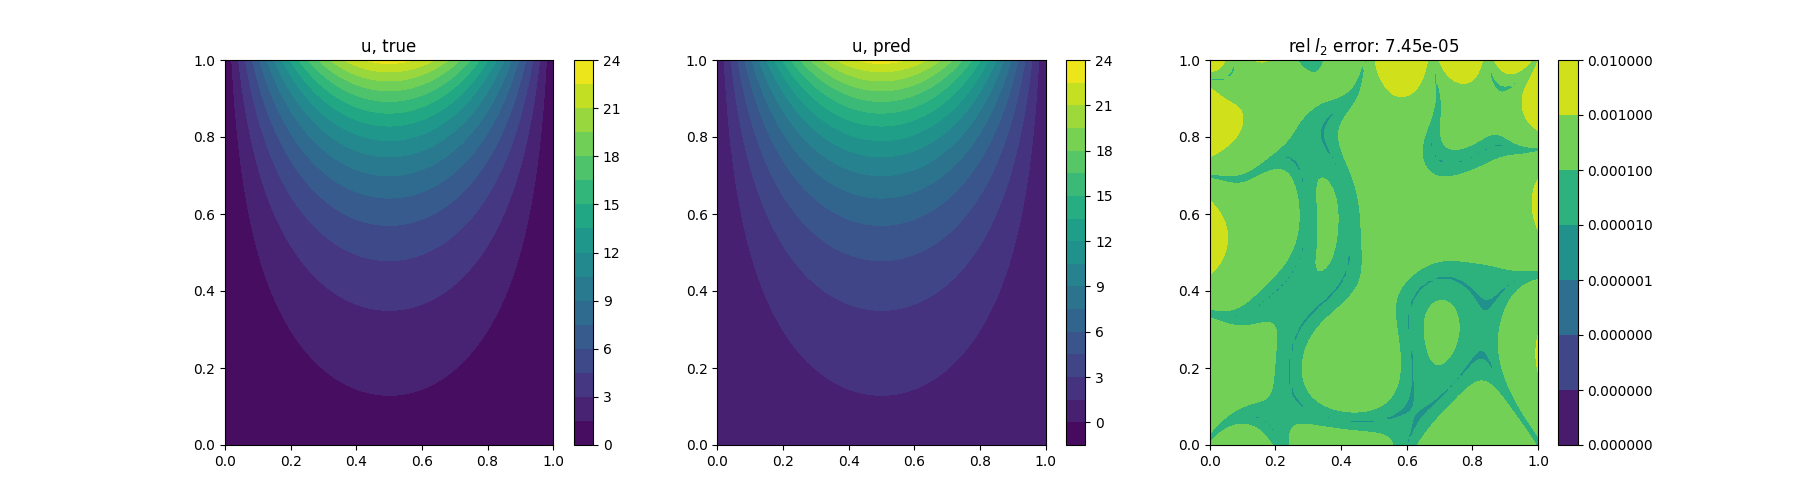

In [8]:
checkpoint_callback = trainer.callbacks[-1]
checkpoint = torch.load(checkpoint_callback.best_model_path)
pinn.load_state_dict(checkpoint["state_dict"])

x_test = torch.from_numpy(x_domain).to(pinn.device)
y_test = torch.from_numpy(y_domain).to(pinn.device)
u_test = u_fn(x_domain, y_domain).reshape((len(x_1d), len(y_1d))).T
with torch.no_grad():
    u_pred = pinn.forward(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
u_err = np.sqrt(np.mean((u_test - u_pred)**2))
u_norm = np.sqrt(np.mean(u_test**2))

X, Y = np.meshgrid(x_1d, y_1d)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
cmap = mpl.cm.viridis
	
fig, axes = plt.subplots(1, 3, figsize = (18, 5))
c0 = axes[0].contourf(X, Y, u_test, cmap = cmap, levels = 20)
c1 = axes[1].contourf(X, Y, u_pred, cmap = cmap, levels = 20)
c2 = axes[2].contourf(X, Y, np.abs(u_test - u_pred), cmap = cmap, norm = mpl.colors.LogNorm())

for c, ax in zip([c0, c1, c2], axes):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes, ["u, true", "u, pred", "rel $l_2$ error: {:.2e}".format(u_err/u_norm)]):
    ax.set_title(name)